# Mount drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# !ls /content/gdrive/My\ Drive

In [ ]:
# !unzip /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319/hw1_data.zip -d /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319

# Import Library

In [1]:
import os

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import json

from tqdm import tqdm
from datetime import datetime

In [2]:
import torch_geometric
from torch_geometric.data import Data, DataLoader
import torch_geometric.utils as utils

In [3]:
import networkit as nk

In [4]:
import networkx as nx

# Setting

In [5]:
class Setting:
    _root = os.getcwd()

    _data = os.path.join(_root, "hw1_data")

    data_synthetic = os.path.join(_data, "Synthetic", "5000")
    data_youtube = os.path.join(_data, "youtube")
    
    
     # Create dir for train/test
    date_time = datetime.strftime(datetime.now(), "%Y-%m-%d %H-%M")
    root = os.path.join(_root, "result", date_time)
    if os.path.exists(root):
        pass
    else:
        os.makedirs(root)


    ### Save plt info
    train_info_p = os.path.join(root, "train.json")
    val_info_p = os.path.join(root, "valid.json")
    test_info_p = os.path.join(root, "test.json")

    ### Save plt img
    result_plt_p = os.path.join(root, "train_plt.png")
    test_plt_p = os.path.join(root, "test_plt.png")
    sum_box_p = os.path.join(root, "sum_box.png")
        
        
    ### Data split
    data_split = os.path.join(_root, "split.json")
    

    # Setting of training
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    mini_epochs = 500
    epochs = 10000

    criterion = nn.BCELoss()
    weight_node2vec = os.path.join(root, "node2vec.pth")
    weight_drbc = os.path.join(root, "drbc.pth")
    
    params_drbc = None
    params_node2vec = None

    

In [6]:
setting = Setting()

# Dataset

## Data

- data.x	节点特征，维度是[num_nodes, num_node_features]。
- data.edge_index	维度是[2, num_edges]，描述图中节点的关联关系，每一列对应的两个元素，分别是边的起点和重点。数据类型是torch.long。需要注意的是，data.edge_index是定义边的节点的张量（tensor），而不是节点的列表（list）。
- data.edge_attr	边的特征矩阵，维度是[num_edges, num_edge_features]
- data.y	训练目标（维度可以是任意的）。对于节点相关的任务，维度为[num_nodes, *]；对于图相关的任务，维度为[1,*]。
- data.position	节点位置矩阵（Node position matrix），维度为[num_nodes, num_dimensions]。

- [Learning to Identify High Betweenness Centrality Nodes from
Scratch: A Novel Graph Neural Network Approach](https://arxiv.org/pdf/1905.10418.pdf)
- node initial feature = [$(d_v), 1, 1]

### Load all data

In [7]:
def load_data(path):

    edge_index = []
    between = []
    for f in os.listdir(path):
        if "score" in f:
            # ground truth of betweenness centrality
            p = os.path.join(path, f)
            between.append(p)
            pass
        else:
            p = os.path.join(path, f)
            edge_index.append(p)

    between.sort()
    edge_index.sort()
    
    return edge_index, between
    
    
synthetic, between = load_data(setting.data_synthetic)
yt, yt_score = load_data(setting.data_youtube)

### Split Data

In [8]:
from sklearn.model_selection import train_test_split


def split_data(path, x, y, replace=False):
    if os.path.exists(path) and replace:
        pass
    else:
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15)

        split = {
            "X_train": X_train,
            "X_valid": X_valid,
            "X_test": X_test,
            "y_train": y_train,
            "y_valid": y_valid,
            "y_test": y_test
        }

        with open(path, 'w') as f:
            json.dump(split, f)
            
split_data(path=setting.data_split, x=synthetic, y=between)

### Cvt 2 dataloader

In [9]:
def to_dataloader(x, y, batch):
    
    data_list = []
    for index, f in enumerate(x):
        edge_index = torch_geometric.io.read_txt_array(f, dtype=torch.long)
        edge_index = edge_index.t().contiguous()
        edge_index = utils.to_undirected(edge_index)

        row, col = edge_index  
        deg = utils.degree(col) # must use col to get degree, why?
        deg = deg.numpy()  

        vertice = []
        for d in deg:
            vertice.append([d, 1, 1])
        vertice = np.array(vertice, dtype=np.float)
        vertice = torch.from_numpy(vertice)

        ### between centrality
        bcs = []
        bc = torch_geometric.io.read_txt_array(y[index], dtype=torch.double)
        bc = bc.t().contiguous()
        row, col = bc
        bc = col
        bc = bc.numpy()
        
        bcs = torch.from_numpy(
                    np.array([[b] for b in bc], dtype=np.float))

        data = Data(x=vertice, edge_index=edge_index, y=bcs)
        data_list.append(data)

    loader = DataLoader(data_list, batch_size=batch)
    return data_list

### Cvt 2 Data

In [10]:
def to_data(x, y):
    edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long)
    edge_index = edge_index.t().contiguous()
    edge_index = utils.to_undirected(edge_index)

    row, col = edge_index  
    deg = utils.degree(col) # must use col to get degree, why?
    deg = deg.numpy()  

    vertice = []
    for d in deg:
        vertice.append([d, 1, 1])
    vertice = np.array(vertice, dtype=np.float)
    vertice = torch.from_numpy(vertice)

    ### between centrality
    bcs = []
    bc = torch_geometric.io.read_txt_array(y, dtype=torch.double)
    bc = bc.t().contiguous()
    row, col = bc
    bc = col
    bc = bc.numpy()
    bcs = torch.from_numpy(
            np.array([[b] for b in bc], dtype=np.float))

    data = Data(x=vertice, edge_index=edge_index, y=bcs)
    
    return data

#### Read data

In [11]:
f = open(setting.data_split, 'r')
data_split = json.load(f)

X_train = data_split["X_train"]
X_valid = data_split["X_valid"]
X_test = data_split["X_test"]
y_train = data_split["y_train"]
y_valid = data_split["y_valid"]
y_test = data_split["y_test"]

f.close()

#### Cvt

In [12]:
train_loader = to_dataloader(X_train, y_train, batch=1)
valid_loader = to_dataloader(X_valid, y_valid, batch=1)
test_loader = to_dataloader(X_test, y_test, batch=1)

#### Use all data

In [13]:
all_loader = to_dataloader(synthetic, between, batch=1)

#### Use YT data

In [14]:
# yt_loader = to_dataloader(yt, yt_score, batch=1)

# Model

## Hyper params

In [15]:
setting.params_drbc = dict(
    # according to source paper
    encoder_params = dict(
        c = 3,
        p = 128,
        num_layers = 5,
        device = setting.device
    ),
    decoder_params = dict(
        p = 128,
        q = 64
    )
)

# setting.params_node2vec = dict(
#     edge_index, 
#     embedding_dim, 
#     walk_length = 10, 
#     context_size,
#     p = 1,
#     q = 2
# )

## DrBC

In [16]:
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.typing import Adj, OptTensor

In [17]:
class Encoder(MessagePassing):
    def __init__(self, c, p, num_layers, device, aggr="add"):
        super(Encoder, self).__init__(aggr=aggr)
        
        self.num_layers = num_layers
        self.w_0 = nn.Linear(in_features=c, out_features=p).double()
        
        self.relu = nn.ReLU(inplace=True)
        self.rnn = nn.GRUCell(p, p).double()

        self.device = device

    def forward(self, data):
        
        x, edge_index = data.x, data.edge_index
        
        
        # compute dgree
        row, col = edge_index
        deg = utils.degree(col)
        deg = torch.add(deg, 1)
        deg_inv_sqrt = torch.pow(deg, -0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        
        # h_0 = x

        # h_1
        x = self.w_0(x)
        x = self.relu(x)
        x = F.normalize(x, p=2, dim=1)
        
        h_s = [x]
        
        for i in range(self.num_layers-1):
            # internally calls the message(), aggregate() and update() functions
            x = self.propagate(edge_index, x=x, norm=norm)
            h_s.append(x)
        
        h_s = torch.stack(h_s, dim=-1)
        # Use torch.max to replace max_pooling
        z, _ = torch.max(h_s, dim=-1)
        # z = global_max_pool(h_s, torch.tensor([0], dtype=torch.long).to(self.device))
        
        return z

    def message(self, x_j, norm: OptTensor):
        """      
        In addition, tensors passed to propagate() can be mapped to the respective nodes i and j 
        by appending _i or _j to the variable name, .e.g. x_i and x_j. 
        Note that we generally refer to i as the central nodes that aggregates information, 
        and refer to j as the neighboring nodes, since this is the most common notation.
        """
  
        return x_j if norm is None else norm.view(-1, 1) * x_j
    
    
    def update(self, aggr_out, x):
        """        
        Takes in the output of aggregation as first argument 
        and any argument which was initially passed to propagate().
        """

        x = self.rnn(x, aggr_out)
        x = F.normalize(x, p=2, dim=1) 
        
        return x
    

In [18]:
class Decoder(nn.Module):
    def __init__(self, p, q):
        
        super().__init__()
        
        self.w_4 = nn.Linear(in_features=p, out_features=q).double()
        self.w_5 = nn.Linear(in_features=q, out_features=1).double()
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, z):
        z = self.w_4(z)
        z = self.relu(z)
        z = self.w_5(z)
        
        return z

In [19]:
class DrBC(nn.Module):
    def __init__(self, encoder_params, decoder_params):
        super().__init__()
        
        self.encoder = Encoder(**encoder_params)
        self.decoder = Decoder(**decoder_params)
        
        
    def forward(self, data):
        
        z = self.encoder(data)
        
        return self.decoder(z)

## Node2Vec

In [20]:
from torch_geometric.nn import Node2Vec

In [21]:
class BC_node2vec(nn.Module):
    
    def __init__(self, node2vec_params):
        super().__init__()
        
        self.node2vec = Node2Vec(**node2vec_params)
        self.mlp = nn.Linear(in_features=128, out_features=1)
        
    def forward(self, data):
        
        x = self.node2vec(data)
        x = self.mlp(x)
        
        return x

# Load model

In [22]:
def load_checkpoint(filepath, device, **params):

    if "node2vec" in filepath:
        model = BC_node2vec(**params["node2vec"])
    
    else:
        model = DrBC(**params["drbc"])
    
    model = model.to(setting.device)
    
    if os.path.exists(filepath):
        print("pretrained finded")
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['model_stat'])
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        optimizer.load_state_dict(checkpoint['optimizer_stat'])

    else:
        print("use a new optimizer")
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    return model, optimizer

# Evaluation

### Top k %

In [29]:
def top_n(model, data, k):

    with torch.no_grad():

        data = data.to(setting.device)

        bc_gt = data.y
        bc_gt = torch.reshape(bc_gt, (-1, ))
        
        nodes = bc_gt.size()[0]
        k = int(nodes * k / 100)

        bc_pr = model(data)

        bc_gt = bc_gt.squeeze().to(setting.device)
        bc_pr = bc_pr.squeeze()

        gt_value, gt_indice = torch.topk(bc_gt, k)
        pr_value, pr_indice = torch.topk(bc_pr, k)

        gt_indice = set(gt_indice.cpu().numpy())
        pr_indice = set(pr_indice.cpu().numpy())

        intersect = len(gt_indice & pr_indice)
        top = intersect/k
            
       

        return top

### Tau Kendal

In [30]:
from scipy import stats

def tau_distance(model, data):
    
    
    with torch.no_grad():
 
        data = data.to(setting.device)

        bc_gt = data.y
        bc_gt = torch.reshape(bc_gt, (-1, ))

        bc_pr = model(data)

        bc_gt = bc_gt.squeeze().cpu().numpy()
        bc_pr = bc_pr.squeeze().cpu().numpy()


        tau, p_value = stats.kendalltau(bc_gt, bc_pr)
       

    return tau

### Evaluation Mode

In [31]:
def eval_model(model, data):
    
    with torch.no_grad():
        data = data.to(setting.device)
        bc_pr = model(data)

        bc_gt = data.y
        bc_gt = torch.reshape(bc_gt, (-1, ))
        
        nodes = bc_gt.size()[0]

        # random sample 5|V| nodes
        src = (torch.rand(nodes * 5) * (nodes-1)).long()
        det = (torch.rand(nodes * 5) * (nodes-1)).long()

        y_gt = (bc_gt[det] - bc_gt[src]).squeeze().to(setting.device)
        y_pr = (bc_pr[det] - bc_pr[src]).squeeze()

        y_gt = nn.Sigmoid()(y_gt)
        y_pr = nn.Sigmoid()(y_pr)

        loss = nn.BCELoss(reduction="sum")(y_pr, y_gt)
        
        return loss.item()

In [38]:
def from_networkx(G, between_list):
    r"""Converts a :obj:`networkx.Graph` or :obj:`networkx.DiGraph` to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        G (networkx.Graph or networkx.DiGraph): A networkx graph.
    """

    G = nx.convert_node_labels_to_integers(G)
    G = G.to_directed() if not nx.is_directed(G) else G
    edge_index = torch.LongTensor(list(G.edges)).t().contiguous()
   
    data = {}

    for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
        for key, value in feat_dict.items():
           
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for key, item in data.items():
        try:
            data[key] = torch.tensor(item)
        except ValueError:
            pass

    data['edge_index'] = edge_index.view(2, -1)
    data['x'] = torch.from_numpy(
        np.array( [ [G.degree[i], 1, 1] for i in G.nodes()], dtype=np.float ) )
    data['y'] = torch.from_numpy(
        np.array( [ [b] for b in between_list ] , dtype=np.float) )
    data = torch_geometric.data.Data.from_dict(data)
    data.num_nodes = G.number_of_nodes()

    return data

# Train

In [39]:
model, optimizer = load_checkpoint(
                    setting.weight_drbc,
                    setting.device,
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)

use a new optimizer


In [40]:
nodes_cnt = 1200


model.train()

train_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

valid_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

top_10 = 0.0
top_5 = 0.0
top_1 = 0.0

for epoch in range(setting.epochs):
    
    # Draw network G from distribution D (like the power-law model)
    G = nx.generators.random_graphs.powerlaw_cluster_graph(n=nodes_cnt, m=4, p=0.05)
    # Calculate each node’s exact BC value bv, ∀v ∈ V
    betweenness = nx.algorithms.centrality.betweenness_centrality(G)
    
    # Convert betweenness dict to list
    between_list = list(betweenness.values())
    
    # Convert networkx.Graph to Pyg Data
    pyg_data = from_networkx(G, between_list)
    print("\nEpoch: {}".format(epoch+1))
    
    

    
    ### Start training
    optimizer.zero_grad()

    pyg_data = pyg_data.to(setting.device)
    bc_pr = model(pyg_data)

    bc_gt = pyg_data.y
#     bc_gt = np.array(bc_gt)
#     bc_gt = torch.from_numpy(bc_gt)
    bc_gt = torch.reshape(bc_gt, (-1, ))

    # random sample 5|V| nodes
    src = (torch.rand(nodes_cnt * 5) * (nodes_cnt-1)).long()
    det = (torch.rand(nodes_cnt * 5) * (nodes_cnt-1)).long()

    y_gt = (bc_gt[det] - bc_gt[src]).squeeze().to(setting.device)
    y_pr = (bc_pr[det] - bc_pr[src]).squeeze()

    y_gt = nn.Sigmoid()(y_gt)
    y_pr = nn.Sigmoid()(y_pr)

    loss = nn.BCELoss(reduction="sum")(y_pr, y_gt)

    loss.backward()
    optimizer.step()
    
    
    ### Evaluation:- Train
    top1 = top_n(model, pyg_data, k=1)
    top5 = top_n(model, pyg_data, k=5)
    top10 = top_n(model, pyg_data, k=10)
    kendal = tau_distance(model, pyg_data)

    print("Train: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
            loss.item(),
            top1,
            top5,
            top10,
            kendal
    ))

    train_info["bce"].append(loss.item())
    train_info["top1"].append(top1)
    train_info["top5"].append(top5)
    train_info["top10"].append(top10)
    train_info["kendal"].append(kendal)

    with open(setting.train_info_p, 'w') as f:
        json.dump(train_info, f)



    ### Evaluation:- Synthetic
    bce_l = []
    top1_l = []
    top5_l = []
    top10_l = []
    kendal_l = []

    for data in all_loader:
        bce_l.append(eval_model(model, data))
        top1_l.append(top_n(model, data, k=1))
        top5_l.append(top_n(model, data, k=5))
        top10_l.append(top_n(model, data, k=10))
        kendal_l.append(tau_distance(model, data))
        
    bce = sum(bce_l)/len(bce_l)
    top1 = sum(top1_l)/len(top1_l)
    top5 = sum(top5_l)/len(top5_l)
    top10 = sum(top10_l)/len(top10_l)
    kendal = sum(kendal_l)/len(kendal_l)
        
    print("Valid: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
        bce,
        top1,
        top5,
        top10,
        kendal
    ))

    valid_info["bce"].append(bce)
    valid_info["top1"].append(top1)
    valid_info["top5"].append(top5)
    valid_info["top10"].append(top10)
    valid_info["kendal"].append(kendal)

    with open(setting.val_info_p, 'w') as f:
        json.dump(valid_info, f)
        
    
    if top10 > top_10:
        checkpoint = {
            'model_stat': model.state_dict(),
            'optimizer_stat': optimizer.state_dict(),
        }
        torch.save(checkpoint, setting.weight_drbc)
        top_10 = top10


Epoch: 1
Train: loss = 4158.877075026048, top 1 = 0.9166666666666666, top 5 = 0.4666666666666667, top 10 = 0.7166666666666667, kendal = 0.5676536002224076
Valid: loss = 17328.684399215424, top 1 = 0.6439999999999999, top 5 = 0.6566666666666665, top 10 = 0.6620000000000001, kendal = 0.38627112622524507

Epoch: 2
Train: loss = 4158.873393340475, top 1 = 1.0, top 5 = 0.7833333333333333, top 10 = 0.8833333333333333, kendal = 0.5940394773422296
Valid: loss = 17328.685122359824, top 1 = 0.6566666666666666, top 5 = 0.6562666666666667, top 10 = 0.658, kendal = 0.39664811362272456

Epoch: 3
Train: loss = 4158.870344715957, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.8916666666666667, kendal = 0.6064692799555185
Valid: loss = 17328.687143493953, top 1 = 0.6606666666666666, top 5 = 0.65, top 10 = 0.6534, kendal = 0.4054476495299059

Epoch: 4
Train: loss = 4158.868320603315, top 1 = 0.8333333333333334, top 5 = 0.9333333333333333, top 10 = 0.8916666666666667, kendal = 0.5981

Valid: loss = 17328.733077646622, top 1 = 0.6546666666666666, top 5 = 0.6232, top 10 = 0.6273333333333333, kendal = 0.46431897046075876

Epoch: 30
Train: loss = 4158.838415064778, top 1 = 0.8333333333333334, top 5 = 0.8666666666666667, top 10 = 0.8416666666666667, kendal = 0.6078426466499861
Valid: loss = 17328.73390975048, top 1 = 0.6546666666666666, top 5 = 0.6230666666666665, top 10 = 0.6268, kendal = 0.46404898046275916

Epoch: 31
Train: loss = 4158.842839228288, top 1 = 1.0, top 5 = 0.85, top 10 = 0.825, kendal = 0.6012121212121212
Valid: loss = 17328.734807674675, top 1 = 0.6546666666666666, top 5 = 0.6230666666666665, top 10 = 0.6259333333333335, kendal = 0.46366894178835777

Epoch: 32
Train: loss = 4158.838511732878, top 1 = 0.8333333333333334, top 5 = 0.9, top 10 = 0.8666666666666667, kendal = 0.6054017236586045
Valid: loss = 17328.735882227167, top 1 = 0.6546666666666666, top 5 = 0.6227999999999999, top 10 = 0.6254666666666666, kendal = 0.46341262919250514

Epoch: 33
Train: l

Valid: loss = 17328.753272884256, top 1 = 0.6553333333333333, top 5 = 0.6174666666666667, top 10 = 0.6233333333333333, kendal = 0.4851314689604588

Epoch: 59
Train: loss = 4158.838597705744, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.8416666666666667, kendal = 0.653705865999444
Valid: loss = 17328.75496562372, top 1 = 0.6546666666666666, top 5 = 0.6177333333333334, top 10 = 0.6242666666666666, kendal = 0.4850118877108756

Epoch: 60
Train: loss = 4158.831096737492, top 1 = 0.8333333333333334, top 5 = 0.8833333333333333, top 10 = 0.8833333333333333, kendal = 0.6557853767028079
Valid: loss = 17328.757998244542, top 1 = 0.6546666666666666, top 5 = 0.6174666666666666, top 10 = 0.6243333333333332, kendal = 0.4845406734680271

Epoch: 61
Train: loss = 4158.830122408557, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.8583333333333333, kendal = 0.6484959688629414
Valid: loss = 17328.756872939517, top 1 = 0.6553333333333333, top 5 = 0.6175999999999999, 


Epoch: 88
Train: loss = 4158.837012869199, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9083333333333333, kendal = 0.605123714206283
Valid: loss = 17328.769083019273, top 1 = 0.654, top 5 = 0.6153333333333334, top 10 = 0.6235333333333332, kendal = 0.43555765019670595

Epoch: 89
Train: loss = 4158.8130923991375, top 1 = 0.8333333333333334, top 5 = 0.8333333333333334, top 10 = 0.875, kendal = 0.6072977481234362
Valid: loss = 17328.766300779713, top 1 = 0.6546666666666667, top 5 = 0.6154666666666666, top 10 = 0.6235333333333333, kendal = 0.4390432859905314

Epoch: 90
Train: loss = 4158.823739898762, top 1 = 0.8333333333333334, top 5 = 0.9, top 10 = 0.8583333333333333, kendal = 0.622262996941896
Valid: loss = 17328.767609869647, top 1 = 0.6546666666666667, top 5 = 0.6153333333333334, top 10 = 0.6234666666666667, kendal = 0.44614775221711017

Epoch: 91
Train: loss = 4158.8267642049595, top 1 = 0.9166666666666666, top 5 = 0.9, top 10 = 0.875, kendal = 0.629252154573255

Valid: loss = 17328.781141950618, top 1 = 0.6546666666666667, top 5 = 0.6180000000000001, top 10 = 0.6419333333333334, kendal = 0.46022809361872385

Epoch: 117
Train: loss = 4158.825293873555, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.8916666666666667, kendal = 0.6862246316374756
Valid: loss = 17328.784588832183, top 1 = 0.6546666666666667, top 5 = 0.6186666666666666, top 10 = 0.6427333333333335, kendal = 0.4624829659265187

Epoch: 118
Train: loss = 4158.805089596185, top 1 = 0.9166666666666666, top 5 = 0.9, top 10 = 0.8916666666666667, kendal = 0.6826494300806227
Valid: loss = 17328.789014202313, top 1 = 0.6546666666666667, top 5 = 0.6185333333333333, top 10 = 0.6425333333333333, kendal = 0.46144633193305323

Epoch: 119
Train: loss = 4158.793094033253, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.8083333333333333, kendal = 0.6608868501529053
Valid: loss = 17328.793299891604, top 1 = 0.6546666666666667, top 5 = 0.6185333333333334, top 10 =

Valid: loss = 17328.811768277243, top 1 = 0.6546666666666667, top 5 = 0.6261333333333334, top 10 = 0.6481333333333335, kendal = 0.4661057704874308

Epoch: 146
Train: loss = 4158.798336610771, top 1 = 0.9166666666666666, top 5 = 0.8833333333333333, top 10 = 0.875, kendal = 0.6665832638309702
Valid: loss = 17328.814604503226, top 1 = 0.6546666666666667, top 5 = 0.6265333333333333, top 10 = 0.6487333333333333, kendal = 0.4714410295392411

Epoch: 147
Train: loss = 4158.82301665184, top 1 = 0.9166666666666666, top 5 = 0.9, top 10 = 0.8833333333333333, kendal = 0.6816152349179871
Valid: loss = 17328.817494861385, top 1 = 0.6546666666666667, top 5 = 0.6266666666666667, top 10 = 0.6490000000000001, kendal = 0.4768613189304528

Epoch: 148
Train: loss = 4158.82174953532, top 1 = 1.0, top 5 = 0.9, top 10 = 0.875, kendal = 0.6803808729496802
Valid: loss = 17328.815920050514, top 1 = 0.6546666666666667, top 5 = 0.6270666666666667, top 10 = 0.6492666666666668, kendal = 0.47974464226178587

Epoch: 14


Epoch: 174
Train: loss = 4158.813243721597, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.6697358910202946
Valid: loss = 17328.812296441396, top 1 = 0.6539999999999999, top 5 = 0.6294666666666667, top 10 = 0.6504000000000001, kendal = 0.4801698526371941

Epoch: 175
Train: loss = 4158.7977974477435, top 1 = 0.9166666666666666, top 5 = 0.8333333333333334, top 10 = 0.9, kendal = 0.6254712260216848
Valid: loss = 17328.82137039752, top 1 = 0.6546666666666667, top 5 = 0.6291999999999999, top 10 = 0.6506, kendal = 0.46985187437487497

Epoch: 176
Train: loss = 4158.822528359075, top 1 = 0.8333333333333334, top 5 = 0.8833333333333333, top 10 = 0.875, kendal = 0.5490130664442591
Valid: loss = 17328.821523137, top 1 = 0.6546666666666667, top 5 = 0.6294666666666665, top 10 = 0.6504666666666665, kendal = 0.45916763085950524

Epoch: 177
Train: loss = 4158.815223162969, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.8916666666666667, kendal = 0.

Valid: loss = 17328.8423547085, top 1 = 0.6533333333333332, top 5 = 0.6344, top 10 = 0.6556666666666666, kendal = 0.4790832619857305

Epoch: 203
Train: loss = 4158.822384620396, top 1 = 1.0, top 5 = 0.9, top 10 = 0.8833333333333333, kendal = 0.6966638865721435
Valid: loss = 17328.83645385244, top 1 = 0.6539999999999999, top 5 = 0.6342666666666666, top 10 = 0.6567333333333332, kendal = 0.4765799933319998

Epoch: 204
Train: loss = 4158.802835342076, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9, kendal = 0.665031971087017
Valid: loss = 17328.826764461854, top 1 = 0.6539999999999999, top 5 = 0.6341333333333333, top 10 = 0.6574666666666664, kendal = 0.475366097219444

Epoch: 205
Train: loss = 4158.819116051247, top 1 = 0.8333333333333334, top 5 = 0.9, top 10 = 0.8916666666666667, kendal = 0.6678482068390326
Valid: loss = 17328.822032124714, top 1 = 0.6539999999999999, top 5 = 0.6341333333333333, top 10 = 0.6577999999999998, kendal = 0.47772615323064616

Epoch: 206
Train: loss = 4158.796443374689


Epoch: 231
Train: loss = 4158.815818519544, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9083333333333333, kendal = 0.7329691409507922
Valid: loss = 17328.845005895146, top 1 = 0.6539999999999999, top 5 = 0.6384000000000001, top 10 = 0.6566666666666665, kendal = 0.46734766153230656

Epoch: 232
Train: loss = 4158.810739626915, top 1 = 0.9166666666666666, top 5 = 0.9, top 10 = 0.85, kendal = 0.7295162635529608
Valid: loss = 17328.8369808905, top 1 = 0.6539999999999999, top 5 = 0.6382666666666668, top 10 = 0.6566666666666665, kendal = 0.4659231953057279

Epoch: 233
Train: loss = 4158.7950900181895, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.85, kendal = 0.7378509869335558
Valid: loss = 17328.835183631276, top 1 = 0.6539999999999999, top 5 = 0.6382666666666668, top 10 = 0.6568666666666665, kendal = 0.4654534800293393

Epoch: 234
Train: loss = 4158.820143778551, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.8833333333333333, kendal = 0.73


Epoch: 260
Train: loss = 4158.80961752618, top 1 = 0.75, top 5 = 0.9166666666666666, top 10 = 0.9083333333333333, kendal = 0.7271087016958577
Valid: loss = 17328.844323202786, top 1 = 0.6553333333333333, top 5 = 0.6399999999999998, top 10 = 0.6598666666666666, kendal = 0.4380251623658065

Epoch: 261
Train: loss = 4158.8194560704305, top 1 = 0.8333333333333334, top 5 = 0.9166666666666666, top 10 = 0.925, kendal = 0.7408785098693356
Valid: loss = 17328.853793853974, top 1 = 0.6566666666666666, top 5 = 0.64, top 10 = 0.6592666666666667, kendal = 0.4398766740014669

Epoch: 262
Train: loss = 4158.816643523351, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.8916666666666667, kendal = 0.7136836252432582
Valid: loss = 17328.855872310192, top 1 = 0.6566666666666666, top 5 = 0.6402666666666667, top 10 = 0.6593333333333332, kendal = 0.4414728278989131

Epoch: 263
Train: loss = 4158.827024474664, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9083333333333333, kendal = 0.


Epoch: 289
Train: loss = 4158.840287372528, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9166666666666666, kendal = 0.7038281901584654
Valid: loss = 17328.84636670659, top 1 = 0.656, top 5 = 0.6437333333333334, top 10 = 0.6659999999999999, kendal = 0.45045149296525977

Epoch: 290
Train: loss = 4158.812275283045, top 1 = 0.8333333333333334, top 5 = 0.9166666666666666, top 10 = 0.9166666666666666, kendal = 0.6877397831526272
Valid: loss = 17328.84757401808, top 1 = 0.6560000000000001, top 5 = 0.6441333333333333, top 10 = 0.6652666666666666, kendal = 0.44826669333866775

Epoch: 291
Train: loss = 4158.819913003637, top 1 = 0.8333333333333334, top 5 = 0.95, top 10 = 0.925, kendal = 0.6971476230191826
Valid: loss = 17328.85183303998, top 1 = 0.6560000000000001, top 5 = 0.6438666666666667, top 10 = 0.6641999999999998, kendal = 0.446777872907915

Epoch: 292
Train: loss = 4158.816286073882, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.7289769252154573
Valid: loss = 

Valid: loss = 17328.862832662784, top 1 = 0.6560000000000001, top 5 = 0.6458666666666667, top 10 = 0.6665333333333336, kendal = 0.42685173834766954

Epoch: 318
Train: loss = 4158.8036240335405, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9166666666666666, kendal = 0.739024186822352
Valid: loss = 17328.858196424764, top 1 = 0.6566666666666667, top 5 = 0.6457333333333334, top 10 = 0.6670666666666667, kendal = 0.4270774368206975

Epoch: 319
Train: loss = 4158.839090949096, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9166666666666666, kendal = 0.7580011120378093
Valid: loss = 17328.85672965606, top 1 = 0.6566666666666667, top 5 = 0.6461333333333334, top 10 = 0.6667333333333334, kendal = 0.4301054184170167

Epoch: 320
Train: loss = 4158.816365718545, top 1 = 0.9166666666666666, top 5 = 0.8833333333333333, top 10 = 0.8916666666666667, kendal = 0.7420183486238532
Valid: loss = 17328.854961568886, top 1 = 0.6566666666666667, top 5 = 0.6461333333333


Epoch: 346
Train: loss = 4158.797622702185, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9, kendal = 0.6281234361968308
Valid: loss = 17328.87084931802, top 1 = 0.6560000000000001, top 5 = 0.6462666666666667, top 10 = 0.6641333333333332, kendal = 0.4086843662065747

Epoch: 347
Train: loss = 4158.800621378659, top 1 = 1.0, top 5 = 0.9, top 10 = 0.875, kendal = 0.5808117876007785
Valid: loss = 17328.872578788203, top 1 = 0.6560000000000001, top 5 = 0.6464, top 10 = 0.6644666666666665, kendal = 0.40072543041941716

Epoch: 348
Train: loss = 4158.8190440895705, top 1 = 1.0, top 5 = 0.9, top 10 = 0.925, kendal = 0.667775924381429
Valid: loss = 17328.875901106498, top 1 = 0.6560000000000001, top 5 = 0.6465333333333334, top 10 = 0.6651333333333336, kendal = 0.41776999133159953

Epoch: 349
Train: loss = 4158.815203869563, top 1 = 1.0, top 5 = 0.95, top 10 = 0.8666666666666667, kendal = 0.7552488184598276
Valid: loss = 17328.874838097505, top 1 = 0.6560000000000001, top 5 


Epoch: 375
Train: loss = 4158.807676847267, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9166666666666666, kendal = 0.7638949124270226
Valid: loss = 17328.86636750317, top 1 = 0.658, top 5 = 0.6481333333333333, top 10 = 0.6674666666666668, kendal = 0.44863730079349207

Epoch: 376
Train: loss = 4158.8188599683435, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9166666666666666, kendal = 0.7618126216291353
Valid: loss = 17328.86164748473, top 1 = 0.658, top 5 = 0.6485333333333333, top 10 = 0.6683333333333333, kendal = 0.447222527172101

Epoch: 377
Train: loss = 4158.791108930219, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.875, kendal = 0.7538643313872672
Valid: loss = 17328.861034828133, top 1 = 0.658, top 5 = 0.6488, top 10 = 0.6686, kendal = 0.4466294005467761

Epoch: 378
Train: loss = 4158.81909030627, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9, kendal = 0.7495996663886572
Valid: loss = 17328.


Epoch: 405
Train: loss = 4158.817539942238, top 1 = 0.9166666666666666, top 5 = 0.9, top 10 = 0.8583333333333333, kendal = 0.6923213789268835
Valid: loss = 17328.861558799326, top 1 = 0.6586666666666667, top 5 = 0.6522666666666667, top 10 = 0.6671999999999999, kendal = 0.39657610455424414

Epoch: 406
Train: loss = 4158.790819722623, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9083333333333333, kendal = 0.7457964970809007
Valid: loss = 17328.867006535198, top 1 = 0.6586666666666667, top 5 = 0.6521333333333335, top 10 = 0.6679333333333336, kendal = 0.4104358685070348

Epoch: 407
Train: loss = 4158.782474542973, top 1 = 1.0, top 5 = 0.8833333333333333, top 10 = 0.8916666666666667, kendal = 0.7533861551292744
Valid: loss = 17328.867099157476, top 1 = 0.6586666666666667, top 5 = 0.6515999999999998, top 10 = 0.6671333333333332, kendal = 0.4216504154164166

Epoch: 408
Train: loss = 4158.809815310906, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.90


Epoch: 434
Train: loss = 4158.800432482392, top 1 = 0.9166666666666666, top 5 = 0.9, top 10 = 0.8916666666666667, kendal = 0.7511509591326105
Valid: loss = 17328.87789100716, top 1 = 0.6586666666666667, top 5 = 0.6539999999999999, top 10 = 0.6675333333333332, kendal = 0.42151240914849636

Epoch: 435
Train: loss = 4158.820805156356, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9166666666666666, kendal = 0.717164303586322
Valid: loss = 17328.86955738546, top 1 = 0.6586666666666667, top 5 = 0.6541333333333335, top 10 = 0.6681333333333332, kendal = 0.4148155071014204

Epoch: 436
Train: loss = 4158.802180733845, top 1 = 1.0, top 5 = 0.85, top 10 = 0.9416666666666667, kendal = 0.7025799277175424
Valid: loss = 17328.868721362174, top 1 = 0.6586666666666667, top 5 = 0.654, top 10 = 0.6692, kendal = 0.4111122704540909

Epoch: 437
Train: loss = 4158.784377442065, top 1 = 0.8333333333333334, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.713808729496803
Valid: loss = 


Epoch: 463
Train: loss = 4158.820091816027, top 1 = 1.0, top 5 = 0.95, top 10 = 0.925, kendal = 0.7720517097581318
Valid: loss = 17328.88626383154, top 1 = 0.6586666666666666, top 5 = 0.6550666666666667, top 10 = 0.6686000000000001, kendal = 0.4292950056678002

Epoch: 464
Train: loss = 4158.767818548977, top 1 = 0.9166666666666666, top 5 = 0.9, top 10 = 0.9, kendal = 0.7789018626633305
Valid: loss = 17328.890341609902, top 1 = 0.6586666666666666, top 5 = 0.6547999999999999, top 10 = 0.6680666666666667, kendal = 0.4322569900646796

Epoch: 465
Train: loss = 4158.813391740939, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.8916666666666667, kendal = 0.7747094801223241
Valid: loss = 17328.903327961227, top 1 = 0.6586666666666666, top 5 = 0.6552, top 10 = 0.6676666666666669, kendal = 0.43212057344802296

Epoch: 466
Train: loss = 4158.815017909318, top 1 = 0.8333333333333334, top 5 = 0.95, top 10 = 0.8916666666666667, kendal = 0.777620239088129
Valid: loss = 17328.902991120147, top 1 


Epoch: 492
Train: loss = 4158.785196053939, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9, kendal = 0.7565165415624131
Valid: loss = 17328.891820766406, top 1 = 0.6593333333333332, top 5 = 0.6566666666666666, top 10 = 0.67, kendal = 0.41747017136760683

Epoch: 493
Train: loss = 4158.814853843451, top 1 = 1.0, top 5 = 0.8833333333333333, top 10 = 0.925, kendal = 0.7377175423964414
Valid: loss = 17328.889183199524, top 1 = 0.6586666666666666, top 5 = 0.6570666666666667, top 10 = 0.6695333333333332, kendal = 0.4205665879842636

Epoch: 494
Train: loss = 4158.812622450895, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9583333333333334, kendal = 0.7318265221017515
Valid: loss = 17328.88264819979, top 1 = 0.6586666666666666, top 5 = 0.6569333333333334, top 10 = 0.6686000000000001, kendal = 0.42097728879109153

Epoch: 495
Train: loss = 4158.8128752901985, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9083333333333333, kendal = 0.74522935779816

Valid: loss = 17328.88341736553, top 1 = 0.6606666666666665, top 5 = 0.6573333333333333, top 10 = 0.6662, kendal = 0.3992528799093152

Epoch: 521
Train: loss = 4158.802493738915, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9166666666666666, kendal = 0.7726716708368084
Valid: loss = 17328.892214088108, top 1 = 0.6606666666666665, top 5 = 0.6571999999999999, top 10 = 0.6654666666666667, kendal = 0.39928674268186976

Epoch: 522
Train: loss = 4158.830432101152, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.7711398387545176
Valid: loss = 17328.889781435555, top 1 = 0.6606666666666665, top 5 = 0.6570666666666667, top 10 = 0.6649999999999998, kendal = 0.3980402533840102

Epoch: 523
Train: loss = 4158.817794346449, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9166666666666666, kendal = 0.7531387267167085
Valid: loss = 17328.899519492632, top 1 = 0.6599999999999999, top 5 = 0.6564, top 10 = 0.6644666666666665, kenda


Epoch: 549
Train: loss = 4158.815317396473, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9333333333333333, kendal = 0.7245954962468725
Valid: loss = 17328.879742687615, top 1 = 0.6606666666666665, top 5 = 0.6579999999999999, top 10 = 0.6662666666666668, kendal = 0.38744050143361997

Epoch: 550
Train: loss = 4158.821828083499, top 1 = 1.0, top 5 = 0.9166666666666666, top 10 = 0.925, kendal = 0.7688434806783431
Valid: loss = 17328.875162568078, top 1 = 0.6599999999999999, top 5 = 0.6581333333333333, top 10 = 0.6668666666666666, kendal = 0.3957325225045008

Epoch: 551
Train: loss = 4158.819273842497, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9, kendal = 0.7587128162357519
Valid: loss = 17328.88557858531, top 1 = 0.6599999999999999, top 5 = 0.6577333333333333, top 10 = 0.6667333333333333, kendal = 0.4066548509701941

Epoch: 552
Train: loss = 4158.774983706821, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.8916666666666667, kendal = 0.7541645815957743
Valid: loss = 17328.893109050


Epoch: 578
Train: loss = 4158.788557512025, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.7213733666944676
Valid: loss = 17328.88375469854, top 1 = 0.6613333333333333, top 5 = 0.6586666666666666, top 10 = 0.6674666666666667, kendal = 0.3784847689537909

Epoch: 579
Train: loss = 4158.796419071714, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9083333333333333, kendal = 0.7382624409229914
Valid: loss = 17328.87407414345, top 1 = 0.6613333333333333, top 5 = 0.6584, top 10 = 0.6668, kendal = 0.37823807961592315

Epoch: 580
Train: loss = 4158.826721570002, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.7745037531276063
Valid: loss = 17328.887449388847, top 1 = 0.6613333333333333, top 5 = 0.6581333333333332, top 10 = 0.6653999999999999, kendal = 0.39312953790758154

Epoch: 581
Train: loss = 4158.7815073100555, top 1 = 0.9166666666666666, top 5 = 0.8833333333333333, top 10 = 0.9083333333333333, kendal = 0.774428690575

Valid: loss = 17328.862559185065, top 1 = 0.6613333333333332, top 5 = 0.6589333333333335, top 10 = 0.6549333333333333, kendal = 0.32254879775955203

Epoch: 607
Train: loss = 4158.792539345519, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9583333333333334, kendal = 0.6379955518487629
Valid: loss = 17328.86552626999, top 1 = 0.6606666666666665, top 5 = 0.6586666666666666, top 10 = 0.6563333333333333, kendal = 0.3457405294392211

Epoch: 608
Train: loss = 4158.820063009761, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9083333333333333, kendal = 0.7238448707256048
Valid: loss = 17328.884838863887, top 1 = 0.6606666666666665, top 5 = 0.6579999999999998, top 10 = 0.6565333333333334, kendal = 0.3835655184370207

Epoch: 609
Train: loss = 4158.801008914052, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9083333333333333, kendal = 0.7271809841534612
Valid: loss = 17328.908563089128, top 1 = 0.6613333333333332, top 5 = 0.6573333333333333, top 10 = 0.6562666666666667, kendal = 0.402466226578649


Epoch: 636
Train: loss = 4158.808007817085, top 1 = 1.0, top 5 = 0.9, top 10 = 0.925, kendal = 0.7822741173199889
Valid: loss = 17328.8742036876, top 1 = 0.662, top 5 = 0.6592000000000001, top 10 = 0.6624, kendal = 0.3805298926451957

Epoch: 637
Train: loss = 4158.829157191003, top 1 = 1.0, top 5 = 0.9166666666666666, top 10 = 0.9416666666666667, kendal = 0.7768028912983042
Valid: loss = 17328.86898163914, top 1 = 0.662, top 5 = 0.6593333333333334, top 10 = 0.6615333333333333, kendal = 0.37412325665133034

Epoch: 638
Train: loss = 4158.786711477676, top 1 = 0.75, top 5 = 0.9166666666666666, top 10 = 0.9083333333333333, kendal = 0.7510842368640533
Valid: loss = 17328.88227755122, top 1 = 0.662, top 5 = 0.6596000000000001, top 10 = 0.6621333333333332, kendal = 0.37611797559511906

Epoch: 639
Train: loss = 4158.813832183209, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9, kendal = 0.7890047261606895
Valid: loss = 17328.890563572786, top 1 = 0.662, top 5 = 0.6582666666666666, top 10 = 0.6634, ke

Valid: loss = 17328.919636161034, top 1 = 0.6613333333333333, top 5 = 0.6593333333333333, top 10 = 0.6606000000000001, kendal = 0.3967682283123291

Epoch: 666
Train: loss = 4158.778729618312, top 1 = 0.8333333333333334, top 5 = 0.8666666666666667, top 10 = 0.9166666666666666, kendal = 0.7583931053655825
Valid: loss = 17328.90392454997, top 1 = 0.6613333333333333, top 5 = 0.6600000000000001, top 10 = 0.6612666666666666, kendal = 0.3822293365339735

Epoch: 667
Train: loss = 4158.817521456656, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.7268501529051987
Valid: loss = 17328.887999302264, top 1 = 0.6613333333333333, top 5 = 0.6605333333333334, top 10 = 0.6617333333333334, kendal = 0.365163726078549

Epoch: 668
Train: loss = 4158.828140135003, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9333333333333333, kendal = 0.7595023630803447
Valid: loss = 17328.885567867994, top 1 = 0.6613333333333333, top 5 = 0.6602666666666668, top 10 = 0.

Valid: loss = 17328.938954624242, top 1 = 0.6606666666666666, top 5 = 0.6586666666666666, top 10 = 0.6556666666666666, kendal = 0.383092650530106

Epoch: 695
Train: loss = 4158.811112791692, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9166666666666666, kendal = 0.7880817347789825
Valid: loss = 17328.920119517952, top 1 = 0.6613333333333333, top 5 = 0.6587999999999999, top 10 = 0.6539333333333331, kendal = 0.3639387770887511

Epoch: 696
Train: loss = 4158.806905527017, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.875, kendal = 0.7123185988323603
Valid: loss = 17328.896990323028, top 1 = 0.662, top 5 = 0.6597333333333334, top 10 = 0.6477333333333334, kendal = 0.3306545202373808

Epoch: 697
Train: loss = 4158.825931204771, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.925, kendal = 0.6508673894912427
Valid: loss = 17328.876656785567, top 1 = 0.662, top 5 = 0.6601333333333332, top 10 = 0.6426666666666667, kendal = 0.31119957858238306

Epoch: 698
Train: l


Epoch: 724
Train: loss = 4158.822900977682, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9333333333333333, kendal = 0.7076396997497915
Valid: loss = 17328.894730546952, top 1 = 0.6613333333333333, top 5 = 0.6601333333333333, top 10 = 0.6575999999999997, kendal = 0.3701043408681736

Epoch: 725
Train: loss = 4158.830919770422, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9333333333333333, kendal = 0.6853433416736169
Valid: loss = 17328.898579066947, top 1 = 0.662, top 5 = 0.6587999999999999, top 10 = 0.6537333333333334, kendal = 0.3755310048676401

Epoch: 726
Train: loss = 4158.819809839557, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.8916666666666667, kendal = 0.7012760633861551
Valid: loss = 17328.889907165103, top 1 = 0.662, top 5 = 0.6582666666666668, top 10 = 0.6523333333333334, kendal = 0.37474693338667736

Epoch: 727
Train: loss = 4158.787561690926, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9166666666666666, kendal = 

Valid: loss = 17328.904065465747, top 1 = 0.6626666666666666, top 5 = 0.6602666666666667, top 10 = 0.6586, kendal = 0.3935061038874442

Epoch: 754
Train: loss = 4158.801627671132, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9333333333333333, kendal = 0.7547178204058937
Valid: loss = 17328.91059103407, top 1 = 0.6626666666666666, top 5 = 0.6601333333333333, top 10 = 0.6566666666666665, kendal = 0.3986861265586451

Epoch: 755
Train: loss = 4158.8373913402975, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.7738281901584655
Valid: loss = 17328.913630715666, top 1 = 0.6626666666666666, top 5 = 0.6596, top 10 = 0.6554, kendal = 0.4017952603854103

Epoch: 756
Train: loss = 4158.818614333344, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.7834389769252155
Valid: loss = 17328.923012626452, top 1 = 0.662, top 5 = 0.6592, top 10 = 0.6543999999999998, kendal = 0.40110263119290523

Epoch: 757



Epoch: 783
Train: loss = 4158.808440443977, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.7838698915763136
Valid: loss = 17328.901884149935, top 1 = 0.6633333333333333, top 5 = 0.6590666666666667, top 10 = 0.6584666666666666, kendal = 0.3866446355937854

Epoch: 784
Train: loss = 4158.820618133688, top 1 = 0.8333333333333334, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.7992048929663609
Valid: loss = 17328.910044644457, top 1 = 0.6633333333333333, top 5 = 0.6592, top 10 = 0.6580666666666666, kendal = 0.3907991785023672

Epoch: 785
Train: loss = 4158.819771990804, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.925, kendal = 0.7863664164581595
Valid: loss = 17328.89978542027, top 1 = 0.6633333333333333, top 5 = 0.6593333333333332, top 10 = 0.6574666666666665, kendal = 0.39482670934186836

Epoch: 786
Train: loss = 4158.774736291998, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.8916666666666


Epoch: 812
Train: loss = 4158.816494008619, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.95, kendal = 0.7780539338337503
Valid: loss = 17328.917726496726, top 1 = 0.6653333333333332, top 5 = 0.6585333333333333, top 10 = 0.6544000000000001, kendal = 0.3846361592318463

Epoch: 813
Train: loss = 4158.792755205163, top 1 = 0.8333333333333334, top 5 = 0.9166666666666666, top 10 = 0.9416666666666667, kendal = 0.7440728384765082
Valid: loss = 17328.919293869425, top 1 = 0.6653333333333332, top 5 = 0.6584, top 10 = 0.6537333333333333, kendal = 0.383829224511569

Epoch: 814
Train: loss = 4158.821222298561, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.7501751459549625
Valid: loss = 17328.92083530328, top 1 = 0.6653333333333332, top 5 = 0.6581333333333333, top 10 = 0.6537333333333332, kendal = 0.3832182863239314

Epoch: 815
Train: loss = 4158.813426057273, top 1 = 1.0, top 5 = 0.9166666666666666, top 10 = 0.925, kendal = 0.73746733388935


Epoch: 841
Train: loss = 4158.821399844353, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.7488657214345288
Valid: loss = 17328.92956279573, top 1 = 0.6639999999999999, top 5 = 0.6581333333333333, top 10 = 0.6534666666666668, kendal = 0.3755639981329599

Epoch: 842
Train: loss = 4158.781373105139, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.925, kendal = 0.732613288851821
Valid: loss = 17328.923493887924, top 1 = 0.6639999999999999, top 5 = 0.6582666666666667, top 10 = 0.6536666666666666, kendal = 0.3693488084283524

Epoch: 843
Train: loss = 4158.834002624115, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9666666666666667, kendal = 0.7535223797609119
Valid: loss = 17328.928385274612, top 1 = 0.6639999999999999, top 5 = 0.6582666666666667, top 10 = 0.6539333333333333, kendal = 0.37259055011002207

Epoch: 844
Train: loss = 4158.825036047929, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666


Epoch: 870
Train: loss = 4158.792547170946, top 1 = 1.0, top 5 = 0.95, top 10 = 0.925, kendal = 0.7722907978871282
Valid: loss = 17328.908364355095, top 1 = 0.6659999999999999, top 5 = 0.6584, top 10 = 0.6507999999999998, kendal = 0.37581755817830237

Epoch: 871
Train: loss = 4158.831276292389, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.7637809285515708
Valid: loss = 17328.917661554908, top 1 = 0.6659999999999999, top 5 = 0.6571999999999999, top 10 = 0.6486000000000001, kendal = 0.3877762485830499

Epoch: 872
Train: loss = 4158.806592993071, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.8833333333333333, kendal = 0.755396163469558
Valid: loss = 17328.92216512094, top 1 = 0.6659999999999999, top 5 = 0.6567999999999999, top 10 = 0.6466, kendal = 0.3929201840368074

Epoch: 873
Train: loss = 4158.807243334909, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9166666666666666, kendal = 0.7707117041979428
Valid: loss = 17328.930262647224, top 1 = 0.6653333333333332, top 5


Epoch: 899
Train: loss = 4158.824920810501, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.7650959132610509
Valid: loss = 17328.91515281254, top 1 = 0.6653333333333332, top 5 = 0.6589333333333335, top 10 = 0.6533999999999998, kendal = 0.3898991745015669

Epoch: 900
Train: loss = 4158.793843837693, top 1 = 0.9166666666666666, top 5 = 0.8666666666666667, top 10 = 0.9, kendal = 0.7470892410341952
Valid: loss = 17328.918608937525, top 1 = 0.6653333333333332, top 5 = 0.6584, top 10 = 0.6531333333333333, kendal = 0.3915069147162766

Epoch: 901
Train: loss = 4158.814003293682, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9166666666666666, kendal = 0.7678704475952183
Valid: loss = 17328.919065036796, top 1 = 0.6653333333333332, top 5 = 0.6590666666666667, top 10 = 0.6527333333333334, kendal = 0.38754258051610324

Epoch: 902
Train: loss = 4158.831323953207, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.941666666666666


Epoch: 928
Train: loss = 4158.829883194352, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.7459744231303864
Valid: loss = 17328.93558210805, top 1 = 0.6659999999999999, top 5 = 0.6573333333333334, top 10 = 0.6460666666666668, kendal = 0.3928290938187638

Epoch: 929
Train: loss = 4158.813668010772, top 1 = 1.0, top 5 = 0.9166666666666666, top 10 = 0.925, kendal = 0.6842730052821796
Valid: loss = 17328.92918595757, top 1 = 0.6659999999999999, top 5 = 0.6584000000000001, top 10 = 0.6489333333333333, kendal = 0.37644427018737076

Epoch: 930
Train: loss = 4158.818215485524, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.6409785932721712
Valid: loss = 17328.92532195452, top 1 = 0.6659999999999999, top 5 = 0.6594666666666665, top 10 = 0.6514000000000001, kendal = 0.3636717956924719

Epoch: 931
Train: loss = 4158.827624278082, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.7048206839032527
Valid: loss = 1


Epoch: 957
Train: loss = 4158.821324055373, top 1 = 0.8333333333333334, top 5 = 0.9, top 10 = 0.9333333333333333, kendal = 0.7163664164581596
Valid: loss = 17328.96333975643, top 1 = 0.6659999999999999, top 5 = 0.6569333333333334, top 10 = 0.6481999999999998, kendal = 0.38359479895979204

Epoch: 958
Train: loss = 4158.816681577874, top 1 = 0.8333333333333334, top 5 = 0.9333333333333333, top 10 = 0.925, kendal = 0.7134222963580761
Valid: loss = 17328.96246546585, top 1 = 0.6659999999999999, top 5 = 0.6572, top 10 = 0.6491999999999999, kendal = 0.3797972767886912

Epoch: 959
Train: loss = 4158.8176081450765, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9333333333333333, kendal = 0.6798220739505143
Valid: loss = 17328.94367624093, top 1 = 0.6653333333333332, top 5 = 0.6581333333333333, top 10 = 0.6514000000000001, kendal = 0.37095628725745144

Epoch: 960
Train: loss = 4158.819171635374, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.6827161523491

Valid: loss = 17328.947195138968, top 1 = 0.6659999999999999, top 5 = 0.6596, top 10 = 0.6566666666666666, kendal = 0.3811495045675802

Epoch: 987
Train: loss = 4158.814311254216, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.763366694467612
Valid: loss = 17328.94858025279, top 1 = 0.6653333333333332, top 5 = 0.6590666666666667, top 10 = 0.6539999999999999, kendal = 0.39201288257651545

Epoch: 988
Train: loss = 4158.80648153877, top 1 = 1.0, top 5 = 0.9166666666666666, top 10 = 0.9583333333333334, kendal = 0.7389685849318878
Valid: loss = 17328.94436491417, top 1 = 0.6659999999999999, top 5 = 0.6590666666666666, top 10 = 0.6530000000000001, kendal = 0.3913128865773155

Epoch: 989
Train: loss = 4158.798666757482, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9166666666666666, kendal = 0.7569502363080344
Valid: loss = 17328.928076903914, top 1 = 0.6659999999999999, top 5 = 0.6587999999999998, top 10 = 0.65286666666666


Epoch: 1015
Train: loss = 4158.807556835528, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9083333333333333, kendal = 0.6000361412288018
Valid: loss = 17328.931662149764, top 1 = 0.6666666666666665, top 5 = 0.6584, top 10 = 0.6508000000000002, kendal = 0.34169072214442886

Epoch: 1016
Train: loss = 4158.802846458802, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.708179038087295
Valid: loss = 17328.937438701378, top 1 = 0.6673333333333332, top 5 = 0.6581333333333333, top 10 = 0.6499333333333333, kendal = 0.3641120490764819

Epoch: 1017
Train: loss = 4158.817821434494, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.925, kendal = 0.7729024186822352
Valid: loss = 17328.942179906076, top 1 = 0.6673333333333332, top 5 = 0.6581333333333335, top 10 = 0.6488666666666667, kendal = 0.3846051290258051

Epoch: 1018
Train: loss = 4158.814720225682, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9333333333333333, kendal = 0.773216569

Valid: loss = 17328.97256059094, top 1 = 0.6659999999999999, top 5 = 0.6558666666666667, top 10 = 0.6463333333333334, kendal = 0.39696300326732015

Epoch: 1045
Train: loss = 4158.801965312484, top 1 = 1.0, top 5 = 0.95, top 10 = 0.925, kendal = 0.8004364748401446
Valid: loss = 17328.9563495088, top 1 = 0.6659999999999999, top 5 = 0.6557333333333334, top 10 = 0.6464, kendal = 0.3881581916383277

Epoch: 1046
Train: loss = 4158.812353369136, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.7581178760077844
Valid: loss = 17328.938314479794, top 1 = 0.6659999999999999, top 5 = 0.6568000000000002, top 10 = 0.647, kendal = 0.37463747682869913

Epoch: 1047
Train: loss = 4158.808894563232, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.700922991381707
Valid: loss = 17328.939558971262, top 1 = 0.6659999999999999, top 5 = 0.6566666666666667, top 10 = 0.6472666666666664, kendal = 0.3616821124224845

Epo

Valid: loss = 17328.94483846709, top 1 = 0.6673333333333332, top 5 = 0.6574666666666665, top 10 = 0.6472, kendal = 0.38348303794092153

Epoch: 1074
Train: loss = 4158.8316356334335, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.7828190158465388
Valid: loss = 17328.944719082207, top 1 = 0.6679999999999998, top 5 = 0.6571999999999998, top 10 = 0.6466, kendal = 0.389696472627859

Epoch: 1075
Train: loss = 4158.812787687774, top 1 = 0.9166666666666666, top 5 = 0.9, top 10 = 0.925, kendal = 0.777386711148179
Valid: loss = 17328.941157466124, top 1 = 0.6679999999999998, top 5 = 0.6573333333333332, top 10 = 0.646, kendal = 0.3875337147429487

Epoch: 1076
Train: loss = 4158.806777946049, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9166666666666666, kendal = 0.7849735891020295
Valid: loss = 17328.935029400003, top 1 = 0.6679999999999998, top 5 = 0.6567999999999999, top 10 = 0.6466666666666666, kendal = 0.3785848903113956

Epoch: 1077
Train: loss = 4158.8060762028435, top 1 = 0.83


Epoch: 1103
Train: loss = 4158.815037800039, top 1 = 1.0, top 5 = 0.9166666666666666, top 10 = 0.9583333333333334, kendal = 0.7546316374756741
Valid: loss = 17328.940593929503, top 1 = 0.6673333333333332, top 5 = 0.6554666666666668, top 10 = 0.6433333333333333, kendal = 0.3901964712942589

Epoch: 1104
Train: loss = 4158.819756760778, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.781181540172366
Valid: loss = 17328.930855065526, top 1 = 0.6679999999999998, top 5 = 0.6554666666666666, top 10 = 0.6440000000000001, kendal = 0.3844240848169634

Epoch: 1105
Train: loss = 4158.8025999133915, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.8916666666666667, kendal = 0.8008729496802891
Valid: loss = 17328.92623505973, top 1 = 0.6666666666666665, top 5 = 0.6556, top 10 = 0.6442666666666667, kendal = 0.3770290698139628

Epoch: 1106
Train: loss = 4158.808329345247, top 1 = 1.0, top 5 = 0.85, top 10 = 0.9583333333333334, kendal = 0.729277175423


Epoch: 1132
Train: loss = 4158.811676127688, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.7397581317764803
Valid: loss = 17328.940893565607, top 1 = 0.6679999999999999, top 5 = 0.656, top 10 = 0.6454666666666667, kendal = 0.36789704607588186

Epoch: 1133
Train: loss = 4158.809903717691, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.7003975535168195
Valid: loss = 17328.929688457694, top 1 = 0.6679999999999999, top 5 = 0.6563999999999999, top 10 = 0.6463333333333332, kendal = 0.35446614656264597

Epoch: 1134
Train: loss = 4158.807688443712, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.7063441757019739
Valid: loss = 17328.91908575753, top 1 = 0.6679999999999999, top 5 = 0.6567999999999999, top 10 = 0.6466666666666667, kendal = 0.35600252317130093

Epoch: 1135
Train: loss = 4158.807909396821, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.7867695301640256
Valid: loss = 17328.924180955823, 

Valid: loss = 17328.936570222697, top 1 = 0.6686666666666665, top 5 = 0.6552000000000001, top 10 = 0.6443333333333332, kendal = 0.37065216776688675

Epoch: 1162
Train: loss = 4158.81731818041, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.7804503753127606
Valid: loss = 17328.931306776285, top 1 = 0.6679999999999998, top 5 = 0.6549333333333335, top 10 = 0.6430666666666665, kendal = 0.36700799893311997

Epoch: 1163
Train: loss = 4158.833154614731, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.796683347233806
Valid: loss = 17328.939353445363, top 1 = 0.6679999999999998, top 5 = 0.6547999999999999, top 10 = 0.6429333333333334, kendal = 0.35697042875241713

Epoch: 1164
Train: loss = 4158.815495527495, top 1 = 0.8333333333333334, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.7014150681123158
Valid: loss = 17328.931336738773, top 1 = 0.6686666666666665, top 5 = 0.6546666666666667, top 10 = 0.6433999999999997, kendal = 0.332403243


Epoch: 1190
Train: loss = 4158.80299335326, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.7865721434528774
Valid: loss = 17328.947352616287, top 1 = 0.6679999999999998, top 5 = 0.6554666666666666, top 10 = 0.6419333333333336, kendal = 0.37421747816229917

Epoch: 1191
Train: loss = 4158.823694692934, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.791156519321657
Valid: loss = 17328.936213622113, top 1 = 0.6686666666666665, top 5 = 0.6558666666666666, top 10 = 0.644, kendal = 0.36175496432619847

Epoch: 1192
Train: loss = 4158.802091469873, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.7254017236586044
Valid: loss = 17328.926244630733, top 1 = 0.6679999999999998, top 5 = 0.6561333333333332, top 10 = 0.6448666666666667, kendal = 0.34701174901647003

Epoch: 1193
Train: loss = 4158.825363410522, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.7361217681401167
Valid: loss = 17328.93224393234, top 


Epoch: 1219
Train: loss = 4158.811220315804, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.7898137336669447
Valid: loss = 17328.966938232752, top 1 = 0.6679999999999998, top 5 = 0.6567999999999999, top 10 = 0.6468666666666665, kendal = 0.3678496979395879

Epoch: 1220
Train: loss = 4158.808523827784, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9166666666666666, kendal = 0.7898026132888518
Valid: loss = 17328.96041302649, top 1 = 0.6679999999999998, top 5 = 0.6569333333333333, top 10 = 0.6469999999999999, kendal = 0.36861345069013784

Epoch: 1221
Train: loss = 4158.814730780552, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9583333333333334, kendal = 0.8057909368918543
Valid: loss = 17328.947385892345, top 1 = 0.6686666666666665, top 5 = 0.6567999999999999, top 10 = 0.6467999999999999, kendal = 0.36667155831166226

Epoch: 1222
Train: loss = 4158.790353292723, top 1 = 0.9166666666666666, top 5 = 0.8833333333333333, top 10 = 0.9166666666666

Valid: loss = 17328.940165304197, top 1 = 0.6693333333333332, top 5 = 0.6574666666666666, top 10 = 0.6461333333333332, kendal = 0.34879212642528507

Epoch: 1248
Train: loss = 4158.826782008555, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.790845148735057
Valid: loss = 17328.950413910497, top 1 = 0.6693333333333332, top 5 = 0.6565333333333333, top 10 = 0.6446666666666665, kendal = 0.3628115916516637

Epoch: 1249
Train: loss = 4158.819760992965, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9416666666666667, kendal = 0.7678843480678342
Valid: loss = 17328.962714870217, top 1 = 0.6693333333333332, top 5 = 0.6564, top 10 = 0.6438666666666666, kendal = 0.3750885483763419

Epoch: 1250
Train: loss = 4158.819393197475, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.7824770642201835
Valid: loss = 17328.968502479456, top 1 = 0.6693333333333332, top 5 = 0.6558666666666666, top 10 = 0.6433333333333333, kendal = 0.3781780


Epoch: 1277
Train: loss = 4158.800048027859, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9166666666666666, kendal = 0.6099026966916876
Valid: loss = 17328.952781341195, top 1 = 0.6679999999999998, top 5 = 0.6522666666666663, top 10 = 0.6407333333333333, kendal = 0.3441186423951457

Epoch: 1278
Train: loss = 4158.81090648264, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.533836530442035
Valid: loss = 17328.967408699576, top 1 = 0.6673333333333332, top 5 = 0.6519999999999996, top 10 = 0.6408666666666665, kendal = 0.33251255051010203

Epoch: 1279
Train: loss = 4158.775902940155, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.5479038087294968
Valid: loss = 17328.980634794883, top 1 = 0.6666666666666665, top 5 = 0.6529333333333333, top 10 = 0.6408, kendal = 0.3415633153297326

Epoch: 1280
Train: loss = 4158.7825658049915, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9166666666666666, kendal 

Valid: loss = 17328.956281003502, top 1 = 0.6679999999999998, top 5 = 0.6553333333333333, top 10 = 0.6424666666666664, kendal = 0.3749135853837435

Epoch: 1306
Train: loss = 4158.819058938147, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.7831720878509869
Valid: loss = 17328.978396196566, top 1 = 0.6679999999999998, top 5 = 0.6549333333333335, top 10 = 0.6412666666666665, kendal = 0.38294307928252314

Epoch: 1307
Train: loss = 4158.819638139254, top 1 = 1.0, top 5 = 0.95, top 10 = 0.925, kendal = 0.8050681123158188
Valid: loss = 17328.973782311674, top 1 = 0.6679999999999998, top 5 = 0.6545333333333334, top 10 = 0.6407333333333333, kendal = 0.38439955191038205

Epoch: 1308
Train: loss = 4158.819157269627, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.7680650542118432
Valid: loss = 17328.977593454867, top 1 = 0.6679999999999998, top 5 = 0.6549333333333334, top 10 = 0.641, kendal = 0.3828200786824031

Epoch: 1309
Train: loss = 4158.80782240826, t

Valid: loss = 17328.982358671332, top 1 = 0.6686666666666665, top 5 = 0.654, top 10 = 0.6413333333333334, kendal = 0.3814788290991533

Epoch: 1335
Train: loss = 4158.822206358755, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9583333333333334, kendal = 0.7216291353906032
Valid: loss = 17328.960913328956, top 1 = 0.6693333333333332, top 5 = 0.6544, top 10 = 0.6419999999999998, kendal = 0.3637005694472229

Epoch: 1336
Train: loss = 4158.781800030182, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9166666666666666, kendal = 0.6049263274951349
Valid: loss = 17328.938860838938, top 1 = 0.6693333333333332, top 5 = 0.6542666666666664, top 10 = 0.6432666666666665, kendal = 0.3388084816963392

Epoch: 1337
Train: loss = 4158.787174295085, top 1 = 0.9166666666666666, top 5 = 0.9, top 10 = 0.9166666666666666, kendal = 0.6417180984153461
Valid: loss = 17328.925049503334, top 1 = 0.6693333333333332, top 5 = 0.6541333333333331, top 10 = 0.6435999999999998, kendal = 0.34088622524504897

Epoch: 1338
Train

Valid: loss = 17328.95016111409, top 1 = 0.6686666666666665, top 5 = 0.6566666666666666, top 10 = 0.6470000000000001, kendal = 0.3979319170500767

Epoch: 1364
Train: loss = 4158.823001557665, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.7762190714484293
Valid: loss = 17328.950952071616, top 1 = 0.6686666666666665, top 5 = 0.6564, top 10 = 0.6475333333333333, kendal = 0.40516685737147434

Epoch: 1365
Train: loss = 4158.81750086062, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.7851125938281902
Valid: loss = 17328.968344071356, top 1 = 0.6686666666666665, top 5 = 0.6562666666666667, top 10 = 0.6479333333333331, kendal = 0.4074483856771353

Epoch: 1366
Train: loss = 4158.795134119874, top 1 = 0.9166666666666666, top 5 = 0.9, top 10 = 0.9333333333333333, kendal = 0.7868223519599666
Valid: loss = 17328.958032959803, top 1 = 0.6686666666666665, top 5 = 0.6576000000000001, top 10 = 0.6498666666666666, kendal = 0.403645257

Valid: loss = 17328.967756990587, top 1 = 0.6699999999999999, top 5 = 0.6562666666666668, top 10 = 0.6441999999999999, kendal = 0.40881542175101676

Epoch: 1393
Train: loss = 4158.807934738714, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9166666666666666, kendal = 0.7972671670836808
Valid: loss = 17328.97986862123, top 1 = 0.6693333333333331, top 5 = 0.6557333333333334, top 10 = 0.6438000000000001, kendal = 0.41072791624991656

Epoch: 1394
Train: loss = 4158.822373310903, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8103725326661106
Valid: loss = 17328.97374975583, top 1 = 0.6693333333333331, top 5 = 0.6557333333333334, top 10 = 0.6440666666666667, kendal = 0.4089836847369474

Epoch: 1395
Train: loss = 4158.806935980834, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.925, kendal = 0.7458882402001668
Valid: loss = 17328.973411472132, top 1 = 0.6693333333333331, top 5 = 0.6557333333333334, top 10 = 0.6449333333333335, kendal


Epoch: 1421
Train: loss = 4158.818194570715, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.7501751459549625
Valid: loss = 17328.965880714102, top 1 = 0.6693333333333331, top 5 = 0.6553333333333333, top 10 = 0.6468666666666666, kendal = 0.403791899713276

Epoch: 1422
Train: loss = 4158.803021907527, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.7691381706978037
Valid: loss = 17328.948087788423, top 1 = 0.6686666666666665, top 5 = 0.6549333333333334, top 10 = 0.6465333333333334, kendal = 0.3971912889244516

Epoch: 1423
Train: loss = 4158.806086396402, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9166666666666666, kendal = 0.5986905754795663
Valid: loss = 17328.92526569071, top 1 = 0.6693333333333331, top 5 = 0.6544, top 10 = 0.6465333333333331, kendal = 0.36948360338734415

Epoch: 1424
Train: loss = 4158.78667306138, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.5444676118988045
Valid: lo


Epoch: 1450
Train: loss = 4158.8075793741355, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.95, kendal = 0.7953683625243259
Valid: loss = 17328.9872585968, top 1 = 0.6699999999999999, top 5 = 0.6571999999999998, top 10 = 0.6468666666666666, kendal = 0.3977333333333332

Epoch: 1451
Train: loss = 4158.826495708351, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.7773783708646095
Valid: loss = 17328.99045874602, top 1 = 0.6693333333333332, top 5 = 0.6569333333333333, top 10 = 0.6464, kendal = 0.3964317663532706

Epoch: 1452
Train: loss = 4158.815343408102, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.7659216013344453
Valid: loss = 17328.99543558157, top 1 = 0.6693333333333332, top 5 = 0.6561333333333332, top 10 = 0.6462000000000001, kendal = 0.39562653330666125

Epoch: 1453
Train: loss = 4158.815598347748, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.6972588268001112
Valid: loss = 17328.986


Epoch: 1479
Train: loss = 4158.793233449799, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.7398165137614678
Valid: loss = 17328.95119824207, top 1 = 0.6693333333333332, top 5 = 0.6548, top 10 = 0.6476666666666666, kendal = 0.3965339787957592

Epoch: 1480
Train: loss = 4158.799501452209, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9166666666666666, kendal = 0.7811565193216569
Valid: loss = 17328.96623840493, top 1 = 0.6693333333333332, top 5 = 0.6553333333333332, top 10 = 0.6481999999999999, kendal = 0.4005772674534907

Epoch: 1481
Train: loss = 4158.793873729832, top 1 = 1.0, top 5 = 0.9166666666666666, top 10 = 0.9666666666666667, kendal = 0.7755462885738115
Valid: loss = 17328.969958519323, top 1 = 0.6693333333333332, top 5 = 0.6556, top 10 = 0.6490666666666666, kendal = 0.4012171074214843

Epoch: 1482
Train: loss = 4158.808804754035, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.7927939949958298
Valid: loss = 17328.959255143258, top

Valid: loss = 17328.954949264396, top 1 = 0.6719999999999999, top 5 = 0.6552000000000002, top 10 = 0.6471333333333333, kendal = 0.37446656264586253

Epoch: 1509
Train: loss = 4158.815956370559, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.7671559633027523
Valid: loss = 17328.983751037016, top 1 = 0.6699999999999999, top 5 = 0.6546666666666667, top 10 = 0.6455333333333332, kendal = 0.393099099819964

Epoch: 1510
Train: loss = 4158.815802026278, top 1 = 0.8333333333333334, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.7990825688073394
Valid: loss = 17329.01467607176, top 1 = 0.6693333333333332, top 5 = 0.6537333333333333, top 10 = 0.6447333333333333, kendal = 0.4043853784090151

Epoch: 1511
Train: loss = 4158.80560758216, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9166666666666666, kendal = 0.8186738949124269
Valid: loss = 17329.008393094075, top 1 = 0.6693333333333332, top 5 = 0.6536000000000001, top 10 = 

Valid: loss = 17328.970964097873, top 1 = 0.6706666666666666, top 5 = 0.6544, top 10 = 0.6472666666666668, kendal = 0.37539382543175304

Epoch: 1538
Train: loss = 4158.8219136742655, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.6360967472894079
Valid: loss = 17328.977025792017, top 1 = 0.6706666666666666, top 5 = 0.6541333333333333, top 10 = 0.6472666666666665, kendal = 0.3843499579915983

Epoch: 1539
Train: loss = 4158.8175232784115, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9083333333333333, kendal = 0.7701584653878232
Valid: loss = 17328.996876605113, top 1 = 0.6699999999999999, top 5 = 0.6544000000000001, top 10 = 0.6472, kendal = 0.4038980276055211

Epoch: 1540
Train: loss = 4158.795495077918, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.925, kendal = 0.8017903808729496
Valid: loss = 17329.017954130653, top 1 = 0.6699999999999999, top 5 = 0.654, top 10 = 0.6474666666666666, kendal = 0.4114731319597253

Epoch: 154

Valid: loss = 17328.962344100935, top 1 = 0.6713333333333332, top 5 = 0.6530666666666668, top 10 = 0.6431999999999999, kendal = 0.39455038207641535

Epoch: 1567
Train: loss = 4158.815978137682, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9583333333333334, kendal = 0.77829580205727
Valid: loss = 17328.97813714507, top 1 = 0.6706666666666666, top 5 = 0.6516, top 10 = 0.6414000000000001, kendal = 0.40405019137160764

Epoch: 1568
Train: loss = 4158.824808754592, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8119293855991104
Valid: loss = 17328.99637401226, top 1 = 0.6706666666666667, top 5 = 0.6504000000000001, top 10 = 0.6406666666666665, kendal = 0.4087691778355671

Epoch: 1569
Train: loss = 4158.824964428281, top 1 = 1.0, top 5 = 0.95, top 10 = 0.925, kendal = 0.8070697803725326
Valid: loss = 17329.003766870435, top 1 = 0.6713333333333333, top 5 = 0.6497333333333335, top 10 = 0.6408666666666665, kendal = 0.4090473187970927

Epoc

Valid: loss = 17328.97886164982, top 1 = 0.6699999999999999, top 5 = 0.6521333333333332, top 10 = 0.6443999999999999, kendal = 0.4029645715809829

Epoch: 1596
Train: loss = 4158.81021570571, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9166666666666666, kendal = 0.6520433694745621
Valid: loss = 17328.96015422982, top 1 = 0.6699999999999999, top 5 = 0.6524, top 10 = 0.6445333333333333, kendal = 0.38972870307394825

Epoch: 1597
Train: loss = 4158.798984242403, top 1 = 0.9166666666666666, top 5 = 0.9, top 10 = 0.925, kendal = 0.5676007784264665
Valid: loss = 17328.950032771903, top 1 = 0.6706666666666666, top 5 = 0.6526666666666665, top 10 = 0.6443999999999999, kendal = 0.37399730612789217

Epoch: 1598
Train: loss = 4158.8193292203305, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9166666666666666, kendal = 0.6511009174311927
Valid: loss = 17328.957487282274, top 1 = 0.6699999999999999, top 5 = 0.6524, top 10 = 0.6446000000000001, kendal = 0.3892668186970727

Epoch: 1599
Train: loss = 4158

Valid: loss = 17328.94030084922, top 1 = 0.672, top 5 = 0.6488, top 10 = 0.6383333333333332, kendal = 0.3942411042208442

Epoch: 1625
Train: loss = 4158.810644452504, top 1 = 0.8333333333333334, top 5 = 0.95, top 10 = 0.9083333333333333, kendal = 0.8032582707812066
Valid: loss = 17328.974798712883, top 1 = 0.6713333333333333, top 5 = 0.6466666666666666, top 10 = 0.6380666666666668, kendal = 0.4060625351737014

Epoch: 1626
Train: loss = 4158.798326585551, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.7956630525437864
Valid: loss = 17328.981887325197, top 1 = 0.6706666666666667, top 5 = 0.6463999999999999, top 10 = 0.6382666666666665, kendal = 0.40639153964126157

Epoch: 1627
Train: loss = 4158.812359210044, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.7875785376702809
Valid: loss = 17328.977503396334, top 1 = 0.67, top 5 = 0.6473333333333333, top 10 = 0.6392, kendal = 0.40621484830299404


Epoch: 1654
Train: loss = 4158.818006172114, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9083333333333333, kendal = 0.7994106199610787
Valid: loss = 17328.986965586704, top 1 = 0.67, top 5 = 0.6478666666666668, top 10 = 0.6422666666666665, kendal = 0.41198834966993386

Epoch: 1655
Train: loss = 4158.828367761482, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.791690297470114
Valid: loss = 17328.997632704002, top 1 = 0.67, top 5 = 0.6478666666666668, top 10 = 0.6429333333333334, kendal = 0.41419162232446494

Epoch: 1656
Train: loss = 4158.823701068972, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9333333333333333, kendal = 0.804993049763692
Valid: loss = 17328.989779931257, top 1 = 0.67, top 5 = 0.6493333333333332, top 10 = 0.6439999999999999, kendal = 0.41416323264652927

Epoch: 1657
Train: loss = 4158.81736800711, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.7911259382819016
Valid: loss = 17328.976


Epoch: 1683
Train: loss = 4158.8154740099835, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.7319544064498192
Valid: loss = 17328.98483324067, top 1 = 0.6706666666666666, top 5 = 0.6530666666666665, top 10 = 0.6470666666666663, kendal = 0.40559164099486567

Epoch: 1684
Train: loss = 4158.805836833792, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.6344064498192938
Valid: loss = 17328.966135009112, top 1 = 0.6706666666666666, top 5 = 0.6533333333333331, top 10 = 0.6478, kendal = 0.3933794385543775

Epoch: 1685
Train: loss = 4158.816992875387, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.6224270225187657
Valid: loss = 17328.965947979927, top 1 = 0.6706666666666666, top 5 = 0.6537333333333333, top 10 = 0.6487999999999998, kendal = 0.39206386877375476

Epoch: 1686
Train: loss = 4158.805487327857, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kenda


Epoch: 1712
Train: loss = 4158.8157788457265, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9583333333333334, kendal = 0.7786071726438699
Valid: loss = 17329.007104595443, top 1 = 0.67, top 5 = 0.6518666666666666, top 10 = 0.6462666666666667, kendal = 0.4183310635460426

Epoch: 1713
Train: loss = 4158.800728919818, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.7352515985543508
Valid: loss = 17328.968959207636, top 1 = 0.6713333333333333, top 5 = 0.6534666666666665, top 10 = 0.6483333333333333, kendal = 0.4062687684203508

Epoch: 1714
Train: loss = 4158.82086431129, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.6525465665832638
Valid: loss = 17328.951213345452, top 1 = 0.6726666666666666, top 5 = 0.6542666666666668, top 10 = 0.6507999999999999, kendal = 0.3932038194305528

Epoch: 1715
Train: loss = 4158.7819326153085, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.64845148735057
Valid: loss

Valid: loss = 17329.01061771757, top 1 = 0.67, top 5 = 0.6545333333333333, top 10 = 0.6525999999999998, kendal = 0.41671462292458494

Epoch: 1742
Train: loss = 4158.811239208144, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9083333333333333, kendal = 0.7925132054489853
Valid: loss = 17329.010330787012, top 1 = 0.6706666666666667, top 5 = 0.6550666666666667, top 10 = 0.6532000000000001, kendal = 0.4132408508368341

Epoch: 1743
Train: loss = 4158.821981478938, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.7923630803447318
Valid: loss = 17328.994447352827, top 1 = 0.6713333333333333, top 5 = 0.6549333333333335, top 10 = 0.6532000000000001, kendal = 0.4100478228979129

Epoch: 1744
Train: loss = 4158.796187308591, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.7926383097025299
Valid: loss = 17328.977086188377, top 1 = 0.6726666666666666, top 5 = 0.6546666666666667, top 10 = 0.6533333333333334, kendal = 0.4044405201


Epoch: 1770
Train: loss = 4158.796339565163, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9166666666666666, kendal = 0.7739616346955797
Valid: loss = 17328.99303426158, top 1 = 0.6706666666666666, top 5 = 0.6534666666666665, top 10 = 0.6497333333333335, kendal = 0.4065266599986664

Epoch: 1771
Train: loss = 4158.798364601825, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.7507867667500695
Valid: loss = 17328.984290406297, top 1 = 0.6706666666666666, top 5 = 0.6538666666666667, top 10 = 0.6505333333333333, kendal = 0.40501128492365146

Epoch: 1772
Train: loss = 4158.7766854999245, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9166666666666666, kendal = 0.7469085348901863
Valid: loss = 17328.96407099239, top 1 = 0.6706666666666666, top 5 = 0.6538666666666667, top 10 = 0.6506666666666666, kendal = 0.40315345202373803

Epoch: 1773
Train: loss = 4158.809117468503, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 


Epoch: 1799
Train: loss = 4158.82151494891, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.7721017514595496
Valid: loss = 17329.001592820332, top 1 = 0.6713333333333333, top 5 = 0.6489333333333334, top 10 = 0.6440666666666667, kendal = 0.41678171367606853

Epoch: 1800
Train: loss = 4158.809706391206, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.776138448707256
Valid: loss = 17329.020661007275, top 1 = 0.6706666666666667, top 5 = 0.6489333333333334, top 10 = 0.6449333333333332, kendal = 0.41672286457291463

Epoch: 1801
Train: loss = 4158.810704073876, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9166666666666666, kendal = 0.7731359466221851
Valid: loss = 17329.006188874795, top 1 = 0.6713333333333333, top 5 = 0.6496, top 10 = 0.6442666666666667, kendal = 0.4148601667000067

Epoch: 1802
Train: loss = 4158.813516368642, top 1 = 1.0, top 5 = 0.8833333333333333, top 10 = 0.9333333333333333, kendal = 0.7743647484014456
Valid: loss = 17328.98159133202, top


Epoch: 1829
Train: loss = 4158.816587040124, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8089519043647484
Valid: loss = 17329.00944410213, top 1 = 0.6713333333333333, top 5 = 0.6503999999999999, top 10 = 0.6442666666666665, kendal = 0.41626984063479366

Epoch: 1830
Train: loss = 4158.831753457578, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.925, kendal = 0.7917903808729496
Valid: loss = 17329.00596942555, top 1 = 0.6713333333333333, top 5 = 0.6502666666666667, top 10 = 0.6436666666666665, kendal = 0.4148406374608255

Epoch: 1831
Train: loss = 4158.786648775438, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.925, kendal = 0.6657520155685294
Valid: loss = 17328.994736624136, top 1 = 0.6713333333333333, top 5 = 0.6505333333333332, top 10 = 0.6435999999999997, kendal = 0.4104547896245917

Epoch: 1832
Train: loss = 4158.8107577718, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.6029163191548512
Valid: loss


Epoch: 1859
Train: loss = 4158.821362621536, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8080261328885182
Valid: loss = 17328.990259058017, top 1 = 0.672, top 5 = 0.6527999999999999, top 10 = 0.6497333333333335, kendal = 0.41515943722077747

Epoch: 1860
Train: loss = 4158.818234232009, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8056880733944954
Valid: loss = 17328.981860434516, top 1 = 0.672, top 5 = 0.6527999999999999, top 10 = 0.65, kendal = 0.41561003934120155

Epoch: 1861
Train: loss = 4158.81178245201, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9333333333333333, kendal = 0.796683347233806
Valid: loss = 17328.994147182235, top 1 = 0.672, top 5 = 0.6526666666666667, top 10 = 0.6497333333333334, kendal = 0.41502501566980066

Epoch: 1862
Train: loss = 4158.822684695477, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8008145

Valid: loss = 17329.010319009052, top 1 = 0.672, top 5 = 0.6497333333333333, top 10 = 0.6453999999999999, kendal = 0.4161468293658732

Epoch: 1889
Train: loss = 4158.812182248341, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.787503475118154
Valid: loss = 17329.004255076834, top 1 = 0.672, top 5 = 0.6496, top 10 = 0.6457999999999999, kendal = 0.4153216776688671

Epoch: 1890
Train: loss = 4158.794374054519, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8024103419516263
Valid: loss = 17328.98984175425, top 1 = 0.672, top 5 = 0.6496, top 10 = 0.6465333333333334, kendal = 0.4139095925851837

Epoch: 1891
Train: loss = 4158.803299773488, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.925, kendal = 0.7744398109535725
Valid: loss = 17328.973964433775, top 1 = 0.6713333333333333, top 5 = 0.6494666666666666, top 10 = 0.6468, kendal = 0.40766617323464693

Epoch: 1892
Train: loss = 4158.8021304765225, top 1 = 0.9166666666666666, top 5 =


Epoch: 1919
Train: loss = 4158.812666510155, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.925, kendal = 0.797775924381429
Valid: loss = 17328.983998541786, top 1 = 0.672, top 5 = 0.6479999999999999, top 10 = 0.6474666666666667, kendal = 0.4195872454490898

Epoch: 1920
Train: loss = 4158.818904174606, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8069029747011398
Valid: loss = 17328.998631022023, top 1 = 0.6706666666666667, top 5 = 0.6469333333333335, top 10 = 0.6459333333333331, kendal = 0.4220810935520437

Epoch: 1921
Train: loss = 4158.784753637477, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9, kendal = 0.7886377536836252
Valid: loss = 17328.99477997671, top 1 = 0.6713333333333333, top 5 = 0.6469333333333334, top 10 = 0.6455999999999998, kendal = 0.4205132439821298

Epoch: 1922
Train: loss = 4158.825476376675, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.7082707812065611
Valid: loss = 17328.99105608284, top 1 =

Valid: loss = 17328.993701866482, top 1 = 0.672, top 5 = 0.6481333333333335, top 10 = 0.6466, kendal = 0.41856300860172035

Epoch: 1948
Train: loss = 4158.785188758826, top 1 = 0.9166666666666666, top 5 = 0.9, top 10 = 0.9083333333333333, kendal = 0.8060689463441757
Valid: loss = 17328.996802359172, top 1 = 0.672, top 5 = 0.6482666666666667, top 10 = 0.6461333333333333, kendal = 0.4191946602653864

Epoch: 1949
Train: loss = 4158.803023869103, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8030803447317209
Valid: loss = 17328.99882240042, top 1 = 0.672, top 5 = 0.6474666666666667, top 10 = 0.6454, kendal = 0.4204977048743081

Epoch: 1950
Train: loss = 4158.822866666358, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.8201195440644983
Valid: loss = 17329.011640376357, top 1 = 0.672, top 5 = 0.6467999999999999, top 10 = 0.6442666666666665, kendal = 0.4218153550710142

Epoch: 1951
Train: loss = 4158.830588818708, top 1 = 0.91666666666666


Epoch: 1977
Train: loss = 4158.815740731125, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8005504587155964
Valid: loss = 17329.01292062457, top 1 = 0.6713333333333332, top 5 = 0.6469333333333331, top 10 = 0.6446666666666665, kendal = 0.42463937587517503

Epoch: 1978
Train: loss = 4158.797589025, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9166666666666666, kendal = 0.8030720044481512
Valid: loss = 17329.020368343146, top 1 = 0.6713333333333332, top 5 = 0.6469333333333331, top 10 = 0.6449333333333331, kendal = 0.4249169300526771

Epoch: 1979
Train: loss = 4158.798205542273, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.925, kendal = 0.7963914373088684
Valid: loss = 17329.008946517275, top 1 = 0.6713333333333332, top 5 = 0.6473333333333333, top 10 = 0.6454666666666665, kendal = 0.4236067906914716

Epoch: 1980
Train: loss = 4158.808359012466, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8079927717542396
Valid: loss = 17328.999523

Valid: loss = 17329.043361957607, top 1 = 0.6706666666666666, top 5 = 0.6482666666666667, top 10 = 0.647, kendal = 0.42341788357671534

Epoch: 2007
Train: loss = 4158.767093264823, top 1 = 1.0, top 5 = 0.9, top 10 = 0.925, kendal = 0.7939616346955796
Valid: loss = 17329.03141415913, top 1 = 0.6706666666666666, top 5 = 0.6484, top 10 = 0.6465333333333334, kendal = 0.4217015669800627

Epoch: 2008
Train: loss = 4158.794502163054, top 1 = 0.8333333333333334, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.7353238810119544
Valid: loss = 17329.001255288, top 1 = 0.6719999999999999, top 5 = 0.6489333333333334, top 10 = 0.6462666666666668, kendal = 0.41344533973461356

Epoch: 2009
Train: loss = 4158.787766840349, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.6207422852376981
Valid: loss = 17328.96730208631, top 1 = 0.672, top 5 = 0.6498666666666666, top 10 = 0.6461333333333332, kendal = 0.40191180636127216

Epoch: 2010
Train: loss = 4158.77919199302, to


Epoch: 2036
Train: loss = 4158.808944310512, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.7602390881289964
Valid: loss = 17329.002790778217, top 1 = 0.6733333333333333, top 5 = 0.6436000000000001, top 10 = 0.6460666666666667, kendal = 0.4048821604320864

Epoch: 2037
Train: loss = 4158.792872619346, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.7560578259660828
Valid: loss = 17329.00439132366, top 1 = 0.6733333333333333, top 5 = 0.644, top 10 = 0.6463333333333333, kendal = 0.4044520424084818

Epoch: 2038
Train: loss = 4158.795113800697, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.7467973311092577
Valid: loss = 17328.99608818094, top 1 = 0.6733333333333333, top 5 = 0.6444, top 10 = 0.6463333333333333, kendal = 0.4048231512969261

Epoch: 2039
Train: loss = 4158.805908046954, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.95833333333


Epoch: 2065
Train: loss = 4158.81659650453, top 1 = 1.0, top 5 = 0.9166666666666666, top 10 = 0.9333333333333333, kendal = 0.8078037253266611
Valid: loss = 17329.030565874975, top 1 = 0.672, top 5 = 0.6429333333333334, top 10 = 0.6454666666666665, kendal = 0.4167479682603188

Epoch: 2066
Train: loss = 4158.815760764127, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9583333333333334, kendal = 0.8114206283013623
Valid: loss = 17329.004335137968, top 1 = 0.672, top 5 = 0.6430666666666666, top 10 = 0.6452666666666667, kendal = 0.417015099019804

Epoch: 2067
Train: loss = 4158.81826028515, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.7349569085348902
Valid: loss = 17329.002482643937, top 1 = 0.672, top 5 = 0.6427999999999999, top 10 = 0.6449333333333332, kendal = 0.41683974128158957

Epoch: 2068
Train: loss = 4158.809637078713, top 1 = 0.8333333333333334, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.6547011398387546
Valid: l


Epoch: 2095
Train: loss = 4158.834289867126, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.6311036975257158
Valid: loss = 17329.0020489824, top 1 = 0.672, top 5 = 0.6458666666666666, top 10 = 0.6489333333333334, kendal = 0.40883632726545305

Epoch: 2096
Train: loss = 4158.822010010597, top 1 = 1.0, top 5 = 0.8833333333333333, top 10 = 0.95, kendal = 0.6783903252710592
Valid: loss = 17329.02062637274, top 1 = 0.672, top 5 = 0.6451999999999998, top 10 = 0.6476666666666666, kendal = 0.4133743655397746

Epoch: 2097
Train: loss = 4158.808199343332, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9083333333333333, kendal = 0.7326049485682513
Valid: loss = 17329.033173018284, top 1 = 0.672, top 5 = 0.6446666666666665, top 10 = 0.6473333333333333, kendal = 0.415056648663066

Epoch: 2098
Train: loss = 4158.77439493058, top 1 = 0.8333333333333334, top 5 = 0.8833333333333333, top 10 = 0.9083333333333333, kendal = 0.7574145120934112
Valid: loss = 17329.031326383596, top 1 = 0.672, top


Epoch: 2125
Train: loss = 4158.809117189658, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.7928940783986657
Valid: loss = 17329.044194023547, top 1 = 0.672, top 5 = 0.6470666666666666, top 10 = 0.6480666666666667, kendal = 0.4155933640061346

Epoch: 2126
Train: loss = 4158.816697813805, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.7545982763413955
Valid: loss = 17329.037361872473, top 1 = 0.672, top 5 = 0.6481333333333333, top 10 = 0.6489999999999998, kendal = 0.41306641594985666

Epoch: 2127
Train: loss = 4158.819814192385, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9166666666666666, kendal = 0.6907756463719767
Valid: loss = 17329.019368841982, top 1 = 0.672, top 5 = 0.6492000000000001, top 10 = 0.6495333333333334, kendal = 0.4080072867906915

Epoch: 2128
Train: loss = 4158.811539438397, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.7511426188490409
Valid: loss = 17329.011583747208, top 1 = 0.672

Valid: loss = 17328.97455952041, top 1 = 0.6739999999999999, top 5 = 0.6488, top 10 = 0.6513333333333333, kendal = 0.40799857038074283

Epoch: 2156
Train: loss = 4158.807816040276, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.8086266333055324
Valid: loss = 17329.013109410593, top 1 = 0.6713333333333333, top 5 = 0.6469333333333334, top 10 = 0.6513333333333332, kendal = 0.4160571580982863

Epoch: 2157
Train: loss = 4158.816026072147, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8010619961078677
Valid: loss = 17329.045568130092, top 1 = 0.6713333333333333, top 5 = 0.6461333333333332, top 10 = 0.6497333333333334, kendal = 0.4184617403480696

Epoch: 2158
Train: loss = 4158.819361422344, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.7911759799833195
Valid: loss = 17329.048436365996, top 1 = 0.672, top 5 = 0.6458666666666665, top 10 = 0.6489999999999999, kendal = 0.4176308701740348

Epoch: 2159
Train

Valid: loss = 17328.99342780582, top 1 = 0.6726666666666666, top 5 = 0.6473333333333332, top 10 = 0.6513333333333333, kendal = 0.4167346856037875

Epoch: 2186
Train: loss = 4158.820540645203, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8026327495134834
Valid: loss = 17329.001655265576, top 1 = 0.6726666666666666, top 5 = 0.6462666666666664, top 10 = 0.6506000000000001, kendal = 0.4167728852437154

Epoch: 2187
Train: loss = 4158.810768772639, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8022379760911871
Valid: loss = 17328.98995275738, top 1 = 0.6726666666666666, top 5 = 0.6451999999999999, top 10 = 0.6498666666666666, kendal = 0.4170033526705341

Epoch: 2188
Train: loss = 4158.792301472271, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8102752293577982
Valid: loss = 17328.99768733688, top 1 = 0.6726666666666666, top 5 = 0.6449333333333332, top 10 = 0.6489333333333

Valid: loss = 17329.042495896774, top 1 = 0.6733333333333333, top 5 = 0.6430666666666666, top 10 = 0.6462666666666668, kendal = 0.4257459705274389

Epoch: 2215
Train: loss = 4158.801003734592, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.7251737559077008
Valid: loss = 17329.01163395, top 1 = 0.6733333333333333, top 5 = 0.6436, top 10 = 0.6474666666666666, kendal = 0.4243390544775622

Epoch: 2216
Train: loss = 4158.816623795656, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.602393661384487
Valid: loss = 17328.998209858295, top 1 = 0.6746666666666666, top 5 = 0.6445333333333333, top 10 = 0.6478, kendal = 0.4210693445355739

Epoch: 2217
Train: loss = 4158.80466405146, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.6419460661662496
Valid: loss = 17328.998574940855, top 1 = 0.6739999999999999, top 5 = 0.6447999999999999, top 10 = 0.6477999999999998, kendal = 0.4215557084750283

Epoch: 


Epoch: 2244
Train: loss = 4158.809260300645, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9083333333333333, kendal = 0.7900611620795107
Valid: loss = 17329.032673487145, top 1 = 0.6713333333333332, top 5 = 0.6408, top 10 = 0.6467333333333333, kendal = 0.4226848196305929

Epoch: 2245
Train: loss = 4158.804212979546, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.8052460383653045
Valid: loss = 17329.010645013153, top 1 = 0.6726666666666666, top 5 = 0.6406666666666667, top 10 = 0.6464, kendal = 0.4219672307794892

Epoch: 2246
Train: loss = 4158.804034455138, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.7688935223797609
Valid: loss = 17328.987312587127, top 1 = 0.6726666666666666, top 5 = 0.6404, top 10 = 0.647, kendal = 0.42022440221377605

Epoch: 2247
Train: loss = 4158.824246524783, top 1 = 0.8333333333333334, top 5 = 0.9166666666666666, top 10 = 0.9583333333333334, kendal = 0.7116096747289408
Valid: loss = 1


Epoch: 2274
Train: loss = 4158.802673145927, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.7652627189324437
Valid: loss = 17329.011454738025, top 1 = 0.6726666666666666, top 5 = 0.648, top 10 = 0.6498666666666666, kendal = 0.4288290138027605

Epoch: 2275
Train: loss = 4158.821194422175, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9, kendal = 0.7788407005838198
Valid: loss = 17329.00766848886, top 1 = 0.6726666666666666, top 5 = 0.6480000000000001, top 10 = 0.6496, kendal = 0.4281788464359538

Epoch: 2276
Train: loss = 4158.8172011208935, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.8102613288851821
Valid: loss = 17328.999040484803, top 1 = 0.6726666666666666, top 5 = 0.6480000000000001, top 10 = 0.6494, kendal = 0.4280588064279523

Epoch: 2277
Train: loss = 4158.800905459278, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8148318042813456
Valid: loss = 17329.003915545778, top 1 = 0.6733333333333333,


Epoch: 2303
Train: loss = 4158.82182347623, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8118626633305532
Valid: loss = 17329.01864580189, top 1 = 0.672, top 5 = 0.6461333333333331, top 10 = 0.6471999999999999, kendal = 0.4269419857304794

Epoch: 2304
Train: loss = 4158.824775833402, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.925, kendal = 0.79379760911871
Valid: loss = 17329.020168721483, top 1 = 0.672, top 5 = 0.6458666666666665, top 10 = 0.6472, kendal = 0.42676863906114565

Epoch: 2305
Train: loss = 4158.817692533015, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.7728551570753405
Valid: loss = 17329.01900213406, top 1 = 0.672, top 5 = 0.6457333333333332, top 10 = 0.6472, kendal = 0.426884523571381

Epoch: 2306
Train: loss = 4158.803060330043, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9333333333333333, kendal = 0.7567028078954684
Valid: loss = 17329.017799883015, top 1 = 0.672, top 5 = 0.6467

Valid: loss = 17329.034567003033, top 1 = 0.672, top 5 = 0.6426666666666667, top 10 = 0.6444, kendal = 0.42625499499899977

Epoch: 2333
Train: loss = 4158.837018807491, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.7033500139004727
Valid: loss = 17329.02440829056, top 1 = 0.672, top 5 = 0.6425333333333333, top 10 = 0.6444, kendal = 0.42598718677068753

Epoch: 2334
Train: loss = 4158.832066323046, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.7136224631637476
Valid: loss = 17329.04150570407, top 1 = 0.672, top 5 = 0.6425333333333333, top 10 = 0.6449999999999998, kendal = 0.4267289457891578

Epoch: 2335
Train: loss = 4158.809706431666, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.7206032805115374
Valid: loss = 17329.024910427805, top 1 = 0.672, top 5 = 0.6429333333333334, top 10 = 0.6451999999999999, kendal = 0.4264791838367673

Epoch: 2336
Train: loss = 4158.810064670509, top 1 = 

Valid: loss = 17329.03151381156, top 1 = 0.672, top 5 = 0.6442666666666667, top 10 = 0.6464666666666666, kendal = 0.42599724744948986

Epoch: 2363
Train: loss = 4158.808356382833, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.7714984709480123
Valid: loss = 17328.99989341715, top 1 = 0.672, top 5 = 0.6441333333333332, top 10 = 0.6468666666666666, kendal = 0.4234806054544242

Epoch: 2364
Train: loss = 4158.797457529083, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.7104614956908535
Valid: loss = 17328.98660724574, top 1 = 0.672, top 5 = 0.6446666666666668, top 10 = 0.6473999999999999, kendal = 0.4205345015669801

Epoch: 2365
Train: loss = 4158.805414065668, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.925, kendal = 0.7034612176814012
Valid: loss = 17328.986544645162, top 1 = 0.6726666666666666, top 5 = 0.6446666666666668, top 10 = 0.6472666666666667, kendal = 0.42089147962925916

Epoch: 2366
Train: loss = 4158

Valid: loss = 17328.974245994188, top 1 = 0.672, top 5 = 0.6469333333333334, top 10 = 0.6483333333333332, kendal = 0.4205218590384744

Epoch: 2393
Train: loss = 4158.794225853253, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.7712121212121212
Valid: loss = 17328.982682757927, top 1 = 0.672, top 5 = 0.6454666666666667, top 10 = 0.6474666666666666, kendal = 0.4237380649463226

Epoch: 2394
Train: loss = 4158.817764792055, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8148735056991937
Valid: loss = 17329.00172572411, top 1 = 0.672, top 5 = 0.6439999999999999, top 10 = 0.6456, kendal = 0.4257261052210442

Epoch: 2395
Train: loss = 4158.8162884827925, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9083333333333333, kendal = 0.8060133444537114
Valid: loss = 17329.028078502404, top 1 = 0.672, top 5 = 0.6434666666666667, top 10 = 0.6454666666666667, kendal = 0.42618273521370953

Epoch: 2396
Train: loss = 4

Valid: loss = 17329.006725504587, top 1 = 0.672, top 5 = 0.6469333333333332, top 10 = 0.6474666666666667, kendal = 0.42835781556311275

Epoch: 2423
Train: loss = 4158.824097838481, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.775474006116208
Valid: loss = 17328.994540224343, top 1 = 0.6726666666666666, top 5 = 0.6481333333333333, top 10 = 0.6484, kendal = 0.4259474774954991

Epoch: 2424
Train: loss = 4158.806799580567, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.776463719766472
Valid: loss = 17328.98954392527, top 1 = 0.6726666666666666, top 5 = 0.6481333333333333, top 10 = 0.6482666666666665, kendal = 0.4245147162765887

Epoch: 2425
Train: loss = 4158.8102784224, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.7717264386989158
Valid: loss = 17329.003364735687, top 1 = 0.672, top 5 = 0.6479999999999999, top 10 = 0.6476666666666667, kendal = 0.42446938454357536

Epoch: 2426
Train: l

Valid: loss = 17329.00440239161, top 1 = 0.6726666666666666, top 5 = 0.6450666666666668, top 10 = 0.6493333333333332, kendal = 0.43093757418150297

Epoch: 2453
Train: loss = 4158.794771591097, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8241061996107868
Valid: loss = 17329.01507977726, top 1 = 0.6726666666666666, top 5 = 0.6445333333333334, top 10 = 0.6489999999999998, kendal = 0.43036279789291193

Epoch: 2454
Train: loss = 4158.796204344959, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.798206839032527
Valid: loss = 17329.033682957266, top 1 = 0.672, top 5 = 0.6441333333333333, top 10 = 0.6484666666666665, kendal = 0.4303480962859238

Epoch: 2455
Train: loss = 4158.822523194674, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9166666666666666, kendal = 0.8278343063664165
Valid: loss = 17329.039265711264, top 1 = 0.672, top 5 = 0.6440000000000001, top 10 = 0.6486000000000001, kendal = 0.4310471907714877

Epoch: 2456
Train: loss = 4158.821

Valid: loss = 17329.01355809196, top 1 = 0.672, top 5 = 0.6417333333333333, top 10 = 0.6472666666666667, kendal = 0.43179347336133894

Epoch: 2483
Train: loss = 4158.814238986661, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8171698637753684
Valid: loss = 17329.034445463432, top 1 = 0.672, top 5 = 0.6413333333333333, top 10 = 0.6473333333333332, kendal = 0.4326636367273455

Epoch: 2484
Train: loss = 4158.818242955399, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.8290825688073394
Valid: loss = 17329.050714292887, top 1 = 0.672, top 5 = 0.6408, top 10 = 0.6467333333333333, kendal = 0.43357034606921385

Epoch: 2485
Train: loss = 4158.818017419893, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.815020850708924
Valid: loss = 17329.053060117465, top 1 = 0.672, top 5 = 0.6413333333333333, top 10 = 0.647, kendal = 0.4351582956591319

Epoch: 2486
Train: loss = 4158.798741094166, top 1 = 

Valid: loss = 17329.002810370126, top 1 = 0.6726666666666666, top 5 = 0.6394666666666667, top 10 = 0.6454, kendal = 0.43043500433420007

Epoch: 2513
Train: loss = 4158.809578227389, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9083333333333333, kendal = 0.7259855435084793
Valid: loss = 17329.02099066517, top 1 = 0.6726666666666666, top 5 = 0.6393333333333334, top 10 = 0.6454666666666667, kendal = 0.4294352523838102

Epoch: 2514
Train: loss = 4158.79429693926, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.7666722268557131
Valid: loss = 17329.02444483119, top 1 = 0.6726666666666666, top 5 = 0.6397333333333334, top 10 = 0.6457333333333332, kendal = 0.4274070707474829

Epoch: 2515
Train: loss = 4158.767451120582, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.925, kendal = 0.7875840978593271
Valid: loss = 17329.01326780042, top 1 = 0.6726666666666666, top 5 = 0.6401333333333334, top 10 = 0.6458666666666666, kendal = 0.425087700

Valid: loss = 17329.04297480555, top 1 = 0.6726666666666666, top 5 = 0.6477333333333333, top 10 = 0.6507333333333334, kendal = 0.43122058545042335

Epoch: 2543
Train: loss = 4158.828552274923, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.7872977481234362
Valid: loss = 17329.019969577155, top 1 = 0.6733333333333333, top 5 = 0.6496, top 10 = 0.6513333333333333, kendal = 0.4287148736413951

Epoch: 2544
Train: loss = 4158.807019440535, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9333333333333333, kendal = 0.7998359744231304
Valid: loss = 17329.021273686885, top 1 = 0.6733333333333333, top 5 = 0.6501333333333333, top 10 = 0.6509333333333333, kendal = 0.42624511035540447

Epoch: 2545
Train: loss = 4158.834553027844, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.7786711148179037
Valid: loss = 17329.024590594632, top 1 = 0.672, top 5 = 0.6474666666666666, top 10 = 0.6492666666666668, kendal = 0.42569486163899456

E


Epoch: 2572
Train: loss = 4158.823338667145, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.975, kendal = 0.7933833750347512
Valid: loss = 17329.041507326918, top 1 = 0.6726666666666666, top 5 = 0.6484000000000001, top 10 = 0.6492, kendal = 0.4304451343602054

Epoch: 2573
Train: loss = 4158.818679449232, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.925, kendal = 0.7879705309980539
Valid: loss = 17329.035539911383, top 1 = 0.6726666666666666, top 5 = 0.6490666666666667, top 10 = 0.6495333333333334, kendal = 0.4290762099086483

Epoch: 2574
Train: loss = 4158.82012353641, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8017542396441479
Valid: loss = 17329.039685789485, top 1 = 0.6726666666666666, top 5 = 0.6488, top 10 = 0.6492, kendal = 0.4292712195772488

Epoch: 2575
Train: loss = 4158.8227716784095, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.8041284403669725
Valid: loss = 17329.05366491277, top 1 = 0.6726666666666666, top 5 = 0.6


Epoch: 2602
Train: loss = 4158.815291099012, top 1 = 1.0, top 5 = 0.9166666666666666, top 10 = 0.95, kendal = 0.8112232415902141
Valid: loss = 17329.058834453892, top 1 = 0.6726666666666666, top 5 = 0.6425333333333332, top 10 = 0.6458666666666667, kendal = 0.431191795692472

Epoch: 2603
Train: loss = 4158.834669402773, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.8187628579371699
Valid: loss = 17329.07462040167, top 1 = 0.672, top 5 = 0.6417333333333332, top 10 = 0.6456666666666666, kendal = 0.43184812962592517

Epoch: 2604
Train: loss = 4158.8082238961015, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8302085070892411
Valid: loss = 17329.051583225315, top 1 = 0.672, top 5 = 0.6416, top 10 = 0.6453333333333333, kendal = 0.4322809255184371

Epoch: 2605
Train: loss = 4158.822866549193, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.7819210453155407
Valid: loss = 17329.031790993497, top 1 = 0.672, top 5 = 0.641


Epoch: 2632
Train: loss = 4158.811713064288, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9083333333333333, kendal = 0.8181651376146789
Valid: loss = 17329.04347079807, top 1 = 0.6713333333333332, top 5 = 0.6396000000000001, top 10 = 0.6442, kendal = 0.4329890884843636

Epoch: 2633
Train: loss = 4158.812256417551, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8276953016402558
Valid: loss = 17329.060714500887, top 1 = 0.6713333333333332, top 5 = 0.6394666666666668, top 10 = 0.6443999999999999, kendal = 0.4340281549643262

Epoch: 2634
Train: loss = 4158.813185621722, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8190158465387823
Valid: loss = 17329.0594107867, top 1 = 0.6713333333333332, top 5 = 0.6397333333333334, top 10 = 0.6446666666666666, kendal = 0.4354075775155032

Epoch: 2635
Train: loss = 4158.804065808709, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.925, kendal =

Valid: loss = 17329.005568618282, top 1 = 0.6726666666666666, top 5 = 0.6424000000000001, top 10 = 0.6479999999999999, kendal = 0.4356805707808229

Epoch: 2662
Train: loss = 4158.782719408599, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8145426744509313
Valid: loss = 17329.0205285777, top 1 = 0.6726666666666666, top 5 = 0.6421333333333333, top 10 = 0.6466666666666666, kendal = 0.435469024471561

Epoch: 2663
Train: loss = 4158.811480998642, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8240978593272171
Valid: loss = 17329.03146265889, top 1 = 0.6726666666666666, top 5 = 0.6414666666666667, top 10 = 0.6465333333333334, kendal = 0.435226800026672

Epoch: 2664
Train: loss = 4158.828846903518, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.8256296914095079
Valid: loss = 17329.034988375057, top 1 = 0.6726666666666666, top 5 = 0.6413333333333334, top 10 = 0.6465333333333334, kendal = 0.4

Valid: loss = 17329.02567126479, top 1 = 0.6733333333333333, top 5 = 0.6413333333333334, top 10 = 0.6457333333333334, kendal = 0.43822352737214104

Epoch: 2691
Train: loss = 4158.81347753105, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.7974367528495969
Valid: loss = 17329.038889280564, top 1 = 0.6733333333333333, top 5 = 0.6412, top 10 = 0.6454, kendal = 0.43859472694538915

Epoch: 2692
Train: loss = 4158.814856654764, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.8122157353350014
Valid: loss = 17329.049133346292, top 1 = 0.6726666666666666, top 5 = 0.6410666666666667, top 10 = 0.6454666666666669, kendal = 0.4392146802693872

Epoch: 2693
Train: loss = 4158.810141492141, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9333333333333333, kendal = 0.796827912149013
Valid: loss = 17329.047538113835, top 1 = 0.6726666666666666, top 5 = 0.6418666666666667, top 10 = 0.6456666666666667, kendal = 0.4399180742815231

Epoch: 2694
Train


Epoch: 2720
Train: loss = 4158.808863915926, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.7943981095357242
Valid: loss = 17329.04513615019, top 1 = 0.6726666666666666, top 5 = 0.6417333333333334, top 10 = 0.646, kendal = 0.44011994398879783

Epoch: 2721
Train: loss = 4158.792863507384, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.7059994439810954
Valid: loss = 17329.021427972493, top 1 = 0.6733333333333333, top 5 = 0.6432, top 10 = 0.6472666666666667, kendal = 0.4389139907981596

Epoch: 2722
Train: loss = 4158.8322797651035, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.7369502363080345
Valid: loss = 17329.017221978294, top 1 = 0.6726666666666666, top 5 = 0.6434666666666667, top 10 = 0.6474666666666666, kendal = 0.4392133733413349

Epoch: 2723
Train: loss = 4158.8151707161405, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8063024742841257
Vali


Epoch: 2749
Train: loss = 4158.794381566694, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8160550458715596
Valid: loss = 17329.078267544643, top 1 = 0.6726666666666666, top 5 = 0.6422666666666665, top 10 = 0.6458666666666666, kendal = 0.4370605694472228

Epoch: 2750
Train: loss = 4158.818863447696, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8321795941061996
Valid: loss = 17329.085785329175, top 1 = 0.6733333333333333, top 5 = 0.6414666666666666, top 10 = 0.6456000000000001, kendal = 0.4381896432619857

Epoch: 2751
Train: loss = 4158.803139039728, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8159716430358632
Valid: loss = 17329.060595396237, top 1 = 0.6733333333333333, top 5 = 0.6414666666666666, top 10 = 0.6452000000000001, kendal = 0.4397843141961725

Epoch: 2752
Train: loss = 4158.823467959553, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0


Epoch: 2778
Train: loss = 4158.803758040007, top 1 = 0.9166666666666666, top 5 = 1.0, top 10 = 0.95, kendal = 0.7943202668890743
Valid: loss = 17329.04105807987, top 1 = 0.6733333333333333, top 5 = 0.6411999999999999, top 10 = 0.6453333333333333, kendal = 0.43772519837300794

Epoch: 2779
Train: loss = 4158.815756776179, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.8066805671392827
Valid: loss = 17329.07761548971, top 1 = 0.6733333333333333, top 5 = 0.6410666666666666, top 10 = 0.6446666666666666, kendal = 0.43879192371807707

Epoch: 2780
Train: loss = 4158.80861429092, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9583333333333334, kendal = 0.8251098137336669
Valid: loss = 17329.07566050093, top 1 = 0.6733333333333333, top 5 = 0.6411999999999999, top 10 = 0.6447999999999999, kendal = 0.43900720410748817

Epoch: 2781
Train: loss = 4158.808464839953, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.95, kendal = 0.799791492910


Epoch: 2807
Train: loss = 4158.797010176733, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.7953211009174312
Valid: loss = 17329.067967263178, top 1 = 0.6733333333333333, top 5 = 0.6401333333333332, top 10 = 0.6444666666666665, kendal = 0.4414329159165166

Epoch: 2808
Train: loss = 4158.790418150667, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9166666666666666, kendal = 0.7355212677231026
Valid: loss = 17329.054308393992, top 1 = 0.6739999999999999, top 5 = 0.6408, top 10 = 0.6451999999999999, kendal = 0.4410300140028005

Epoch: 2809
Train: loss = 4158.816000370663, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.925, kendal = 0.753316652766194
Valid: loss = 17329.045651403525, top 1 = 0.6746666666666666, top 5 = 0.6412, top 10 = 0.6456666666666666, kendal = 0.4406660265386412

Epoch: 2810
Train: loss = 4158.820170344761, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.8124937447873227
Valid: loss = 17329.05508082015, 

Valid: loss = 17329.049018440906, top 1 = 0.6726666666666665, top 5 = 0.6398666666666667, top 10 = 0.6441999999999998, kendal = 0.43697452557178107

Epoch: 2837
Train: loss = 4158.814119779058, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9333333333333333, kendal = 0.7739783152627189
Valid: loss = 17329.025741470272, top 1 = 0.6739999999999999, top 5 = 0.6381333333333331, top 10 = 0.6435333333333332, kendal = 0.43910677602187104

Epoch: 2838
Train: loss = 4158.812213377305, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.6737392271337226
Valid: loss = 17329.01028951684, top 1 = 0.6739999999999999, top 5 = 0.6377333333333334, top 10 = 0.6439333333333332, kendal = 0.4409212562512503

Epoch: 2839
Train: loss = 4158.81768979972, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.6319849874895747
Valid: loss = 17329.027291500555, top 1 = 0.6746666666666666, top 5 = 0.6369333333333332, top 10 = 0.6442, kendal = 0.44241484563579375

Epoch: 2840
Train

Valid: loss = 17329.055124033748, top 1 = 0.6733333333333333, top 5 = 0.6410666666666667, top 10 = 0.6436, kendal = 0.4400292965259719

Epoch: 2866
Train: loss = 4158.801546941486, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8069863775368362
Valid: loss = 17329.076250775517, top 1 = 0.6726666666666665, top 5 = 0.6406666666666666, top 10 = 0.6439999999999999, kendal = 0.4384429685937187

Epoch: 2867
Train: loss = 4158.810208657676, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.925, kendal = 0.805526827912149
Valid: loss = 17329.07440629351, top 1 = 0.6733333333333333, top 5 = 0.6413333333333334, top 10 = 0.6441999999999998, kendal = 0.43781259185170374

Epoch: 2868
Train: loss = 4158.820708716557, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.785954962468724
Valid: loss = 17329.042950843133, top 1 = 0.6733333333333333, top 5 = 0.6433333333333334, top 10 = 0.645, kendal = 0.43666225511769025

Ep


Epoch: 2894
Train: loss = 4158.804558065989, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.6997219905476787
Valid: loss = 17329.02425509728, top 1 = 0.6733333333333333, top 5 = 0.6410666666666667, top 10 = 0.6472666666666667, kendal = 0.439708448356338

Epoch: 2895
Train: loss = 4158.811663975092, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.787372810675563
Valid: loss = 17329.03114913218, top 1 = 0.6726666666666666, top 5 = 0.6410666666666668, top 10 = 0.6474, kendal = 0.43747677535507096

Epoch: 2896
Train: loss = 4158.811522486421, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8092521545732554
Valid: loss = 17329.046913187536, top 1 = 0.6726666666666666, top 5 = 0.6406666666666666, top 10 = 0.6475333333333333, kendal = 0.43325907848236317

Epoch: 2897
Train: loss = 4158.793060866654, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.925, kendal = 0.7947678621073118
Valid: loss = 17329.041614884252, top 1 = 0.6726666


Epoch: 2923
Train: loss = 4158.796942348824, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8126105087572977
Valid: loss = 17329.046565593668, top 1 = 0.6726666666666666, top 5 = 0.6406666666666665, top 10 = 0.6452666666666667, kendal = 0.43567947722877903

Epoch: 2924
Train: loss = 4158.825796824645, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8008562691131499
Valid: loss = 17329.050052984832, top 1 = 0.6726666666666666, top 5 = 0.6412, top 10 = 0.6457999999999999, kendal = 0.4346601266920051

Epoch: 2925
Train: loss = 4158.804303416003, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.801014734500973
Valid: loss = 17329.049951689944, top 1 = 0.6726666666666666, top 5 = 0.6425333333333333, top 10 = 0.6467333333333333, kendal = 0.4354600946856037

Epoch: 2926
Train: loss = 4158.819118131441, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9333333333333333, kendal = 0.8132276897414512
Valid: l


Epoch: 2952
Train: loss = 4158.793285205702, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.7988295802057269
Valid: loss = 17329.052678531913, top 1 = 0.6733333333333333, top 5 = 0.6398666666666666, top 10 = 0.6433333333333333, kendal = 0.43415674601586984

Epoch: 2953
Train: loss = 4158.806672315811, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8109118710036141
Valid: loss = 17329.07001094598, top 1 = 0.6726666666666666, top 5 = 0.6390666666666668, top 10 = 0.6432000000000001, kendal = 0.43442328465693136

Epoch: 2954
Train: loss = 4158.827756812581, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8268529329997221
Valid: loss = 17329.07109785079, top 1 = 0.6726666666666666, top 5 = 0.6389333333333336, top 10 = 0.6427999999999999, kendal = 0.43695133693405347

Epoch: 2955
Train: loss = 4158.8161512355455, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9083333333333333, kendal = 0.804876285793717
Valid: l


Epoch: 2981
Train: loss = 4158.7968641265, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.7963219349457882
Valid: loss = 17329.02544168289, top 1 = 0.6746666666666666, top 5 = 0.6412, top 10 = 0.6444666666666666, kendal = 0.43782615189704616

Epoch: 2982
Train: loss = 4158.8205490033215, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.7097692521545732
Valid: loss = 17328.98967642415, top 1 = 0.6753333333333332, top 5 = 0.6414666666666666, top 10 = 0.6443999999999999, kendal = 0.43690068680402744

Epoch: 2983
Train: loss = 4158.804733469829, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.925, kendal = 0.7077064220183487
Valid: loss = 17328.994659825206, top 1 = 0.6753333333333332, top 5 = 0.6409333333333332, top 10 = 0.6441333333333333, kendal = 0.43774212975928517

Epoch: 2984
Train: loss = 4158.795512941129, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.8118487628579371
Valid: loss = 17329.


Epoch: 3010
Train: loss = 4158.795991674878, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.7730497636919654
Valid: loss = 17329.06351862332, top 1 = 0.6719999999999999, top 5 = 0.642, top 10 = 0.6444666666666666, kendal = 0.43773260252050405

Epoch: 3011
Train: loss = 4158.813260025212, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8046927995551848
Valid: loss = 17329.046987710888, top 1 = 0.6726666666666665, top 5 = 0.6425333333333333, top 10 = 0.6446, kendal = 0.43864100820164026

Epoch: 3012
Train: loss = 4158.809254691498, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.7984765082012789
Valid: loss = 17329.008712624745, top 1 = 0.6746666666666666, top 5 = 0.6434666666666667, top 10 = 0.6448666666666667, kendal = 0.4379248169633927

Epoch: 3013
Train: loss = 4158.8174647445385, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.743477


Epoch: 3039
Train: loss = 4158.79661898455, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.7773422296358077
Valid: loss = 17329.030912156482, top 1 = 0.6733333333333333, top 5 = 0.6422666666666667, top 10 = 0.6448666666666666, kendal = 0.44215658598386365

Epoch: 3040
Train: loss = 4158.813964823747, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.7845676953016402
Valid: loss = 17329.040712235954, top 1 = 0.6739999999999999, top 5 = 0.6422666666666665, top 10 = 0.6447999999999999, kendal = 0.44172552377142094

Epoch: 3041
Train: loss = 4158.806275562069, top 1 = 0.8333333333333334, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8098665554628857
Valid: loss = 17329.044362192504, top 1 = 0.6739999999999999, top 5 = 0.6422666666666665, top 10 = 0.645, kendal = 0.44118116423284653

Epoch: 3042
Train: loss = 4158.81367867406, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.958333333


Epoch: 3068
Train: loss = 4158.818044444097, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.7976230191826521
Valid: loss = 17329.025132713392, top 1 = 0.6759999999999999, top 5 = 0.6426666666666667, top 10 = 0.6441333333333333, kendal = 0.43973687537507505

Epoch: 3069
Train: loss = 4158.82368816301, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8206060606060606
Valid: loss = 17329.03041433128, top 1 = 0.6759999999999999, top 5 = 0.6413333333333334, top 10 = 0.6435333333333334, kendal = 0.4407141321597653

Epoch: 3070
Train: loss = 4158.833631097084, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8123436196830692
Valid: loss = 17329.04522417054, top 1 = 0.6759999999999999, top 5 = 0.6401333333333333, top 10 = 0.6426, kendal = 0.44210042541841704

Epoch: 3071
Train: loss = 4158.8137256132195, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.81677787044

Valid: loss = 17329.05654969884, top 1 = 0.6766666666666665, top 5 = 0.6422666666666668, top 10 = 0.6459333333333334, kendal = 0.4364574888310996

Epoch: 3098
Train: loss = 4158.817617050294, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.7861467889908257
Valid: loss = 17329.072197412435, top 1 = 0.6753333333333332, top 5 = 0.6421333333333334, top 10 = 0.6454666666666665, kendal = 0.4378078122291124

Epoch: 3099
Train: loss = 4158.819363825334, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8027217125382263
Valid: loss = 17329.065653784055, top 1 = 0.6753333333333332, top 5 = 0.6426666666666668, top 10 = 0.6452666666666665, kendal = 0.44075730346069225

Epoch: 3100
Train: loss = 4158.8150417665365, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.8146594384209063
Valid: loss = 17329.05734809601, top 1 = 0.6759999999999999, top 5 = 0.6433333333333333, top 10 = 0.6455333333333333, kendal = 0.4426842115


Epoch: 3127
Train: loss = 4158.82348845289, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.8224854045037531
Valid: loss = 17329.09048032574, top 1 = 0.6753333333333332, top 5 = 0.6442666666666668, top 10 = 0.645733333333333, kendal = 0.44576400080016004

Epoch: 3128
Train: loss = 4158.8322702858495, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.7602251876563803
Valid: loss = 17329.06904152457, top 1 = 0.6753333333333332, top 5 = 0.6446666666666668, top 10 = 0.6468666666666668, kendal = 0.4467955671134227

Epoch: 3129
Train: loss = 4158.816586328229, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.6940867389491242
Valid: loss = 17329.068068498498, top 1 = 0.6773333333333332, top 5 = 0.6452000000000001, top 10 = 0.6474, kendal = 0.44625490964859643

Epoch: 3130
Train: loss = 4158.8147070134655, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.73326939115


Epoch: 3156
Train: loss = 4158.817432715114, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.7474311926605505
Valid: loss = 17329.06551246838, top 1 = 0.6753333333333332, top 5 = 0.6408, top 10 = 0.6445333333333334, kendal = 0.4474406454624258

Epoch: 3157
Train: loss = 4158.8250684019295, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.7813761467889909
Valid: loss = 17329.05834044282, top 1 = 0.6753333333333332, top 5 = 0.6414666666666666, top 10 = 0.645, kendal = 0.44692762552510507

Epoch: 3158
Train: loss = 4158.810690258695, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8191659716430358
Valid: loss = 17329.066553107376, top 1 = 0.6746666666666666, top 5 = 0.6426666666666667, top 10 = 0.6456, kendal = 0.44598538374341534

Epoch: 3159
Train: loss = 4158.807349136239, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.7970086182930219
Valid: loss = 17329.0626705848

Valid: loss = 17329.06531747489, top 1 = 0.6739999999999999, top 5 = 0.6429333333333335, top 10 = 0.6465333333333334, kendal = 0.44484707074748286

Epoch: 3186
Train: loss = 4158.821936244109, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8005004170141784
Valid: loss = 17329.07313120711, top 1 = 0.6733333333333333, top 5 = 0.6429333333333335, top 10 = 0.6464666666666667, kendal = 0.44430195905847847

Epoch: 3187
Train: loss = 4158.81718685282, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.7970920211287184
Valid: loss = 17329.07850949276, top 1 = 0.6726666666666665, top 5 = 0.6433333333333333, top 10 = 0.6464000000000001, kendal = 0.44296577182103075

Epoch: 3188
Train: loss = 4158.826619104897, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8147734222963581
Valid: loss = 17329.065724012184, top 1 = 0.6733333333333332, top 5 = 0.6449333333333331, top 10 = 0.646533333333

Valid: loss = 17329.033684527287, top 1 = 0.6766666666666665, top 5 = 0.6448, top 10 = 0.6455333333333333, kendal = 0.4418115196372608

Epoch: 3215
Train: loss = 4158.809139260999, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8093049763691965
Valid: loss = 17329.039965878746, top 1 = 0.6766666666666665, top 5 = 0.6448, top 10 = 0.6454, kendal = 0.44102601320264057

Epoch: 3216
Train: loss = 4158.792880391571, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8094662218515429
Valid: loss = 17329.036969544235, top 1 = 0.6766666666666665, top 5 = 0.6448, top 10 = 0.6453333333333333, kendal = 0.4405513849436554

Epoch: 3217
Train: loss = 4158.817251937435, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8119154851264943
Valid: loss = 17329.057309028496, top 1 = 0.6766666666666665, top 5 = 0.6438666666666667, top 10 = 0.6448666666666666, kendal = 0.44045945722477836

Epoch: 321

Valid: loss = 17328.991635306487, top 1 = 0.6766666666666665, top 5 = 0.6414666666666665, top 10 = 0.6451333333333334, kendal = 0.4411009455224377

Epoch: 3244
Train: loss = 4158.820370501895, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8283236030025021
Valid: loss = 17329.020225385433, top 1 = 0.6766666666666665, top 5 = 0.6403999999999999, top 10 = 0.6440666666666667, kendal = 0.4417203013936122

Epoch: 3245
Train: loss = 4158.7953970021645, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.80628023352794
Valid: loss = 17329.05682081353, top 1 = 0.6759999999999999, top 5 = 0.6396000000000001, top 10 = 0.644, kendal = 0.43922701340268067

Epoch: 3246
Train: loss = 4158.82393982391, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.7779566305254378
Valid: loss = 17329.084336962864, top 1 = 0.6759999999999999, top 5 = 0.6389333333333335, top 10 = 0.6434666666666665, kendal = 0.43710699473227976

Epoch

Valid: loss = 17329.0790892617, top 1 = 0.6739999999999998, top 5 = 0.6416000000000001, top 10 = 0.6439333333333332, kendal = 0.44362178569047145

Epoch: 3273
Train: loss = 4158.828102017876, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.7779788712816236
Valid: loss = 17329.058707341195, top 1 = 0.6746666666666665, top 5 = 0.6419999999999999, top 10 = 0.6441333333333333, kendal = 0.44428623324664945

Epoch: 3274
Train: loss = 4158.818589568971, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.7436891854323048
Valid: loss = 17329.046397146107, top 1 = 0.6753333333333331, top 5 = 0.6419999999999999, top 10 = 0.6448666666666667, kendal = 0.44411613522704546

Epoch: 3275
Train: loss = 4158.821950173533, top 1 = 0.8333333333333334, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.7673060884070059
Valid: loss = 17329.044733875387, top 1 = 0.6753333333333332, top 5 = 0.6417333333333333, top 10 = 0.6446000000

Valid: loss = 17329.03969452834, top 1 = 0.6773333333333332, top 5 = 0.6422666666666668, top 10 = 0.6438666666666666, kendal = 0.4428178809095153

Epoch: 3302
Train: loss = 4158.792075086574, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.8274145120934112
Valid: loss = 17329.05190114891, top 1 = 0.6766666666666665, top 5 = 0.6414666666666667, top 10 = 0.6435333333333334, kendal = 0.4424738174301527

Epoch: 3303
Train: loss = 4158.825152225471, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8139560745065332
Valid: loss = 17329.076469738393, top 1 = 0.6773333333333332, top 5 = 0.6404, top 10 = 0.6427333333333334, kendal = 0.4421789797959592

Epoch: 3304
Train: loss = 4158.80689472775, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9166666666666666, kendal = 0.8139088128996386
Valid: loss = 17329.083662076588, top 1 = 0.6766666666666665, top 5 = 0.6405333333333333, top 10 = 0.6426666666666665, kendal = 0.4426577742215111

Epoch:

Valid: loss = 17329.019007559786, top 1 = 0.6766666666666665, top 5 = 0.6451999999999999, top 10 = 0.6444666666666665, kendal = 0.44224410748816434

Epoch: 3331
Train: loss = 4158.813644349857, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.777269947178204
Valid: loss = 17329.06361161564, top 1 = 0.6766666666666665, top 5 = 0.6413333333333333, top 10 = 0.6422, kendal = 0.44287964792958595

Epoch: 3332
Train: loss = 4158.8001342551, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.7765999443981094
Valid: loss = 17329.077569207053, top 1 = 0.6766666666666665, top 5 = 0.6385333333333334, top 10 = 0.6403999999999999, kendal = 0.44397631526305253

Epoch: 3333
Train: loss = 4158.800774586001, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.8109341117597998
Valid: loss = 17329.08127215549, top 1 = 0.6766666666666665, top 5 = 0.6372, top 10 = 0.6408, kendal = 0.44573707274788293

Epoch: 3334
Trai

Valid: loss = 17329.044882368886, top 1 = 0.6766666666666665, top 5 = 0.6401333333333333, top 10 = 0.6444666666666665, kendal = 0.446645697139428

Epoch: 3360
Train: loss = 4158.819184608143, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.7775340561579094
Valid: loss = 17329.048162040377, top 1 = 0.6766666666666665, top 5 = 0.6402666666666668, top 10 = 0.6447999999999999, kendal = 0.44773393612055745

Epoch: 3361
Train: loss = 4158.827169624561, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.7917709202112873
Valid: loss = 17329.05890746831, top 1 = 0.6766666666666665, top 5 = 0.6406666666666667, top 10 = 0.6451999999999999, kendal = 0.448906399946656

Epoch: 3362
Train: loss = 4158.818012937114, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8036752849596887
Valid: loss = 17329.069050886068, top 1 = 0.6766666666666665, top 5 = 0.6404000000000001, top 10 = 0.6448, kendal


Epoch: 3389
Train: loss = 4158.812359409987, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.7497775924381429
Valid: loss = 17329.04739768364, top 1 = 0.6766666666666665, top 5 = 0.6433333333333333, top 10 = 0.6448, kendal = 0.4506549949989998

Epoch: 3390
Train: loss = 4158.8247338042365, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.7739143730886849
Valid: loss = 17329.05519547356, top 1 = 0.6766666666666665, top 5 = 0.6429333333333334, top 10 = 0.6447999999999999, kendal = 0.450673201306928

Epoch: 3391
Train: loss = 4158.793363102585, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.8292521545732555
Valid: loss = 17329.07535862614, top 1 = 0.6766666666666665, top 5 = 0.6425333333333333, top 10 = 0.6446000000000001, kendal = 0.4501189144495565

Epoch: 3392
Train: loss = 4158.822020966328, top 1 = 1.0, top 5 = 0.95, top 10 = 0.975, kendal = 0.825448985265499
Valid: loss = 17329.079374253488, top 1 = 0.67666666

Valid: loss = 17329.087563427773, top 1 = 0.6766666666666665, top 5 = 0.6389333333333335, top 10 = 0.6437333333333334, kendal = 0.44521531506301254

Epoch: 3419
Train: loss = 4158.783807216446, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8225660272449263
Valid: loss = 17329.05957325812, top 1 = 0.6766666666666665, top 5 = 0.6393333333333333, top 10 = 0.6436000000000001, kendal = 0.44455606321264246

Epoch: 3420
Train: loss = 4158.812878481345, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.793055323881012
Valid: loss = 17329.045787352985, top 1 = 0.6766666666666665, top 5 = 0.6397333333333334, top 10 = 0.6441999999999999, kendal = 0.4444253917450157

Epoch: 3421
Train: loss = 4158.80947281009, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.7970975813177648
Valid: loss = 17329.043690723895, top 1 = 0.6766666666666665, top 5 = 0.6398666666666667, top 10 = 0.6443999999999999, kendal = 0.44435458825


Epoch: 3448
Train: loss = 4158.790836202343, top 1 = 1.0, top 5 = 0.9166666666666666, top 10 = 0.9333333333333333, kendal = 0.7943842090631081
Valid: loss = 17329.03774464297, top 1 = 0.6766666666666665, top 5 = 0.6444, top 10 = 0.6454000000000001, kendal = 0.44879182769887305

Epoch: 3449
Train: loss = 4158.812363834285, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.7947928829580206
Valid: loss = 17329.040316724735, top 1 = 0.6766666666666665, top 5 = 0.6444, top 10 = 0.6454000000000001, kendal = 0.4486348202973928

Epoch: 3450
Train: loss = 4158.812317129654, top 1 = 1.0, top 5 = 1.0, top 10 = 0.975, kendal = 0.8181345565749236
Valid: loss = 17329.048055711843, top 1 = 0.6766666666666665, top 5 = 0.6445333333333334, top 10 = 0.6449333333333335, kendal = 0.4481207334800294

Epoch: 3451
Train: loss = 4158.813550163131, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.813016402557687
Valid: loss = 17329.0596630574, top 1 = 0.67666666


Epoch: 3477
Train: loss = 4158.808228503419, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8290825688073394
Valid: loss = 17329.07003529603, top 1 = 0.6766666666666665, top 5 = 0.6398666666666665, top 10 = 0.6434666666666666, kendal = 0.4455621897712875

Epoch: 3478
Train: loss = 4158.8216995090015, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8371976647206005
Valid: loss = 17329.075583786816, top 1 = 0.6766666666666665, top 5 = 0.6398666666666666, top 10 = 0.6432, kendal = 0.4455014149496566

Epoch: 3479
Train: loss = 4158.818096769937, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9833333333333333, kendal = 0.834628857381151
Valid: loss = 17329.080403880165, top 1 = 0.6766666666666665, top 5 = 0.6405333333333334, top 10 = 0.6434666666666666, kendal = 0.4457324584916983

Epoch: 3480
Train: loss = 4158.82028078501, top 1 = 1.0, top 5 = 0.9166666666666666, top 10 = 0.9166666666666666, kendal = 0.82363358354184


Epoch: 3506
Train: loss = 4158.812593470328, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8208868501529052
Valid: loss = 17329.060812610333, top 1 = 0.6766666666666665, top 5 = 0.6396, top 10 = 0.6433333333333333, kendal = 0.44761482963259325

Epoch: 3507
Train: loss = 4158.811245550808, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.696085626911315
Valid: loss = 17329.03297893343, top 1 = 0.6766666666666665, top 5 = 0.6401333333333332, top 10 = 0.6436666666666666, kendal = 0.4478863079282523

Epoch: 3508
Train: loss = 4158.829152042653, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9333333333333333, kendal = 0.6235779816513761
Valid: loss = 17329.01408943639, top 1 = 0.6766666666666665, top 5 = 0.6404, top 10 = 0.6441333333333332, kendal = 0.44741973461358936

Epoch: 3509
Train: loss = 4158.805058220603, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.7232916319154851
Valid: loss = 17329.

Valid: loss = 17329.04708425466, top 1 = 0.6766666666666665, top 5 = 0.6427999999999999, top 10 = 0.6449333333333332, kendal = 0.44956349669933976

Epoch: 3536
Train: loss = 4158.779136186826, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.8206477620239089
Valid: loss = 17329.068361342743, top 1 = 0.6766666666666665, top 5 = 0.6424, top 10 = 0.6445333333333334, kendal = 0.44810887510835495

Epoch: 3537
Train: loss = 4158.798235201693, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8154434250764526
Valid: loss = 17329.047347817454, top 1 = 0.6766666666666665, top 5 = 0.6425333333333333, top 10 = 0.6444666666666666, kendal = 0.44768287524171496

Epoch: 3538
Train: loss = 4158.825936302977, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8242062830136224
Valid: loss = 17329.041849756915, top 1 = 0.6766666666666665, top 5 = 0.6421333333333333, top 10 = 0.6447333333333334, kendal = 0.44832

Valid: loss = 17329.057482368025, top 1 = 0.6759999999999999, top 5 = 0.6412, top 10 = 0.6439333333333334, kendal = 0.4495639127825565

Epoch: 3565
Train: loss = 4158.802340330776, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9166666666666666, kendal = 0.8029524603836531
Valid: loss = 17329.06838808255, top 1 = 0.6759999999999999, top 5 = 0.6402666666666668, top 10 = 0.6438, kendal = 0.4516151123558045

Epoch: 3566
Train: loss = 4158.806280064701, top 1 = 1.0, top 5 = 0.95, top 10 = 0.925, kendal = 0.753603002502085
Valid: loss = 17329.06118766859, top 1 = 0.6759999999999999, top 5 = 0.6401333333333332, top 10 = 0.6434666666666665, kendal = 0.45278138827765546

Epoch: 3567
Train: loss = 4158.814116447767, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.7077814845704754
Valid: loss = 17329.05442028603, top 1 = 0.6759999999999999, top 5 = 0.6403999999999999, top 10 = 0.6436666666666667, kendal = 0.45292233380009334

Epoch: 3568
Train: loss = 4158.803588406094, t


Epoch: 3594
Train: loss = 4158.808394517046, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8257631359466222
Valid: loss = 17329.04611561247, top 1 = 0.6759999999999999, top 5 = 0.6426666666666667, top 10 = 0.6457333333333334, kendal = 0.45069265053010593

Epoch: 3595
Train: loss = 4158.799450646826, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.925, kendal = 0.8278009452321379
Valid: loss = 17329.05081453583, top 1 = 0.6759999999999999, top 5 = 0.642, top 10 = 0.6449333333333332, kendal = 0.4514100580116024

Epoch: 3596
Train: loss = 4158.824535902302, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.8350264108979705
Valid: loss = 17329.062265626246, top 1 = 0.6759999999999999, top 5 = 0.6413333333333333, top 10 = 0.6442666666666667, kendal = 0.4518500126692006

Epoch: 3597
Train: loss = 4158.81633575509, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.835760355852099
Valid: loss = 17329.0799


Epoch: 3623
Train: loss = 4158.8283621014, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8115540728384765
Valid: loss = 17329.051208371544, top 1 = 0.6766666666666665, top 5 = 0.6421333333333333, top 10 = 0.6441999999999999, kendal = 0.44955578849103156

Epoch: 3624
Train: loss = 4158.797481488398, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.7835001390047263
Valid: loss = 17329.039436837553, top 1 = 0.6766666666666665, top 5 = 0.6416, top 10 = 0.6441333333333332, kendal = 0.44863776488631063

Epoch: 3625
Train: loss = 4158.821638908576, top 1 = 1.0, top 5 = 0.9166666666666666, top 10 = 0.975, kendal = 0.8098470948012232
Valid: loss = 17329.05388292866, top 1 = 0.6766666666666665, top 5 = 0.6416, top 10 = 0.644, kendal = 0.4474228285657132

Epoch: 3626
Train: loss = 4158.831067190124, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8287155963302753
Valid: loss = 17329.069602936976, top 1 = 0.6766666666666665, 


Epoch: 3652
Train: loss = 4158.805161120166, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.820597720322491
Valid: loss = 17329.063075498518, top 1 = 0.6759999999999999, top 5 = 0.6385333333333333, top 10 = 0.6425999999999998, kendal = 0.44566888310995534

Epoch: 3653
Train: loss = 4158.809173291533, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8436752849596886
Valid: loss = 17329.105427108352, top 1 = 0.6759999999999999, top 5 = 0.6372000000000001, top 10 = 0.6421333333333333, kendal = 0.4454743855437754

Epoch: 3654
Train: loss = 4158.821046633395, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.8445704753961635
Valid: loss = 17329.115813260538, top 1 = 0.6759999999999999, top 5 = 0.6369333333333334, top 10 = 0.6423333333333333, kendal = 0.4458127145429086

Epoch: 3655
Train: loss = 4158.799387713384, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.8417486794551015
Valid: loss = 17329.1185

Valid: loss = 17329.092746190297, top 1 = 0.6766666666666665, top 5 = 0.6378666666666667, top 10 = 0.6428666666666667, kendal = 0.45257029005801164

Epoch: 3682
Train: loss = 4158.797853563143, top 1 = 1.0, top 5 = 0.95, top 10 = 0.925, kendal = 0.6501223241590214
Valid: loss = 17329.065319267902, top 1 = 0.6766666666666665, top 5 = 0.6385333333333334, top 10 = 0.6438, kendal = 0.457450450090018

Epoch: 3683
Train: loss = 4158.819424247334, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9583333333333334, kendal = 0.5067667500695023
Valid: loss = 17329.03225853065, top 1 = 0.6766666666666665, top 5 = 0.6397333333333332, top 10 = 0.6449999999999999, kendal = 0.4563983730079349

Epoch: 3684
Train: loss = 4158.810681028244, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.5455379482902418
Valid: loss = 17329.043429054207, top 1 = 0.6766666666666665, top 5 = 0.6405333333333332, top 10 = 0.6457333333333334, kendal = 0.45634605321064214

Epoch: 3685
Train: loss = 4158.8


Epoch: 3711
Train: loss = 4158.7898343452425, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.6830358632193494
Valid: loss = 17329.0452493473, top 1 = 0.6779999999999998, top 5 = 0.6403999999999999, top 10 = 0.6445333333333334, kendal = 0.4531493872107754

Epoch: 3712
Train: loss = 4158.805040795183, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.7687962190714485
Valid: loss = 17329.03466998723, top 1 = 0.6779999999999998, top 5 = 0.6417333333333333, top 10 = 0.6442666666666668, kendal = 0.45094194838967794

Epoch: 3713
Train: loss = 4158.811947679782, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.800650542118432
Valid: loss = 17329.054305083653, top 1 = 0.6779999999999998, top 5 = 0.6425333333333334, top 10 = 0.6448666666666667, kendal = 0.44812919917316807

Epoch: 3714
Train: loss = 4158.792963428144, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.78275229357798


Epoch: 3740
Train: loss = 4158.81227062131, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.789402279677509
Valid: loss = 17329.085478500838, top 1 = 0.6766666666666665, top 5 = 0.6389333333333332, top 10 = 0.6417333333333333, kendal = 0.44447989864639587

Epoch: 3741
Train: loss = 4158.803187304013, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9166666666666666, kendal = 0.7653850430914652
Valid: loss = 17329.115962881126, top 1 = 0.6759999999999999, top 5 = 0.6397333333333333, top 10 = 0.6422666666666664, kendal = 0.44172777488831105

Epoch: 3742
Train: loss = 4158.810737975153, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.7768223519599665
Valid: loss = 17329.081925701004, top 1 = 0.6766666666666665, top 5 = 0.6405333333333332, top 10 = 0.6436666666666666, kendal = 0.4437678308995132

Epoch: 3743
Train: loss = 4158.804911092245, top 1 = 0.8333333333333334, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 


Epoch: 3769
Train: loss = 4158.822074518601, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9333333333333333, kendal = 0.7998887962190714
Valid: loss = 17329.040778346818, top 1 = 0.6779999999999998, top 5 = 0.6473333333333332, top 10 = 0.6456666666666666, kendal = 0.4561367953590719

Epoch: 3770
Train: loss = 4158.792496735737, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9166666666666666, kendal = 0.8076758409785934
Valid: loss = 17329.04593833291, top 1 = 0.6779999999999998, top 5 = 0.6471999999999999, top 10 = 0.6454000000000001, kendal = 0.4562700113356005

Epoch: 3771
Train: loss = 4158.806993322492, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8006755629691409
Valid: loss = 17329.05416091313, top 1 = 0.6779999999999998, top 5 = 0.6469333333333332, top 10 = 0.6452666666666665, kendal = 0.4559013776088552

Epoch: 3772
Train: loss = 4158.818270243139, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.835613010842368


Epoch: 3798
Train: loss = 4158.806119149265, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.8534028356964136
Valid: loss = 17329.113732815007, top 1 = 0.6773333333333332, top 5 = 0.6425333333333333, top 10 = 0.6414000000000001, kendal = 0.4564102740548109

Epoch: 3799
Train: loss = 4158.781201033475, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9, kendal = 0.8223130386433138
Valid: loss = 17329.09905776425, top 1 = 0.6773333333333332, top 5 = 0.6426666666666667, top 10 = 0.6420666666666666, kendal = 0.457554326865373

Epoch: 3800
Train: loss = 4158.8010522610375, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.7543147067000279
Valid: loss = 17329.0648130558, top 1 = 0.6773333333333332, top 5 = 0.6440000000000001, top 10 = 0.6436666666666666, kendal = 0.457935523104621

Epoch: 3801
Train: loss = 4158.81524735463, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9333333333333333, kendal = 0.7097080900750625
Valid: loss = 173

Valid: loss = 17329.068076810316, top 1 = 0.6759999999999999, top 5 = 0.6461333333333332, top 10 = 0.6463333333333332, kendal = 0.4565278389011136

Epoch: 3828
Train: loss = 4158.825038259056, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.7999972199054767
Valid: loss = 17329.05548713714, top 1 = 0.6759999999999999, top 5 = 0.6466666666666665, top 10 = 0.6465999999999998, kendal = 0.4557220617456826

Epoch: 3829
Train: loss = 4158.822307363072, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.8194856825132054
Valid: loss = 17329.06433852632, top 1 = 0.6766666666666665, top 5 = 0.6473333333333333, top 10 = 0.6464666666666666, kendal = 0.4544166860038674

Epoch: 3830
Train: loss = 4158.8075809791735, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.8192966360856269
Valid: loss = 17329.08179065848, top 1 = 0.6766666666666665, top 5 = 0.6478666666666666, top 10 = 0.6464666666666669, kendal = 0

Valid: loss = 17329.08772542874, top 1 = 0.6759999999999999, top 5 = 0.6422666666666667, top 10 = 0.6436, kendal = 0.45362654930986196

Epoch: 3857
Train: loss = 4158.802619250488, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.7858103975535168
Valid: loss = 17329.08256132213, top 1 = 0.6759999999999999, top 5 = 0.6430666666666667, top 10 = 0.6442666666666667, kendal = 0.45306670934186843

Epoch: 3858
Train: loss = 4158.811168404897, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.7762496524881846
Valid: loss = 17329.067009922248, top 1 = 0.6766666666666665, top 5 = 0.6436000000000001, top 10 = 0.6446000000000001, kendal = 0.45152057611522295

Epoch: 3859
Train: loss = 4158.818048472098, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9583333333333334, kendal = 0.7995802057269946
Valid: loss = 17329.056898616025, top 1 = 0.6759999999999999, top 5 = 0.6442666666666667, top 10 = 0.6446666666666666, kendal = 0.449325225045009

Epoc


Epoch: 3886
Train: loss = 4158.819781607676, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.7191520711704197
Valid: loss = 17329.041236612145, top 1 = 0.6753333333333332, top 5 = 0.6450666666666667, top 10 = 0.6434666666666666, kendal = 0.45376212309128494

Epoch: 3887
Train: loss = 4158.807475682699, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.6582290797887128
Valid: loss = 17329.03469816112, top 1 = 0.6759999999999999, top 5 = 0.646, top 10 = 0.6436, kendal = 0.4512808214976328

Epoch: 3888
Train: loss = 4158.773845964342, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.7350959132610508
Valid: loss = 17329.043563383537, top 1 = 0.6753333333333332, top 5 = 0.6462666666666667, top 10 = 0.6437333333333335, kendal = 0.4514597799559911

Epoch: 3889
Train: loss = 4158.812795576141, top 1 = 1.0, top 5 = 0.9166666666666666, top 10 = 0.9333333333333333, kendal


Epoch: 3915
Train: loss = 4158.810863747764, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.7114400889630247
Valid: loss = 17329.03016140852, top 1 = 0.6759999999999999, top 5 = 0.6450666666666667, top 10 = 0.6453333333333334, kendal = 0.45462150030006004

Epoch: 3916
Train: loss = 4158.809799410419, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8222518765638032
Valid: loss = 17329.049469036403, top 1 = 0.6759999999999999, top 5 = 0.6446666666666668, top 10 = 0.6447333333333334, kendal = 0.45356509168500364

Epoch: 3917
Train: loss = 4158.809343395251, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8450959132610508
Valid: loss = 17329.071610957402, top 1 = 0.6759999999999999, top 5 = 0.6448, top 10 = 0.6438666666666666, kendal = 0.45168549976662004

Epoch: 3918
Train: loss = 4158.832520701086, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.8115040311370587
Valid: loss = 17329.


Epoch: 3944
Train: loss = 4158.819919190186, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9083333333333333, kendal = 0.8327995551848763
Valid: loss = 17329.084310836908, top 1 = 0.6759999999999999, top 5 = 0.6424000000000001, top 10 = 0.6409333333333335, kendal = 0.45169362939254504

Epoch: 3945
Train: loss = 4158.78848893213, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.7903919933277731
Valid: loss = 17329.078310474637, top 1 = 0.6759999999999999, top 5 = 0.6421333333333334, top 10 = 0.6409999999999999, kendal = 0.4533646622657864

Epoch: 3946
Train: loss = 4158.820268402471, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.7442896858493189
Valid: loss = 17329.065122574393, top 1 = 0.6759999999999999, top 5 = 0.642, top 10 = 0.6417333333333333, kendal = 0.4548396132559845

Epoch: 3947
Train: loss = 4158.8250937106195, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.7536725048651655
Valid: l

Valid: loss = 17329.03069296462, top 1 = 0.6753333333333332, top 5 = 0.6460000000000001, top 10 = 0.6446000000000001, kendal = 0.45078273254650936

Epoch: 3974
Train: loss = 4158.7801031249655, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.7602502085070892
Valid: loss = 17329.016737797323, top 1 = 0.6759999999999999, top 5 = 0.6460000000000001, top 10 = 0.6446666666666666, kendal = 0.4512492418483698

Epoch: 3975
Train: loss = 4158.799965356636, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.7698387545176536
Valid: loss = 17329.02067326031, top 1 = 0.6753333333333332, top 5 = 0.6460000000000001, top 10 = 0.6448, kendal = 0.4516866466626659

Epoch: 3976
Train: loss = 4158.8124391819165, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8203391715318321
Valid: loss = 17329.069004207897, top 1 = 0.6766666666666665, top 5 = 0.6458666666666667, top 10 = 0.6444, kendal = 0.45219375075015006



Epoch: 4003
Train: loss = 4158.814821932432, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8321295524047817
Valid: loss = 17329.12032727655, top 1 = 0.6759999999999999, top 5 = 0.6445333333333334, top 10 = 0.6416, kendal = 0.45350859505234375

Epoch: 4004
Train: loss = 4158.790727047435, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.8363080344731721
Valid: loss = 17329.106856865776, top 1 = 0.6759999999999999, top 5 = 0.6444000000000002, top 10 = 0.642, kendal = 0.45400644395545775

Epoch: 4005
Train: loss = 4158.796761875079, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8325410063942174
Valid: loss = 17329.068109837135, top 1 = 0.6759999999999999, top 5 = 0.6453333333333333, top 10 = 0.6417999999999999, kendal = 0.4553719383876776

Epoch: 4006
Train: loss = 4158.815713230752, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.925, kendal = 0.7843313872671671
Valid: loss = 17329.04024658754, 


Epoch: 4032
Train: loss = 4158.819767133567, top 1 = 1.0, top 5 = 0.95, top 10 = 0.975, kendal = 0.7863830970252987
Valid: loss = 17329.047586965615, top 1 = 0.6753333333333332, top 5 = 0.6470666666666666, top 10 = 0.6415333333333333, kendal = 0.4526635300393412

Epoch: 4033
Train: loss = 4158.801368636505, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.7854795663052544
Valid: loss = 17329.035310339477, top 1 = 0.6753333333333332, top 5 = 0.6469333333333332, top 10 = 0.6416, kendal = 0.452847598853104

Epoch: 4034
Train: loss = 4158.815165523748, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.7878204058938004
Valid: loss = 17329.04483004197, top 1 = 0.6753333333333332, top 5 = 0.6461333333333333, top 10 = 0.6417999999999999, kendal = 0.4531119663932787

Epoch: 4035
Train: loss = 4158.811946248964, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8067528495968863
Valid: loss = 17329.043


Epoch: 4061
Train: loss = 4158.793318410611, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.8143341673616904
Valid: loss = 17329.08845874388, top 1 = 0.6766666666666665, top 5 = 0.6464000000000001, top 10 = 0.6436666666666666, kendal = 0.4569470640794825

Epoch: 4062
Train: loss = 4158.817913071006, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8049986099527384
Valid: loss = 17329.069379710447, top 1 = 0.6766666666666665, top 5 = 0.6468, top 10 = 0.6433333333333332, kendal = 0.4557021857704874

Epoch: 4063
Train: loss = 4158.8257732391085, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8168028912983041
Valid: loss = 17329.05237691984, top 1 = 0.6766666666666665, top 5 = 0.6468000000000002, top 10 = 0.6429333333333332, kendal = 0.4547109688604388

Epoch: 4064
Train: loss = 4158.789103804025, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8100139004


Epoch: 4090
Train: loss = 4158.788352190813, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.7660800667222686
Valid: loss = 17329.033980433374, top 1 = 0.6766666666666665, top 5 = 0.6466666666666667, top 10 = 0.6433999999999999, kendal = 0.4556954644262186

Epoch: 4091
Train: loss = 4158.82230524262, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.7758993605782596
Valid: loss = 17329.005898359068, top 1 = 0.6759999999999999, top 5 = 0.6468, top 10 = 0.6432666666666667, kendal = 0.45449583783423364

Epoch: 4092
Train: loss = 4158.825325808986, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8048401445649151
Valid: loss = 17329.01866325293, top 1 = 0.6766666666666665, top 5 = 0.6461333333333333, top 10 = 0.643, kendal = 0.45385118623724746

Epoch: 4093
Train: loss = 4158.818562123449, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8235724214623297
Valid: loss = 17329.038454777525, top 1 = 0.676666


Epoch: 4119
Train: loss = 4158.819294552927, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.7988990825688074
Valid: loss = 17329.039107610286, top 1 = 0.6759999999999999, top 5 = 0.6446666666666666, top 10 = 0.6427333333333333, kendal = 0.4539623391344936

Epoch: 4120
Train: loss = 4158.804616820135, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.7978120656102308
Valid: loss = 17329.039656612396, top 1 = 0.6766666666666665, top 5 = 0.6448, top 10 = 0.6426666666666666, kendal = 0.4528972354470895

Epoch: 4121
Train: loss = 4158.812580353322, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8031137058659994
Valid: loss = 17329.035463661225, top 1 = 0.6759999999999999, top 5 = 0.6450666666666667, top 10 = 0.6428666666666667, kendal = 0.4516970594118824

Epoch: 4122
Train: loss = 4158.814876611889, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8083597442313039
Valid: l


Epoch: 4148
Train: loss = 4158.814843856531, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9333333333333333, kendal = 0.8273422296358076
Valid: loss = 17329.073574945705, top 1 = 0.6753333333333332, top 5 = 0.6461333333333333, top 10 = 0.6438666666666666, kendal = 0.4524498072947923

Epoch: 4149
Train: loss = 4158.818880544637, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.7863024742841256
Valid: loss = 17329.09166444112, top 1 = 0.6753333333333332, top 5 = 0.646, top 10 = 0.6439999999999999, kendal = 0.4509817643528706

Epoch: 4150
Train: loss = 4158.812559831913, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.7967278287461773
Valid: loss = 17329.09012554666, top 1 = 0.6753333333333332, top 5 = 0.6462666666666667, top 10 = 0.6441333333333331, kendal = 0.4513771287590851

Epoch: 4151
Train: loss = 4158.819623743293, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9583333333333334, kendal = 0

Valid: loss = 17329.072412094156, top 1 = 0.6759999999999999, top 5 = 0.6466666666666665, top 10 = 0.6423333333333331, kendal = 0.458442301793692

Epoch: 4178
Train: loss = 4158.812288665653, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.7149513483458438
Valid: loss = 17329.044273233027, top 1 = 0.6766666666666665, top 5 = 0.6470666666666667, top 10 = 0.6427999999999998, kendal = 0.4600584116823364

Epoch: 4179
Train: loss = 4158.792754244865, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9333333333333333, kendal = 0.5937475674172922
Valid: loss = 17329.025055128084, top 1 = 0.6773333333333332, top 5 = 0.6477333333333333, top 10 = 0.6431333333333332, kendal = 0.4589891311595652

Epoch: 4180
Train: loss = 4158.821345500388, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.6525020850708925
Valid: loss = 17329.030383536083, top 1 = 0.6766666666666665, top 5 = 0.6474666666666666, top 10 = 0.6435999999999998, kendal =

Valid: loss = 17329.077408037734, top 1 = 0.6753333333333332, top 5 = 0.6496, top 10 = 0.6463999999999999, kendal = 0.4582417176768688

Epoch: 4207
Train: loss = 4158.810125055682, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.8230275229357799
Valid: loss = 17329.0630231578, top 1 = 0.6759999999999999, top 5 = 0.65, top 10 = 0.6460000000000001, kendal = 0.45586493298659736

Epoch: 4208
Train: loss = 4158.787407682754, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.925, kendal = 0.8025020850708924
Valid: loss = 17329.05139235595, top 1 = 0.6759999999999999, top 5 = 0.6504, top 10 = 0.6457333333333334, kendal = 0.4546173768086951

Epoch: 4209
Train: loss = 4158.8261941665205, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.802485404503753
Valid: loss = 17329.053590391875, top 1 = 0.6753333333333332, top 5 = 0.6501333333333333, top 10 = 0.6453999999999999, kendal = 0.4545640861505635

Epoch: 4210
Train: loss = 4158.821615541694, 

Valid: loss = 17329.053063598643, top 1 = 0.6759999999999999, top 5 = 0.6470666666666667, top 10 = 0.6425999999999998, kendal = 0.45043689271187587

Epoch: 4236
Train: loss = 4158.806732939454, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.7877731442869058
Valid: loss = 17329.064829298433, top 1 = 0.6759999999999999, top 5 = 0.6467999999999999, top 10 = 0.6425333333333333, kendal = 0.4515240861505635

Epoch: 4237
Train: loss = 4158.799736541907, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.8323491798721157
Valid: loss = 17329.058665945795, top 1 = 0.6759999999999999, top 5 = 0.6462666666666667, top 10 = 0.6432666666666668, kendal = 0.45467386277255456

Epoch: 4238
Train: loss = 4158.823511507593, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.925, kendal = 0.8412871837642479
Valid: loss = 17329.057079601585, top 1 = 0.6759999999999999, top 5 = 0.6464000000000001, top 10 = 0.6444, kendal = 0.4590741028205641

Epoch: 4239
Train: loss = 415

Valid: loss = 17329.061012369268, top 1 = 0.6759999999999999, top 5 = 0.6478666666666667, top 10 = 0.6460666666666666, kendal = 0.45543294258851774

Epoch: 4265
Train: loss = 4158.810030786387, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8317236586043926
Valid: loss = 17329.05697025807, top 1 = 0.6759999999999999, top 5 = 0.6484000000000001, top 10 = 0.6463999999999999, kendal = 0.45753478695739147

Epoch: 4266
Train: loss = 4158.8165991058795, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.818946344175702
Valid: loss = 17329.046111991844, top 1 = 0.6759999999999999, top 5 = 0.6485333333333334, top 10 = 0.6471333333333332, kendal = 0.45958753884110143

Epoch: 4267
Train: loss = 4158.788297270897, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9583333333333334, kendal = 0.7859382819015845
Valid: loss = 17329.048442185533, top 1 = 0.6759999999999999, top 5 = 0.6492000000000001, top 10 = 0.6476000000000001, kendal


Epoch: 4294
Train: loss = 4158.808761642913, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8560884070058382
Valid: loss = 17329.060145750784, top 1 = 0.6759999999999999, top 5 = 0.6469333333333335, top 10 = 0.6452666666666665, kendal = 0.4562205027672201

Epoch: 4295
Train: loss = 4158.825314492591, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.8480372532666111
Valid: loss = 17329.090782615895, top 1 = 0.6759999999999998, top 5 = 0.6464, top 10 = 0.6460666666666667, kendal = 0.45811686603987467

Epoch: 4296
Train: loss = 4158.800654515203, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.925, kendal = 0.8374701139838755
Valid: loss = 17329.092236967732, top 1 = 0.6766666666666664, top 5 = 0.6461333333333334, top 10 = 0.6470666666666667, kendal = 0.4602970994198839

Epoch: 4297
Train: loss = 4158.78565180586, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.7947094801223242
Valid: 


Epoch: 4323
Train: loss = 4158.816471117409, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8058076174589937
Valid: loss = 17329.07717240318, top 1 = 0.6766666666666665, top 5 = 0.6470666666666668, top 10 = 0.6455333333333333, kendal = 0.4525829005801159

Epoch: 4324
Train: loss = 4158.810382717516, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.8126355296080067
Valid: loss = 17329.07210933308, top 1 = 0.6759999999999999, top 5 = 0.6476000000000002, top 10 = 0.6460666666666667, kendal = 0.4533569807294793

Epoch: 4325
Train: loss = 4158.821882325152, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.8119655268279121
Valid: loss = 17329.06691010077, top 1 = 0.6759999999999999, top 5 = 0.6476000000000002, top 10 = 0.6462, kendal = 0.4540357671534307

Epoch: 4326
Train: loss = 4158.793265993194, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.801820961912705
Valid: loss = 17329.046409


Epoch: 4352
Train: loss = 4158.813026682431, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8405949402279678
Valid: loss = 17329.035664599756, top 1 = 0.6759999999999999, top 5 = 0.6484, top 10 = 0.6469999999999999, kendal = 0.45109767020070685

Epoch: 4353
Train: loss = 4158.788732865908, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9333333333333333, kendal = 0.8209813733666945
Valid: loss = 17329.055528470504, top 1 = 0.6759999999999999, top 5 = 0.6485333333333333, top 10 = 0.6463333333333332, kendal = 0.4496059531906381

Epoch: 4354
Train: loss = 4158.802785863243, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8269585765916041
Valid: loss = 17329.05946881921, top 1 = 0.6759999999999999, top 5 = 0.6486666666666667, top 10 = 0.6459333333333334, kendal = 0.44894098819763956

Epoch: 4355
Train: loss = 4158.789941715969, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.8295107033639144
Valid:

Valid: loss = 17329.06537722231, top 1 = 0.6759999999999999, top 5 = 0.6481333333333333, top 10 = 0.6462, kendal = 0.4512931599653264

Epoch: 4382
Train: loss = 4158.801403206106, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9416666666666667, kendal = 0.8147039199332777
Valid: loss = 17329.060371297026, top 1 = 0.6766666666666665, top 5 = 0.6479999999999999, top 10 = 0.6459333333333334, kendal = 0.4523937907581515

Epoch: 4383
Train: loss = 4158.793360959322, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.8265248818459828
Valid: loss = 17329.0456594082, top 1 = 0.6773333333333332, top 5 = 0.6481333333333333, top 10 = 0.6454, kendal = 0.454035601787024

Epoch: 4384
Train: loss = 4158.8001539504885, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9666666666666667, kendal = 0.7944398109535724
Valid: loss = 17329.019142210993, top 1 = 0.6773333333333332, top 5 = 0.6477333333333333, top 10 = 0.6452666666666665, kendal = 0.4554403947456159

Epoch: 4385
Train: loss = 4158.831332580582, top 


Epoch: 4411
Train: loss = 4158.810728590743, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.795746455379483
Valid: loss = 17329.027988663427, top 1 = 0.6759999999999999, top 5 = 0.6501333333333332, top 10 = 0.6459333333333334, kendal = 0.45460789224511583

Epoch: 4412
Train: loss = 4158.79168302453, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.812040589380039
Valid: loss = 17329.04225875639, top 1 = 0.6759999999999999, top 5 = 0.6501333333333331, top 10 = 0.6454666666666665, kendal = 0.4528691498299659

Epoch: 4413
Train: loss = 4158.830263025073, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8040505977203224
Valid: loss = 17329.064884798503, top 1 = 0.6766666666666665, top 5 = 0.6495999999999998, top 10 = 0.6444666666666667, kendal = 0.4513636433953458

Epoch: 4414
Train: loss = 4158.792636660733, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.925, kendal = 0.


Epoch: 4440
Train: loss = 4158.829173595395, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9333333333333333, kendal = 0.8282290797887129
Valid: loss = 17329.071414060512, top 1 = 0.6759999999999999, top 5 = 0.6477333333333334, top 10 = 0.6436666666666667, kendal = 0.45517240514769625

Epoch: 4441
Train: loss = 4158.8090075713735, top 1 = 1.0, top 5 = 0.9166666666666666, top 10 = 0.9416666666666667, kendal = 0.8251654156241311
Valid: loss = 17329.061773771355, top 1 = 0.6759999999999999, top 5 = 0.6486666666666667, top 10 = 0.6445333333333334, kendal = 0.4559043542041742

Epoch: 4442
Train: loss = 4158.80861336499, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8079677509035307
Valid: loss = 17329.043179950004, top 1 = 0.6759999999999999, top 5 = 0.6487999999999999, top 10 = 0.6458666666666666, kendal = 0.4567814096152564

Epoch: 4443
Train: loss = 4158.80535768227, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0


Epoch: 4469
Train: loss = 4158.7732596029055, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.6493716986377537
Valid: loss = 17329.01345132282, top 1 = 0.6759999999999999, top 5 = 0.6490666666666667, top 10 = 0.6462, kendal = 0.4590485617123425

Epoch: 4470
Train: loss = 4158.819081268704, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.7867445093133167
Valid: loss = 17329.020695481337, top 1 = 0.6766666666666665, top 5 = 0.6493333333333332, top 10 = 0.6453333333333333, kendal = 0.4577762539174501

Epoch: 4471
Train: loss = 4158.824557809974, top 1 = 0.9166666666666666, top 5 = 1.0, top 10 = 0.975, kendal = 0.852107311648596
Valid: loss = 17329.06313022675, top 1 = 0.6759999999999999, top 5 = 0.6487999999999999, top 10 = 0.6441333333333332, kendal = 0.4550227485497099

Epoch: 4472
Train: loss = 4158.80166796596, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8012454823463998
Valid: loss = 17329.100577197547, top 1

Valid: loss = 17329.057773338824, top 1 = 0.6759999999999999, top 5 = 0.6482666666666668, top 10 = 0.6471333333333333, kendal = 0.45692538507701547

Epoch: 4499
Train: loss = 4158.805565392025, top 1 = 1.0, top 5 = 1.0, top 10 = 0.925, kendal = 0.838634973589102
Valid: loss = 17329.069915943517, top 1 = 0.6759999999999999, top 5 = 0.6484000000000001, top 10 = 0.6472, kendal = 0.45681988130959533

Epoch: 4500
Train: loss = 4158.82673172877, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8464220183486239
Valid: loss = 17329.06709763871, top 1 = 0.6759999999999999, top 5 = 0.6485333333333333, top 10 = 0.6473333333333334, kendal = 0.4567928145629126

Epoch: 4501
Train: loss = 4158.793278797832, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.925, kendal = 0.8215290519877676
Valid: loss = 17329.042108071546, top 1 = 0.6759999999999999, top 5 = 0.6488, top 10 = 0.6471333333333333, kendal = 0.45704770287390806

Epoch: 4502
Train: loss = 4158.800209976465,

Valid: loss = 17329.08049051273, top 1 = 0.6759999999999999, top 5 = 0.6469333333333332, top 10 = 0.6440666666666668, kendal = 0.45486042808561705

Epoch: 4528
Train: loss = 4158.802356876915, top 1 = 1.0, top 5 = 0.95, top 10 = 0.975, kendal = 0.8151125938281902
Valid: loss = 17329.06494107314, top 1 = 0.6759999999999999, top 5 = 0.6469333333333334, top 10 = 0.6443333333333333, kendal = 0.45545115956524646

Epoch: 4529
Train: loss = 4158.801170600397, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.8023241590214067
Valid: loss = 17329.066496709696, top 1 = 0.6759999999999999, top 5 = 0.6473333333333334, top 10 = 0.6443333333333334, kendal = 0.4557101660332067

Epoch: 4530
Train: loss = 4158.824891649441, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8222518765638032
Valid: loss = 17329.073768486724, top 1 = 0.6759999999999999, top 5 = 0.6473333333333334, top 10 = 0.6444, kendal = 0.4555840074681604

Epoch: 4531
Train: loss = 4158.802914833415, top 1 = 1.0, to


Epoch: 4557
Train: loss = 4158.796425875773, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.8435974423130387
Valid: loss = 17329.09145349319, top 1 = 0.6759999999999999, top 5 = 0.6478666666666667, top 10 = 0.6452000000000002, kendal = 0.45587853570714143

Epoch: 4558
Train: loss = 4158.791409933167, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8409924937447874
Valid: loss = 17329.08543752124, top 1 = 0.6759999999999999, top 5 = 0.6477333333333334, top 10 = 0.6450666666666668, kendal = 0.45622534106821366

Epoch: 4559
Train: loss = 4158.818278731016, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8125688073394496
Valid: loss = 17329.05648761254, top 1 = 0.6753333333333332, top 5 = 0.6478666666666668, top 10 = 0.6452666666666667, kendal = 0.4565645235713809

Epoch: 4560
Train: loss = 4158.813696639475, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.7967723102585488
Valid: loss 


Epoch: 4586
Train: loss = 4158.807686212085, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8101473450097303
Valid: loss = 17329.05758158225, top 1 = 0.6753333333333332, top 5 = 0.6482666666666665, top 10 = 0.6451999999999999, kendal = 0.4516078308995132

Epoch: 4587
Train: loss = 4158.823280517467, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.7954462051709758
Valid: loss = 17329.051394513153, top 1 = 0.6753333333333332, top 5 = 0.6479999999999999, top 10 = 0.6445333333333334, kendal = 0.44990896312595846

Epoch: 4588
Train: loss = 4158.814957758805, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8021517931609674
Valid: loss = 17329.066685774986, top 1 = 0.6759999999999999, top 5 = 0.6477333333333333, top 10 = 0.6439999999999999, kendal = 0.4490037047409482

Epoch: 4589
Train: loss = 4158.8043507398725, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.7984097859327217
Valid: lo


Epoch: 4615
Train: loss = 4158.816037356482, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.8187767584097859
Valid: loss = 17329.10290295739, top 1 = 0.6759999999999999, top 5 = 0.6465333333333333, top 10 = 0.6429333333333334, kendal = 0.4524806187904248

Epoch: 4616
Train: loss = 4158.801603259518, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.8175813177648039
Valid: loss = 17329.10945623443, top 1 = 0.6759999999999999, top 5 = 0.6457333333333334, top 10 = 0.6431333333333334, kendal = 0.4529940708141628

Epoch: 4617
Train: loss = 4158.822161212658, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8413511259382819
Valid: loss = 17329.101722620326, top 1 = 0.6766666666666665, top 5 = 0.6457333333333334, top 10 = 0.6434666666666665, kendal = 0.45439723678068955

Epoch: 4618
Train: loss = 4158.820141189539, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.828860161245


Epoch: 4644
Train: loss = 4158.819237471631, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8152682791214901
Valid: loss = 17329.079837261765, top 1 = 0.6759999999999999, top 5 = 0.6478666666666668, top 10 = 0.6453333333333334, kendal = 0.45469737680869515

Epoch: 4645
Train: loss = 4158.822531653941, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.8154156241312205
Valid: loss = 17329.09045055666, top 1 = 0.6759999999999999, top 5 = 0.6485333333333333, top 10 = 0.6452000000000001, kendal = 0.45313424284856957

Epoch: 4646
Train: loss = 4158.824002594062, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.825760355852099
Valid: loss = 17329.08436917953, top 1 = 0.6759999999999999, top 5 = 0.6489333333333334, top 10 = 0.6452666666666668, kendal = 0.45204201907048075

Epoch: 4647
Train: loss = 4158.82222609621, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8222157353350

Valid: loss = 17329.085512908314, top 1 = 0.6759999999999999, top 5 = 0.6461333333333333, top 10 = 0.6442000000000001, kendal = 0.4558806481296258

Epoch: 4674
Train: loss = 4158.819476146935, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8419738671114818
Valid: loss = 17329.066474891293, top 1 = 0.6759999999999999, top 5 = 0.646, top 10 = 0.6441333333333332, kendal = 0.4565100220044009

Epoch: 4675
Train: loss = 4158.81059067647, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8333527939949958
Valid: loss = 17329.05208893218, top 1 = 0.6759999999999999, top 5 = 0.6461333333333333, top 10 = 0.6444666666666666, kendal = 0.45681869707274775

Epoch: 4676
Train: loss = 4158.8078593016435, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.815643591882124
Valid: loss = 17329.06469629223, top 1 = 0.6759999999999999, top 5 = 0.6458666666666667, top 10 = 0.6444, kendal = 0.45686873374674936

Epoch: 4677
Train: loss = 4158.82


Epoch: 4703
Train: loss = 4158.797176050843, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8164720600500417
Valid: loss = 17329.07790524275, top 1 = 0.6766666666666665, top 5 = 0.6474666666666665, top 10 = 0.6432, kendal = 0.45436645729145825

Epoch: 4704
Train: loss = 4158.816454471392, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8172393661384487
Valid: loss = 17329.038560664554, top 1 = 0.6773333333333332, top 5 = 0.6473333333333333, top 10 = 0.6429333333333334, kendal = 0.45313738481029536

Epoch: 4705
Train: loss = 4158.814153333995, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8094245204336947
Valid: loss = 17329.021695172712, top 1 = 0.6773333333333332, top 5 = 0.6473333333333333, top 10 = 0.6429333333333332, kendal = 0.4519365153030606

Epoch: 4706
Train: loss = 4158.802897537818, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8060717264


Epoch: 4732
Train: loss = 4158.808956646923, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.7713483458437587
Valid: loss = 17329.051742492476, top 1 = 0.6759999999999999, top 5 = 0.6486666666666667, top 10 = 0.6435333333333334, kendal = 0.45838543175301727

Epoch: 4733
Train: loss = 4158.81905840849, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.975, kendal = 0.819519043647484
Valid: loss = 17329.06294429007, top 1 = 0.6759999999999999, top 5 = 0.6485333333333334, top 10 = 0.6437333333333333, kendal = 0.4574353217310129

Epoch: 4734
Train: loss = 4158.828537380116, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9916666666666667, kendal = 0.8551348345843759
Valid: loss = 17329.086501245056, top 1 = 0.6759999999999999, top 5 = 0.6481333333333335, top 10 = 0.6431999999999999, kendal = 0.45606867506834703

Epoch: 4735
Train: loss = 4158.811565988679, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal =


Epoch: 4761
Train: loss = 4158.813405911963, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.8423686405337781
Valid: loss = 17329.105179400794, top 1 = 0.6759999999999999, top 5 = 0.6458666666666666, top 10 = 0.6447333333333333, kendal = 0.45878049743282

Epoch: 4762
Train: loss = 4158.80339454728, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8023908812899638
Valid: loss = 17329.080081054617, top 1 = 0.6759999999999999, top 5 = 0.6463999999999999, top 10 = 0.6455333333333334, kendal = 0.4581581116223244

Epoch: 4763
Train: loss = 4158.81805431602, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.7938810119544064
Valid: loss = 17329.059442848262, top 1 = 0.6759999999999999, top 5 = 0.6476000000000001, top 10 = 0.6458666666666667, kendal = 0.4567583543375341

Epoch: 4764
Train: loss = 4158.810499609885, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9583333333333334,


Epoch: 4790
Train: loss = 4158.817195881177, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8110091743119267
Valid: loss = 17329.073126316354, top 1 = 0.6759999999999999, top 5 = 0.6490666666666666, top 10 = 0.6456000000000001, kendal = 0.45640083216643335

Epoch: 4791
Train: loss = 4158.817209350574, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.925, kendal = 0.8180122324159022
Valid: loss = 17329.072363142106, top 1 = 0.6766666666666665, top 5 = 0.6494666666666666, top 10 = 0.6451999999999999, kendal = 0.45532779622591185

Epoch: 4792
Train: loss = 4158.816404883656, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8198971365026412
Valid: loss = 17329.070193708038, top 1 = 0.6773333333333332, top 5 = 0.6493333333333332, top 10 = 0.6448, kendal = 0.4539388891111555

Epoch: 4793
Train: loss = 4158.830479873038, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8424131220461495
Valid: loss = 17329.070762095038

Valid: loss = 17329.09464640621, top 1 = 0.6766666666666665, top 5 = 0.6454666666666665, top 10 = 0.644, kendal = 0.45479092085083683

Epoch: 4820
Train: loss = 4158.82133745755, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.819088128996386
Valid: loss = 17329.08342906154, top 1 = 0.6759999999999999, top 5 = 0.646, top 10 = 0.6442666666666667, kendal = 0.4543099979996

Epoch: 4821
Train: loss = 4158.802669658558, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8078482068390326
Valid: loss = 17329.08095110571, top 1 = 0.6759999999999999, top 5 = 0.6464, top 10 = 0.6444666666666666, kendal = 0.4532253277322132

Epoch: 4822
Train: loss = 4158.78814582162, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.81442035029191
Valid: loss = 17329.08212236153, top 1 = 0.6759999999999999, top 5 = 0.6466666666666666, top 10 = 0.6445333333333333, kendal = 0.45171795959191835

Epoch: 4823

Valid: loss = 17329.101695522164, top 1 = 0.6759999999999999, top 5 = 0.646, top 10 = 0.6423333333333332, kendal = 0.4550346976061878

Epoch: 4849
Train: loss = 4158.82364667297, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8351014734500973
Valid: loss = 17329.098149599093, top 1 = 0.6759999999999999, top 5 = 0.6457333333333334, top 10 = 0.6423333333333333, kendal = 0.4534937440821497

Epoch: 4850
Train: loss = 4158.823453967707, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8460550458715597
Valid: loss = 17329.094886091967, top 1 = 0.6759999999999999, top 5 = 0.6458666666666667, top 10 = 0.6422666666666667, kendal = 0.45203359605254384

Epoch: 4851
Train: loss = 4158.797543354844, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8443091465109813
Valid: loss = 17329.077582316135, top 1 = 0.6759999999999999, top 5 = 0.646, top 10 = 0.6424, kendal = 0.4509283776755351

Epoch: 4852
Trai

Valid: loss = 17329.048660306387, top 1 = 0.6759999999999999, top 5 = 0.6473333333333333, top 10 = 0.6453333333333332, kendal = 0.4531065199706607

Epoch: 4878
Train: loss = 4158.824031274833, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8040728384765082
Valid: loss = 17329.05680828809, top 1 = 0.6759999999999999, top 5 = 0.6477333333333334, top 10 = 0.6449999999999998, kendal = 0.4507436633993466

Epoch: 4879
Train: loss = 4158.822761981261, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9583333333333334, kendal = 0.8362218515429525
Valid: loss = 17329.085115536578, top 1 = 0.6759999999999999, top 5 = 0.6478666666666666, top 10 = 0.6442666666666665, kendal = 0.4476654264186171

Epoch: 4880
Train: loss = 4158.8225421594525, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8148651654156241
Valid: loss = 17329.085931610774, top 1 = 0.6759999999999999, top 5 = 0.6476000000000001, top 10 = 0.6434666666666665, kendal =

Valid: loss = 17329.094652430816, top 1 = 0.6759999999999999, top 5 = 0.648, top 10 = 0.6417999999999997, kendal = 0.44829515769820627

Epoch: 4907
Train: loss = 4158.814083829786, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8403669724770642
Valid: loss = 17329.105892654537, top 1 = 0.6759999999999999, top 5 = 0.6474666666666667, top 10 = 0.6417333333333332, kendal = 0.4476226978729078

Epoch: 4908
Train: loss = 4158.8090965770425, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8334806783430637
Valid: loss = 17329.100017080324, top 1 = 0.6759999999999999, top 5 = 0.6476000000000001, top 10 = 0.6415333333333332, kendal = 0.44795206507968266

Epoch: 4909
Train: loss = 4158.7997844408765, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.8321490130664442
Valid: loss = 17329.07027099995, top 1 = 0.6753333333333332, top 5 = 0.6481333333333332, top 10 = 0.6415999999999998, kendal = 0.448852074414883

Epoch: 4910
Train:


Epoch: 4936
Train: loss = 4158.792770959486, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8042452043369474
Valid: loss = 17329.06184072831, top 1 = 0.6766666666666665, top 5 = 0.646, top 10 = 0.6426666666666666, kendal = 0.4487693058611723

Epoch: 4937
Train: loss = 4158.801745141902, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9583333333333334, kendal = 0.8065721434528773
Valid: loss = 17329.06259548882, top 1 = 0.6766666666666665, top 5 = 0.6462666666666667, top 10 = 0.6429333333333332, kendal = 0.4485892911915717

Epoch: 4938
Train: loss = 4158.774564193383, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.7862524325827078
Valid: loss = 17329.063206972434, top 1 = 0.6759999999999999, top 5 = 0.6458666666666667, top 10 = 0.6429333333333332, kendal = 0.44823007801560316

Epoch: 4939
Train: loss = 4158.809387747808, top 1 = 1.0, top 5 = 0.95, top 10 = 0.975, kendal = 0.8171698637753684
Valid: loss = 17329.06861015365, top 1

Valid: loss = 17329.059200353888, top 1 = 0.6773333333333332, top 5 = 0.6486666666666666, top 10 = 0.6428666666666666, kendal = 0.4418067453490699

Epoch: 4966
Train: loss = 4158.81276381785, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.7984959688629413
Valid: loss = 17329.06725937963, top 1 = 0.6766666666666665, top 5 = 0.6477333333333333, top 10 = 0.6422, kendal = 0.44156566780022666

Epoch: 4967
Train: loss = 4158.808349436993, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8119349457881567
Valid: loss = 17329.08081837155, top 1 = 0.6766666666666665, top 5 = 0.6470666666666667, top 10 = 0.6422, kendal = 0.4434840888177635

Epoch: 4968
Train: loss = 4158.82405005197, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8352043369474562
Valid: loss = 17329.09246188163, top 1 = 0.6766666666666665, top 5 = 0.6458666666666667, top 10 = 0.6427333333333333, kendal = 0.4472535680469427

Epoch:


Epoch: 4995
Train: loss = 4158.805127464103, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.8414845704753962
Valid: loss = 17329.1063896465, top 1 = 0.6759999999999999, top 5 = 0.6464000000000001, top 10 = 0.6432, kendal = 0.45505731546309264

Epoch: 4996
Train: loss = 4158.815447910044, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.7831554072838477
Valid: loss = 17329.0699321883, top 1 = 0.6759999999999999, top 5 = 0.6473333333333334, top 10 = 0.6435333333333333, kendal = 0.4559184423551377

Epoch: 4997
Train: loss = 4158.818578821692, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.708284681679177
Valid: loss = 17329.045643901747, top 1 = 0.6766666666666665, top 5 = 0.6473333333333334, top 10 = 0.6439333333333332, kendal = 0.45561990264719626

Epoch: 4998
Train: loss = 4158.817548173451, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.7371976647206006
Valid: loss = 17329.04706

Valid: loss = 17329.057561436206, top 1 = 0.6773333333333332, top 5 = 0.6473333333333334, top 10 = 0.6441333333333332, kendal = 0.4521658571714343

Epoch: 5025
Train: loss = 4158.824096533475, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8353655824298025
Valid: loss = 17329.037377441164, top 1 = 0.6766666666666665, top 5 = 0.6473333333333334, top 10 = 0.6438666666666665, kendal = 0.45149279455891184

Epoch: 5026
Train: loss = 4158.815837539452, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.8441645815957742
Valid: loss = 17329.05357226892, top 1 = 0.6773333333333332, top 5 = 0.6470666666666666, top 10 = 0.644133333333333, kendal = 0.4506452383810095

Epoch: 5027
Train: loss = 4158.823595336196, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8554378648874061
Valid: loss = 17329.071837767937, top 1 = 0.6773333333333332, top 5 = 0.6462666666666667, top 10 = 0.6444666666666665, kendal =


Epoch: 5054
Train: loss = 4158.802283957199, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.7977008618293022
Valid: loss = 17329.0709000995, top 1 = 0.6786666666666665, top 5 = 0.6473333333333333, top 10 = 0.6440666666666667, kendal = 0.44242175368407005

Epoch: 5055
Train: loss = 4158.777943278927, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.8916666666666667, kendal = 0.7261217681401168
Valid: loss = 17329.04656251233, top 1 = 0.6793333333333333, top 5 = 0.6481333333333335, top 10 = 0.6452666666666665, kendal = 0.44548870307394817

Epoch: 5056
Train: loss = 4158.817405305339, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.7125576869613567
Valid: loss = 17329.03553403335, top 1 = 0.6793333333333333, top 5 = 0.648, top 10 = 0.6456666666666666, kendal = 0.447372775888511

Epoch: 5057
Train: loss = 4158.781487158626, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.75543786488740


Epoch: 5083
Train: loss = 4158.811671546717, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8108395885460106
Valid: loss = 17329.137660610693, top 1 = 0.6766666666666665, top 5 = 0.6470666666666668, top 10 = 0.6424666666666667, kendal = 0.44250597319463897

Epoch: 5084
Train: loss = 4158.814902293399, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8358938003892131
Valid: loss = 17329.07542446608, top 1 = 0.6759999999999999, top 5 = 0.6477333333333334, top 10 = 0.6424000000000001, kendal = 0.44463479895979197

Epoch: 5085
Train: loss = 4158.805297734429, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.7472810675562969
Valid: loss = 17329.04526668534, top 1 = 0.6766666666666665, top 5 = 0.6474666666666666, top 10 = 0.6427333333333334, kendal = 0.4457005374408215

Epoch: 5086
Train: loss = 4158.82715033034, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.7068974145120934
Valid: loss = 17329.020196891695, top 1 

Valid: loss = 17329.113825260625, top 1 = 0.6759999999999999, top 5 = 0.6478666666666667, top 10 = 0.6425333333333331, kendal = 0.4446401280256052

Epoch: 5113
Train: loss = 4158.803861657975, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.8041729218793439
Valid: loss = 17329.096522442884, top 1 = 0.6759999999999999, top 5 = 0.648, top 10 = 0.6422666666666665, kendal = 0.4441625125025005

Epoch: 5114
Train: loss = 4158.825696483216, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.925, kendal = 0.8003280511537393
Valid: loss = 17329.084461465507, top 1 = 0.6759999999999999, top 5 = 0.648, top 10 = 0.6422666666666665, kendal = 0.4452342788557711

Epoch: 5115
Train: loss = 4158.827008525252, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.8253044203502918
Valid: loss = 17329.075997622334, top 1 = 0.6766666666666665, top 5 = 0.6478666666666667, top 10 = 0.6422, kendal = 0.44715069413882774

Epoch: 5116
Train: loss = 4


Epoch: 5142
Train: loss = 4158.837544407013, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.7851014734500973
Valid: loss = 17329.05987213106, top 1 = 0.6773333333333332, top 5 = 0.6483999999999999, top 10 = 0.6423333333333332, kendal = 0.45017697939587914

Epoch: 5143
Train: loss = 4158.824613665774, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8105977203224909
Valid: loss = 17329.05642849964, top 1 = 0.6766666666666665, top 5 = 0.6485333333333331, top 10 = 0.6414666666666666, kendal = 0.44941268787090743

Epoch: 5144
Train: loss = 4158.8123626398465, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8216235752015568
Valid: loss = 17329.09153246606, top 1 = 0.6766666666666665, top 5 = 0.6478666666666665, top 10 = 0.6412, kendal = 0.4488726705341068

Epoch: 5145
Train: loss = 4158.80149019273, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8218960244648318
Valid: l

Valid: loss = 17329.134905634983, top 1 = 0.6766666666666665, top 5 = 0.6469333333333334, top 10 = 0.6427333333333333, kendal = 0.44753238647729543

Epoch: 5172
Train: loss = 4158.803513356111, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.8176285793716986
Valid: loss = 17329.14812254259, top 1 = 0.6759999999999999, top 5 = 0.6466666666666667, top 10 = 0.6424666666666666, kendal = 0.44884291524971665

Epoch: 5173
Train: loss = 4158.817235085182, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9666666666666667, kendal = 0.8319238254100639
Valid: loss = 17329.1070337452, top 1 = 0.6766666666666665, top 5 = 0.6472000000000001, top 10 = 0.6435333333333332, kendal = 0.4506101700340067

Epoch: 5174
Train: loss = 4158.818839402249, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9333333333333333, kendal = 0.7620350291909924
Valid: loss = 17329.08814545528, top 1 = 0.6759999999999999, top 5 = 0.6478666666666667, top 10 = 0.6441333333333

Valid: loss = 17329.068761961084, top 1 = 0.6753333333333332, top 5 = 0.6456, top 10 = 0.6421333333333332, kendal = 0.4541888217643529

Epoch: 5201
Train: loss = 4158.804794662006, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8102613288851821
Valid: loss = 17329.067400991957, top 1 = 0.6759999999999999, top 5 = 0.6457333333333334, top 10 = 0.6421333333333332, kendal = 0.45248466760018663

Epoch: 5202
Train: loss = 4158.814207654742, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9583333333333334, kendal = 0.8380539338337504
Valid: loss = 17329.080848268895, top 1 = 0.6759999999999999, top 5 = 0.6461333333333333, top 10 = 0.6423333333333333, kendal = 0.45061365873174625

Epoch: 5203
Train: loss = 4158.8199634860075, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8383653044203503
Valid: loss = 17329.09889150341, top 1 = 0.6759999999999999, top 5 = 0.6461333333333333, top 10 = 0.6422666666666667, ken

Valid: loss = 17329.14613275254, top 1 = 0.6766666666666665, top 5 = 0.6460000000000001, top 10 = 0.6416000000000001, kendal = 0.44795554844302193

Epoch: 5230
Train: loss = 4158.820073452185, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8527939949958299
Valid: loss = 17329.149950723095, top 1 = 0.6766666666666665, top 5 = 0.6458666666666667, top 10 = 0.6418666666666667, kendal = 0.4477493632059745

Epoch: 5231
Train: loss = 4158.792102828344, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.8505393383375034
Valid: loss = 17329.114805198114, top 1 = 0.6766666666666665, top 5 = 0.6466666666666666, top 10 = 0.6427333333333334, kendal = 0.44802767486830697

Epoch: 5232
Train: loss = 4158.794185577446, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.7977564637197665
Valid: loss = 17329.074219412876, top 1 = 0.6759999999999999, top 5 = 0.6474666666666666, top 10 = 0.6430666666666667, kendal = 0.44788991


Epoch: 5259
Train: loss = 4158.822014689938, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8318904642757854
Valid: loss = 17329.064204357517, top 1 = 0.6759999999999999, top 5 = 0.6501333333333333, top 10 = 0.6450666666666666, kendal = 0.44906200440088023

Epoch: 5260
Train: loss = 4158.808901512099, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8305087572977481
Valid: loss = 17329.066044742, top 1 = 0.6759999999999999, top 5 = 0.6500000000000001, top 10 = 0.6451333333333332, kendal = 0.44905241314929645

Epoch: 5261
Train: loss = 4158.805906313152, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.8306672226855712
Valid: loss = 17329.05316343147, top 1 = 0.6766666666666665, top 5 = 0.6501333333333333, top 10 = 0.6448666666666666, kendal = 0.44891993331999736

Epoch: 5262
Train: loss = 4158.810280668504, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 


Epoch: 5288
Train: loss = 4158.81786231488, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.8485599110369753
Valid: loss = 17329.100296514116, top 1 = 0.6766666666666665, top 5 = 0.6462666666666668, top 10 = 0.6424666666666667, kendal = 0.45024764952990587

Epoch: 5289
Train: loss = 4158.815372501811, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9333333333333333, kendal = 0.829480122324159
Valid: loss = 17329.09295685122, top 1 = 0.6766666666666665, top 5 = 0.6461333333333334, top 10 = 0.6426666666666666, kendal = 0.4514558324998334

Epoch: 5290
Train: loss = 4158.787299053704, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.8109202112871838
Valid: loss = 17329.107020825988, top 1 = 0.6766666666666665, top 5 = 0.6461333333333334, top 10 = 0.6429999999999997, kendal = 0.45258243115289726

Epoch: 5291
Train: loss = 4158.802145140033, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.


Epoch: 5317
Train: loss = 4158.806119575429, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8173616902974701
Valid: loss = 17329.105360299574, top 1 = 0.6759999999999999, top 5 = 0.6476000000000002, top 10 = 0.6432666666666667, kendal = 0.45201048743081945

Epoch: 5318
Train: loss = 4158.788379595753, top 1 = 0.8333333333333334, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8237698081734779
Valid: loss = 17329.10584398103, top 1 = 0.6759999999999999, top 5 = 0.6476000000000001, top 10 = 0.6431333333333333, kendal = 0.45160933520037344

Epoch: 5319
Train: loss = 4158.814792598059, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8436391437308868
Valid: loss = 17329.102907086293, top 1 = 0.6759999999999999, top 5 = 0.648, top 10 = 0.6426666666666668, kendal = 0.4510880416083218

Epoch: 5320
Train: loss = 4158.794051179143, top 1 = 1.0, top 5 = 0.9166666666666666, top 10 = 0.95, kendal = 0.8314873505699194
Valid: l


Epoch: 5346
Train: loss = 4158.821958749704, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8294245204336947
Valid: loss = 17329.076274749194, top 1 = 0.6759999999999999, top 5 = 0.6482666666666665, top 10 = 0.6417999999999999, kendal = 0.448196375275055

Epoch: 5347
Train: loss = 4158.779818508571, top 1 = 0.9166666666666666, top 5 = 1.0, top 10 = 0.9416666666666667, kendal = 0.7756880733944954
Valid: loss = 17329.037996399413, top 1 = 0.6773333333333332, top 5 = 0.6482666666666667, top 10 = 0.6421999999999998, kendal = 0.450155673801427

Epoch: 5348
Train: loss = 4158.823092136461, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.7299666388657214
Valid: loss = 17329.012029573427, top 1 = 0.6773333333333332, top 5 = 0.6481333333333333, top 10 = 0.6419999999999997, kendal = 0.4507064826298593

Epoch: 5349
Train: loss = 4158.77445277322, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.74


Epoch: 5375
Train: loss = 4158.811289076406, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8369029747011398
Valid: loss = 17329.042022088328, top 1 = 0.6766666666666665, top 5 = 0.6493333333333332, top 10 = 0.6418, kendal = 0.45190342068413686

Epoch: 5376
Train: loss = 4158.819403869234, top 1 = 0.9166666666666666, top 5 = 1.0, top 10 = 0.9583333333333334, kendal = 0.8378398665554629
Valid: loss = 17329.06076287494, top 1 = 0.6766666666666665, top 5 = 0.6482666666666667, top 10 = 0.6413333333333335, kendal = 0.45313283456691333

Epoch: 5377
Train: loss = 4158.786536286824, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.8833333333333333, kendal = 0.8185015290519878
Valid: loss = 17329.066815996277, top 1 = 0.6766666666666665, top 5 = 0.6473333333333334, top 10 = 0.6409333333333334, kendal = 0.4540295312395813

Epoch: 5378
Train: loss = 4158.815970414638, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.81752849


Epoch: 5404
Train: loss = 4158.827158347418, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.7763858771198221
Valid: loss = 17329.060748121417, top 1 = 0.6766666666666665, top 5 = 0.6489333333333333, top 10 = 0.6449999999999999, kendal = 0.45713671267586853

Epoch: 5405
Train: loss = 4158.819672482138, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.753341673616903
Valid: loss = 17329.05220955036, top 1 = 0.6766666666666665, top 5 = 0.6486666666666667, top 10 = 0.6446666666666666, kendal = 0.455152198439688

Epoch: 5406
Train: loss = 4158.788384731319, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.7499110369752572
Valid: loss = 17329.030551577696, top 1 = 0.6773333333333332, top 5 = 0.6493333333333332, top 10 = 0.6439333333333332, kendal = 0.452086225245049

Epoch: 5407
Train: loss = 4158.798086631741, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.81


Epoch: 5433
Train: loss = 4158.820255905825, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.7751070336391438
Valid: loss = 17329.069622584866, top 1 = 0.6766666666666665, top 5 = 0.6474666666666665, top 10 = 0.6433333333333332, kendal = 0.45584206441288255

Epoch: 5434
Train: loss = 4158.8056269448825, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8167889908256881
Valid: loss = 17329.08377007446, top 1 = 0.6766666666666665, top 5 = 0.6474666666666666, top 10 = 0.6430666666666666, kendal = 0.45253999066479966

Epoch: 5435
Train: loss = 4158.803320033109, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8105532388101195
Valid: loss = 17329.08352302167, top 1 = 0.6773333333333332, top 5 = 0.6473333333333333, top 10 = 0.6427999999999999, kendal = 0.4492798666399946

Epoch: 5436
Train: loss = 4158.818965910696, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal 

Valid: loss = 17329.111975165044, top 1 = 0.6759999999999999, top 5 = 0.6469333333333332, top 10 = 0.6429999999999999, kendal = 0.44756996199239846

Epoch: 5463
Train: loss = 4158.773924851576, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.975, kendal = 0.7954628857381152
Valid: loss = 17329.094169630804, top 1 = 0.6766666666666665, top 5 = 0.6469333333333332, top 10 = 0.6427999999999998, kendal = 0.44753326665333065

Epoch: 5464
Train: loss = 4158.805916714342, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8271531832082291
Valid: loss = 17329.072049907947, top 1 = 0.6766666666666665, top 5 = 0.6470666666666667, top 10 = 0.6427999999999999, kendal = 0.4490326918717077

Epoch: 5465
Train: loss = 4158.818556620632, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8307478454267444
Valid: loss = 17329.055834629475, top 1 = 0.6766666666666665, top 5 = 0.6469333333333332, top 10 = 0.6432, kendal = 0.4512


Epoch: 5491
Train: loss = 4158.810124909269, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.833483458437587
Valid: loss = 17329.085650067205, top 1 = 0.6759999999999999, top 5 = 0.6472, top 10 = 0.6423333333333333, kendal = 0.4506675255051011

Epoch: 5492
Train: loss = 4158.806811176066, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8000611620795107
Valid: loss = 17329.0616536332, top 1 = 0.6766666666666665, top 5 = 0.6472, top 10 = 0.6426, kendal = 0.45260899646595987

Epoch: 5493
Train: loss = 4158.823393419037, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.776333055323881
Valid: loss = 17329.05424215895, top 1 = 0.6766666666666665, top 5 = 0.6469333333333334, top 10 = 0.6427333333333333, kendal = 0.45386345002333806

Epoch: 5494
Train: loss = 4158.805984243834, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.7571531832082291
Valid: loss = 17329.051022080523, top 1 = 0.67599

Valid: loss = 17329.054947677254, top 1 = 0.6773333333333332, top 5 = 0.6479999999999999, top 10 = 0.6429999999999999, kendal = 0.4530589051143562

Epoch: 5521
Train: loss = 4158.820664297647, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8243786488740616
Valid: loss = 17329.082068539617, top 1 = 0.6759999999999999, top 5 = 0.6476, top 10 = 0.6427333333333334, kendal = 0.4527756858038273

Epoch: 5522
Train: loss = 4158.79572112332, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8371281623575201
Valid: loss = 17329.08728287656, top 1 = 0.6759999999999999, top 5 = 0.6472, top 10 = 0.6426000000000001, kendal = 0.452093650730146

Epoch: 5523
Train: loss = 4158.818075597146, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.846566583263831
Valid: loss = 17329.104390745033, top 1 = 0.6759999999999999, top 5 = 0.6472, top 10 = 0.6428666666666667, kendal = 0.4515363712742549

Epo

Valid: loss = 17329.10972639861, top 1 = 0.6759999999999999, top 5 = 0.6461333333333333, top 10 = 0.6424000000000001, kendal = 0.4537127372141096

Epoch: 5550
Train: loss = 4158.785887960026, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8495357242146232
Valid: loss = 17329.10923521181, top 1 = 0.6759999999999999, top 5 = 0.6461333333333333, top 10 = 0.6424000000000001, kendal = 0.45422786957391476

Epoch: 5551
Train: loss = 4158.7934595907955, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8410564359188213
Valid: loss = 17329.10359726396, top 1 = 0.6759999999999999, top 5 = 0.6458666666666667, top 10 = 0.6428, kendal = 0.45487883710075344

Epoch: 5552
Train: loss = 4158.813477602702, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8266583263830971
Valid: loss = 17329.09285621152, top 1 = 0.6759999999999999, top 5 = 0.6458666666666667, top 10 = 0.6427333333333334, kendal = 0.4554239647


Epoch: 5579
Train: loss = 4158.823632926251, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8307311648596052
Valid: loss = 17329.085648256136, top 1 = 0.6759999999999999, top 5 = 0.6460000000000001, top 10 = 0.6412666666666668, kendal = 0.44977884643595395

Epoch: 5580
Train: loss = 4158.814796136472, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8212983041423407
Valid: loss = 17329.088895577675, top 1 = 0.6759999999999999, top 5 = 0.6458666666666667, top 10 = 0.6414666666666666, kendal = 0.449690972861239

Epoch: 5581
Train: loss = 4158.786304205349, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9083333333333333, kendal = 0.8271893244370309
Valid: loss = 17329.08653660684, top 1 = 0.6759999999999999, top 5 = 0.6461333333333334, top 10 = 0.6415333333333334, kendal = 0.45006319130492767

Epoch: 5582
Train: loss = 4158.81482680766, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8280650542118432
Valid: loss = 17329.077424

Valid: loss = 17329.094836000873, top 1 = 0.6766666666666665, top 5 = 0.6473333333333334, top 10 = 0.6435333333333333, kendal = 0.45295947722877905

Epoch: 5609
Train: loss = 4158.810643913865, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.839402279677509
Valid: loss = 17329.10648713795, top 1 = 0.6766666666666665, top 5 = 0.6474666666666667, top 10 = 0.6429333333333334, kendal = 0.4516295365739815

Epoch: 5610
Train: loss = 4158.802181707952, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8221517931609674
Valid: loss = 17329.087615760716, top 1 = 0.6766666666666665, top 5 = 0.6482666666666667, top 10 = 0.6427333333333334, kendal = 0.4503301300260052

Epoch: 5611
Train: loss = 4158.812342929098, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8231137058659995
Valid: loss = 17329.083643562244, top 1 = 0.6759999999999999, top 5 = 0.6483999999999999, top 10 = 0.6424, kenda


Epoch: 5638
Train: loss = 4158.809548061114, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8475368362524326
Valid: loss = 17329.113967246616, top 1 = 0.6759999999999999, top 5 = 0.6465333333333334, top 10 = 0.6422666666666668, kendal = 0.45215901847036066

Epoch: 5639
Train: loss = 4158.803133373337, top 1 = 0.8333333333333334, top 5 = 0.9666666666666667, top 10 = 0.925, kendal = 0.8087155963302752
Valid: loss = 17329.087563950998, top 1 = 0.6759999999999999, top 5 = 0.6469333333333332, top 10 = 0.6427333333333335, kendal = 0.45298679469227177

Epoch: 5640
Train: loss = 4158.824933114744, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.7961050875729775
Valid: loss = 17329.100280913946, top 1 = 0.6759999999999999, top 5 = 0.6467999999999999, top 10 = 0.6426666666666667, kendal = 0.4530464972994599

Epoch: 5641
Train: loss = 4158.805599188707, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.767581317


Epoch: 5667
Train: loss = 4158.805025593806, top 1 = 1.0, top 5 = 0.95, top 10 = 0.925, kendal = 0.8516041145398943
Valid: loss = 17329.075653016036, top 1 = 0.6766666666666665, top 5 = 0.6484, top 10 = 0.6426, kendal = 0.4487267586850703

Epoch: 5668
Train: loss = 4158.795770387484, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8466638865721434
Valid: loss = 17329.098132770683, top 1 = 0.6766666666666665, top 5 = 0.6486666666666665, top 10 = 0.6423333333333333, kendal = 0.44867008068280323

Epoch: 5669
Train: loss = 4158.79396033221, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.8551320544898526
Valid: loss = 17329.104997196097, top 1 = 0.6766666666666665, top 5 = 0.6486666666666666, top 10 = 0.6424666666666667, kendal = 0.44981218110288723

Epoch: 5670
Train: loss = 4158.826190309288, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.854278565471226
Valid: loss = 17329.097859507365,

Valid: loss = 17329.059597843294, top 1 = 0.6766666666666665, top 5 = 0.6472, top 10 = 0.6425333333333332, kendal = 0.45496955391078203

Epoch: 5697
Train: loss = 4158.819184728496, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.7116319154851264
Valid: loss = 17329.06810073325, top 1 = 0.6766666666666665, top 5 = 0.6473333333333333, top 10 = 0.6429333333333332, kendal = 0.45456152030406083

Epoch: 5698
Train: loss = 4158.815509586535, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9583333333333334, kendal = 0.7852960800667222
Valid: loss = 17329.08305719526, top 1 = 0.6766666666666665, top 5 = 0.6472, top 10 = 0.6426, kendal = 0.45273128759085146

Epoch: 5699
Train: loss = 4158.783346479058, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.8255296080066722
Valid: loss = 17329.0968192138, top 1 = 0.6759999999999999, top 5 = 0.6469333333333334, top 10 = 0.6426, kendal = 0.4500121570980864

Epoch: 5700
Train: loss = 4158.812778305

Valid: loss = 17329.08430189804, top 1 = 0.6759999999999999, top 5 = 0.6468, top 10 = 0.6404666666666666, kendal = 0.45315189437887576

Epoch: 5726
Train: loss = 4158.791790677511, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.813550180706144
Valid: loss = 17329.094886105817, top 1 = 0.6759999999999999, top 5 = 0.6465333333333333, top 10 = 0.6405333333333333, kendal = 0.45220869773954797

Epoch: 5727
Train: loss = 4158.779665535249, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9083333333333333, kendal = 0.8192743953294412
Valid: loss = 17329.089684581857, top 1 = 0.6759999999999999, top 5 = 0.6464, top 10 = 0.6409333333333331, kendal = 0.451279647929586

Epoch: 5728
Train: loss = 4158.818368629506, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8541423408395886
Valid: loss = 17329.097909115488, top 1 = 0.6759999999999999, top 5 = 0.6469333333333334, top 10 = 0.6410666666666666, kendal = 0.4504048383009936

Epo

Valid: loss = 17329.0825559084, top 1 = 0.6773333333333332, top 5 = 0.6476000000000001, top 10 = 0.6422, kendal = 0.44892250450090015

Epoch: 5755
Train: loss = 4158.768710030612, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9416666666666667, kendal = 0.8177981651376147
Valid: loss = 17329.082879499405, top 1 = 0.6773333333333332, top 5 = 0.6479999999999999, top 10 = 0.6420666666666667, kendal = 0.4474712915916516

Epoch: 5756
Train: loss = 4158.8050715789905, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8235529608006672
Valid: loss = 17329.081169656958, top 1 = 0.6773333333333332, top 5 = 0.6484, top 10 = 0.6421333333333333, kendal = 0.44680663065946524

Epoch: 5757
Train: loss = 4158.799220445767, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8290075062552127
Valid: loss = 17329.083291179784, top 1 = 0.6773333333333332, top 5 = 0.6485333333333333, top 10 = 0.6420666666666668, kendal = 0.446

Valid: loss = 17329.10583109935, top 1 = 0.6759999999999999, top 5 = 0.6481333333333332, top 10 = 0.6405333333333334, kendal = 0.44906264986330596

Epoch: 5784
Train: loss = 4158.819808303524, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.8163886572143453
Valid: loss = 17329.09894373735, top 1 = 0.6759999999999999, top 5 = 0.6474666666666666, top 10 = 0.6403333333333335, kendal = 0.4505495392411815

Epoch: 5785
Train: loss = 4158.825535571901, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.798737837086461
Valid: loss = 17329.09309885596, top 1 = 0.6766666666666665, top 5 = 0.6472, top 10 = 0.6401333333333332, kendal = 0.4516368286990732

Epoch: 5786
Train: loss = 4158.787745622927, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.796672226855713
Valid: loss = 17329.109301387914, top 1 = 0.6753333333333332, top 5 = 0.6473333333333334, top 10 = 0.6400666666666667, kendal = 0.4523512222444489

Epoch: 5

Valid: loss = 17329.103247218965, top 1 = 0.678, top 5 = 0.6471999999999999, top 10 = 0.6420666666666666, kendal = 0.453652074414883

Epoch: 5814
Train: loss = 4158.810064240227, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8429274395329441
Valid: loss = 17329.085424705096, top 1 = 0.6773333333333332, top 5 = 0.6469333333333332, top 10 = 0.6422, kendal = 0.4534807494832301

Epoch: 5815
Train: loss = 4158.819157481523, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8445788156797331
Valid: loss = 17329.06826389638, top 1 = 0.6773333333333332, top 5 = 0.6469333333333334, top 10 = 0.6422666666666667, kendal = 0.453445425085017

Epoch: 5816
Train: loss = 4158.795145955961, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8231498470948012
Valid: loss = 17329.065474511823, top 1 = 0.6773333333333332, top 5 = 0.6469333333333332, top 10 = 0.6420000000000001, kendal = 0.45355918650396754

Epoch: 5817
Train: loss = 4158.814


Epoch: 5843
Train: loss = 4158.803511590347, top 1 = 0.8333333333333334, top 5 = 0.9666666666666667, top 10 = 0.925, kendal = 0.8364442591048096
Valid: loss = 17329.05521974067, top 1 = 0.6773333333333332, top 5 = 0.6472, top 10 = 0.6416000000000002, kendal = 0.4538000453424019

Epoch: 5844
Train: loss = 4158.801960038885, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8455490686683347
Valid: loss = 17329.096515231973, top 1 = 0.6773333333333332, top 5 = 0.6470666666666667, top 10 = 0.6410666666666668, kendal = 0.45241889977995603

Epoch: 5845
Train: loss = 4158.797134011066, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.925, kendal = 0.8254184042257436
Valid: loss = 17329.121825611153, top 1 = 0.6773333333333332, top 5 = 0.6468, top 10 = 0.6404666666666666, kendal = 0.4526467213442688

Epoch: 5846
Train: loss = 4158.829475708176, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8496830692243537
Valid: loss = 17329.13132050792


Epoch: 5872
Train: loss = 4158.782416987128, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.814409229913817
Valid: loss = 17329.074066274457, top 1 = 0.6773333333333332, top 5 = 0.6471999999999999, top 10 = 0.6418666666666666, kendal = 0.45277163165966533

Epoch: 5873
Train: loss = 4158.808513243306, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.827061440088963
Valid: loss = 17329.057603148216, top 1 = 0.6773333333333332, top 5 = 0.6472, top 10 = 0.6420666666666666, kendal = 0.4524359698606388

Epoch: 5874
Train: loss = 4158.806894806846, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.824784542674451
Valid: loss = 17329.059350225176, top 1 = 0.6773333333333332, top 5 = 0.6469333333333334, top 10 = 0.6420666666666666, kendal = 0.45197235713809436

Epoch: 5875
Train: loss = 4158.818206003511, top 1 = 1.0, top 5 = 0.9166666666666666, top 10 = 0.9583333333333334, kendal = 0.834225743675


Epoch: 5902
Train: loss = 4158.812602038637, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.7827912149013067
Valid: loss = 17329.11054912359, top 1 = 0.6759999999999999, top 5 = 0.6466666666666666, top 10 = 0.6417333333333333, kendal = 0.4553489844635595

Epoch: 5903
Train: loss = 4158.788810568324, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.7391604114539895
Valid: loss = 17329.089504304804, top 1 = 0.6759999999999999, top 5 = 0.6469333333333332, top 10 = 0.6422666666666667, kendal = 0.45546532773221315

Epoch: 5904
Train: loss = 4158.82046577847, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9166666666666666, kendal = 0.7635474006116207
Valid: loss = 17329.072935995082, top 1 = 0.6759999999999999, top 5 = 0.6476, top 10 = 0.642733333333333, kendal = 0.4544568593718744

Epoch: 5905
Train: loss = 4158.821280483999, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.810075062552


Epoch: 5931
Train: loss = 4158.764730862107, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.8025437864887406
Valid: loss = 17329.0657401673, top 1 = 0.6766666666666665, top 5 = 0.6474666666666667, top 10 = 0.6421999999999998, kendal = 0.4535315436420618

Epoch: 5932
Train: loss = 4158.8124801726535, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.7749346677787045
Valid: loss = 17329.045350009572, top 1 = 0.6773333333333332, top 5 = 0.6478666666666666, top 10 = 0.6427333333333333, kendal = 0.4547349096485965

Epoch: 5933
Train: loss = 4158.805222999519, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.7859577425632472
Valid: loss = 17329.052657572673, top 1 = 0.6773333333333332, top 5 = 0.6478666666666667, top 10 = 0.6431333333333332, kendal = 0.4552341134893645

Epoch: 5934
Train: loss = 4158.818929588049, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8245454545454545
Valid: loss = 17329.06279

Valid: loss = 17329.147470272, top 1 = 0.6753333333333332, top 5 = 0.6474666666666666, top 10 = 0.6397999999999999, kendal = 0.4516700673468027

Epoch: 5961
Train: loss = 4158.787340656798, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8408534890186267
Valid: loss = 17329.100640366712, top 1 = 0.6759999999999999, top 5 = 0.6470666666666668, top 10 = 0.6406, kendal = 0.4537975168367007

Epoch: 5962
Train: loss = 4158.81057588992, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.824147901028635
Valid: loss = 17329.053288992734, top 1 = 0.6766666666666665, top 5 = 0.6466666666666667, top 10 = 0.6412, kendal = 0.4549407534840301

Epoch: 5963
Train: loss = 4158.817750167258, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.7276396997497915
Valid: loss = 17329.025381463103, top 1 = 0.6773333333333332, top 5 = 0.6465333333333334, top 10 = 0.6414666666666666, kendal = 0.45466727478829105

Epoch


Epoch: 5990
Train: loss = 4158.819646968373, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.8209452321378927
Valid: loss = 17329.038802082036, top 1 = 0.6766666666666665, top 5 = 0.6438666666666666, top 10 = 0.6397999999999999, kendal = 0.44764723077948926

Epoch: 5991
Train: loss = 4158.832334178025, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9583333333333334, kendal = 0.82209341117598
Valid: loss = 17329.0711241134, top 1 = 0.6766666666666665, top 5 = 0.6425333333333334, top 10 = 0.6393333333333333, kendal = 0.44693855037674196

Epoch: 5992
Train: loss = 4158.81882907006, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.806410897970531
Valid: loss = 17329.096634708454, top 1 = 0.6773333333333332, top 5 = 0.6404000000000001, top 10 = 0.6386666666666667, kendal = 0.44718404480896184

Epoch: 5993
Train: loss = 4158.81382595237, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8340116763969976



Epoch: 6019
Train: loss = 4158.82019353728, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8244036697247706
Valid: loss = 17329.092202356587, top 1 = 0.6759999999999999, top 5 = 0.6402666666666668, top 10 = 0.6411333333333331, kendal = 0.4538755964526239

Epoch: 6020
Train: loss = 4158.816790020337, top 1 = 1.0, top 5 = 0.95, top 10 = 0.975, kendal = 0.8096163469557964
Valid: loss = 17329.094764099933, top 1 = 0.6759999999999999, top 5 = 0.6400000000000001, top 10 = 0.6413333333333333, kendal = 0.4550713396012537

Epoch: 6021
Train: loss = 4158.816610920827, top 1 = 1.0, top 5 = 0.95, top 10 = 0.975, kendal = 0.8095412844036697
Valid: loss = 17329.112896655577, top 1 = 0.6766666666666665, top 5 = 0.6400000000000001, top 10 = 0.6414666666666666, kendal = 0.45535697006067877

Epoch: 6022
Train: loss = 4158.812236034577, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.767698081734779
Valid: loss = 17329.097736616633, to


Epoch: 6048
Train: loss = 4158.824923274637, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8367000278009453
Valid: loss = 17329.07460515743, top 1 = 0.6766666666666665, top 5 = 0.6401333333333334, top 10 = 0.6411999999999999, kendal = 0.4482179689271188

Epoch: 6049
Train: loss = 4158.813260647366, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8256157909368919
Valid: loss = 17329.090439520416, top 1 = 0.6766666666666665, top 5 = 0.6400000000000001, top 10 = 0.6410666666666667, kendal = 0.4505415376408614

Epoch: 6050
Train: loss = 4158.756416767828, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9583333333333334, kendal = 0.7703836530442035
Valid: loss = 17329.079561378985, top 1 = 0.6773333333333332, top 5 = 0.6402666666666668, top 10 = 0.641, kendal = 0.4518117810228713

Epoch: 6051
Train: loss = 4158.822338447815, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.765009730330


Epoch: 6077
Train: loss = 4158.819380633491, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8380984153461217
Valid: loss = 17329.07040267928, top 1 = 0.6753333333333332, top 5 = 0.6442666666666667, top 10 = 0.641, kendal = 0.4463091124891644

Epoch: 6078
Train: loss = 4158.799594362979, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8291020294690019
Valid: loss = 17329.069162119617, top 1 = 0.6753333333333332, top 5 = 0.6448, top 10 = 0.6406666666666666, kendal = 0.44446823231312926

Epoch: 6079
Train: loss = 4158.813467426334, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9833333333333333, kendal = 0.8252043369474562
Valid: loss = 17329.063642126937, top 1 = 0.6753333333333332, top 5 = 0.6446666666666666, top 10 = 0.6405333333333333, kendal = 0.4432636073881443

Epoch: 6080
Train: loss = 4158.787136731673, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.829010286349736
Valid: l

Valid: loss = 17329.09386916566, top 1 = 0.6766666666666665, top 5 = 0.6445333333333333, top 10 = 0.6407333333333334, kendal = 0.4460604014136162

Epoch: 6107
Train: loss = 4158.801471019267, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.8358048373644704
Valid: loss = 17329.10214188588, top 1 = 0.6766666666666665, top 5 = 0.6445333333333334, top 10 = 0.6414666666666665, kendal = 0.4456284643595386

Epoch: 6108
Train: loss = 4158.822472371964, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8213761467889908
Valid: loss = 17329.08362059422, top 1 = 0.6766666666666665, top 5 = 0.6446666666666666, top 10 = 0.6418666666666666, kendal = 0.44546295392411817

Epoch: 6109
Train: loss = 4158.8215702217985, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.8290325271059216
Valid: loss = 17329.09047097543, top 1 = 0.6773333333333332, top 5 = 0.6448, top 10 = 0.6420666666666666, kendal = 0.4454875455091018

Epoch: 6110
Train: l


Epoch: 6136
Train: loss = 4158.815192976064, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9833333333333333, kendal = 0.7809341117597998
Valid: loss = 17329.059475130296, top 1 = 0.6766666666666665, top 5 = 0.6451999999999999, top 10 = 0.6409333333333332, kendal = 0.44958330332733204

Epoch: 6137
Train: loss = 4158.819980421586, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9333333333333333, kendal = 0.8281456769530164
Valid: loss = 17329.084043513252, top 1 = 0.6766666666666665, top 5 = 0.6446666666666665, top 10 = 0.6406666666666666, kendal = 0.4511110222044409

Epoch: 6138
Train: loss = 4158.794023235669, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8179955518487629
Valid: loss = 17329.10224994338, top 1 = 0.6766666666666665, top 5 = 0.6442666666666667, top 10 = 0.6400666666666669, kendal = 0.4517467173434687

Epoch: 6139
Train: loss = 4158.822346009563, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.8489296636085627
Valid: loss


Epoch: 6165
Train: loss = 4158.793599066539, top 1 = 1.0, top 5 = 0.9166666666666666, top 10 = 0.9416666666666667, kendal = 0.8023380594940228
Valid: loss = 17329.10783913709, top 1 = 0.6766666666666665, top 5 = 0.6461333333333334, top 10 = 0.6407333333333334, kendal = 0.4425136814029473

Epoch: 6166
Train: loss = 4158.803161108934, top 1 = 1.0, top 5 = 0.95, top 10 = 0.975, kendal = 0.8115957742563248
Valid: loss = 17329.10774449683, top 1 = 0.6766666666666665, top 5 = 0.6464000000000001, top 10 = 0.6409333333333334, kendal = 0.4436917570180704

Epoch: 6167
Train: loss = 4158.800168068439, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8434250764525993
Valid: loss = 17329.07063932278, top 1 = 0.6766666666666665, top 5 = 0.6465333333333334, top 10 = 0.6414666666666665, kendal = 0.4460420030672801

Epoch: 6168
Train: loss = 4158.788623969371, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8330859049207673
Valid: loss = 17329.0602311

Valid: loss = 17329.058601471716, top 1 = 0.678, top 5 = 0.6461333333333333, top 10 = 0.6420666666666666, kendal = 0.45145368807094755

Epoch: 6195
Train: loss = 4158.819230795525, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.6338198498748957
Valid: loss = 17329.04370061865, top 1 = 0.678, top 5 = 0.6461333333333333, top 10 = 0.6425333333333332, kendal = 0.4534702300460091

Epoch: 6196
Train: loss = 4158.8336205350715, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.7208896302474284
Valid: loss = 17329.0560120713, top 1 = 0.678, top 5 = 0.6461333333333333, top 10 = 0.6425333333333333, kendal = 0.4546145869173835

Epoch: 6197
Train: loss = 4158.81600156309, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.925, kendal = 0.763758687795385
Valid: loss = 17329.072949721754, top 1 = 0.678, top 5 = 0.646, top 10 = 0.6423333333333332, kendal = 0.45398485030339397

Epoch: 6198
Train: loss = 4158.798558674773, top 1 = 1.0, t


Epoch: 6224
Train: loss = 4158.828399680988, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9583333333333334, kendal = 0.854134000556019
Valid: loss = 17329.11140534968, top 1 = 0.6759999999999999, top 5 = 0.6472000000000001, top 10 = 0.6422666666666667, kendal = 0.4504327798893112

Epoch: 6225
Train: loss = 4158.8193785534, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8330859049207673
Valid: loss = 17329.13050830461, top 1 = 0.6759999999999999, top 5 = 0.6474666666666666, top 10 = 0.6420666666666667, kendal = 0.4492297072747883

Epoch: 6226
Train: loss = 4158.819467529246, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8438949124270225
Valid: loss = 17329.101655588274, top 1 = 0.6759999999999999, top 5 = 0.6473333333333334, top 10 = 0.6426000000000001, kendal = 0.4492814776288593

Epoch: 6227
Train: loss = 4158.82416129518, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8491993327773144
Valid: loss = 173


Epoch: 6253
Train: loss = 4158.81691698786, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.8491465109813733
Valid: loss = 17329.110118060336, top 1 = 0.6766666666666665, top 5 = 0.6478666666666667, top 10 = 0.6432666666666665, kendal = 0.44967187570847506

Epoch: 6254
Train: loss = 4158.826692615929, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.846711148179038
Valid: loss = 17329.108734842153, top 1 = 0.6766666666666665, top 5 = 0.6474666666666666, top 10 = 0.6430666666666665, kendal = 0.44978546109221856

Epoch: 6255
Train: loss = 4158.80057665958, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8218626633305532
Valid: loss = 17329.089879013678, top 1 = 0.6766666666666665, top 5 = 0.6476, top 10 = 0.6430666666666665, kendal = 0.45019863706074553

Epoch: 6256
Train: loss = 4158.810818011533, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.80998053


Epoch: 6282
Train: loss = 4158.802667792531, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8055935501807061
Valid: loss = 17329.050617520028, top 1 = 0.6766666666666665, top 5 = 0.6477333333333333, top 10 = 0.6457999999999999, kendal = 0.45150222577848903

Epoch: 6283
Train: loss = 4158.810363932527, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8098415346121768
Valid: loss = 17329.042064775786, top 1 = 0.6773333333333332, top 5 = 0.6476, top 10 = 0.6460666666666666, kendal = 0.4513774274854971

Epoch: 6284
Train: loss = 4158.814804514437, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.817489574645538
Valid: loss = 17329.046501930952, top 1 = 0.6773333333333332, top 5 = 0.6474666666666665, top 10 = 0.6450666666666666, kendal = 0.4507519583916783

Epoch: 6285
Train: loss = 4158.8236068421675, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.836889074


Epoch: 6311
Train: loss = 4158.781916113541, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.8112705031971087
Valid: loss = 17329.054876718877, top 1 = 0.6766666666666665, top 5 = 0.6477333333333334, top 10 = 0.6432666666666663, kendal = 0.4505889177835568

Epoch: 6312
Train: loss = 4158.803244762527, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.8030469835974423
Valid: loss = 17329.030272974123, top 1 = 0.6773333333333332, top 5 = 0.648, top 10 = 0.6434666666666666, kendal = 0.44962361005534446

Epoch: 6313
Train: loss = 4158.829243564896, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.7926855713094245
Valid: loss = 17329.017903146356, top 1 = 0.6773333333333332, top 5 = 0.6484000000000001, top 10 = 0.6433333333333333, kendal = 0.4483839381209576

Epoch: 6314
Train: loss = 4158.8102625112, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.8238254100639422
Valid: loss = 17329.0415195886, top 1 = 0.6773333333

Valid: loss = 17329.073677924545, top 1 = 0.6773333333333332, top 5 = 0.6469333333333332, top 10 = 0.6415333333333333, kendal = 0.44963524971661

Epoch: 6341
Train: loss = 4158.80444299136, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8488796219071448
Valid: loss = 17329.078820379204, top 1 = 0.6773333333333332, top 5 = 0.6471999999999999, top 10 = 0.6419333333333334, kendal = 0.4496457051410283

Epoch: 6342
Train: loss = 4158.812165249412, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.975, kendal = 0.8439449541284403
Valid: loss = 17329.086259977375, top 1 = 0.6779999999999998, top 5 = 0.6470666666666667, top 10 = 0.6422666666666667, kendal = 0.4496099166499968

Epoch: 6343
Train: loss = 4158.795378262779, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.849232693911593
Valid: loss = 17329.084454549615, top 1 = 0.6779999999999998, top 5 = 0.6476000000000001, top 10 = 0.6432, kendal = 0.4492980142695207

Epoch: 6


Epoch: 6370
Train: loss = 4158.808853291524, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8426494300806228
Valid: loss = 17329.079036521744, top 1 = 0.678, top 5 = 0.6465333333333334, top 10 = 0.6421333333333333, kendal = 0.4498294912315798

Epoch: 6371
Train: loss = 4158.8080678851275, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.8369502363080346
Valid: loss = 17329.087185774333, top 1 = 0.678, top 5 = 0.6466666666666667, top 10 = 0.6422666666666665, kendal = 0.45040032539841307

Epoch: 6372
Train: loss = 4158.8229688934325, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8331164859605227
Valid: loss = 17329.08080991519, top 1 = 0.678, top 5 = 0.6465333333333335, top 10 = 0.6425333333333332, kendal = 0.4507541721677669

Epoch: 6373
Train: loss = 4158.81978395324, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.8445871559633027
Valid: loss = 1732

Valid: loss = 17329.11889873469, top 1 = 0.6773333333333332, top 5 = 0.6466666666666667, top 10 = 0.6430666666666666, kendal = 0.4467178662399148

Epoch: 6400
Train: loss = 4158.80095693444, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.830286349735891
Valid: loss = 17329.11910969739, top 1 = 0.6773333333333332, top 5 = 0.6470666666666668, top 10 = 0.6431333333333333, kendal = 0.44703198773087943

Epoch: 6401
Train: loss = 4158.815386585444, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.925, kendal = 0.8380984153461217
Valid: loss = 17329.100603188224, top 1 = 0.6773333333333332, top 5 = 0.6473333333333334, top 10 = 0.6439333333333332, kendal = 0.44840154164166174

Epoch: 6402
Train: loss = 4158.816385797591, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.802029469001946
Valid: loss = 17329.072316090384, top 1 = 0.6773333333333332, top 5 = 0.6470666666666668, top 10 = 0.6443333333333333, kendal = 0.44977378409015134

Epoch: 


Epoch: 6429
Train: loss = 4158.80918766477, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8236196830692243
Valid: loss = 17329.05119441549, top 1 = 0.6779999999999998, top 5 = 0.6462666666666664, top 10 = 0.6422666666666667, kendal = 0.44655828765753147

Epoch: 6430
Train: loss = 4158.807567714115, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8052988601612455
Valid: loss = 17329.103105194077, top 1 = 0.678, top 5 = 0.6457333333333332, top 10 = 0.6417333333333332, kendal = 0.44446814696272585

Epoch: 6431
Train: loss = 4158.811637854101, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8105393383375035
Valid: loss = 17329.129497670758, top 1 = 0.6773333333333332, top 5 = 0.6453333333333333, top 10 = 0.6409333333333332, kendal = 0.44350709075148365

Epoch: 6432
Train: loss = 4158.818401051467, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8232415902140673
Valid: loss = 17329.138182093695, top

Valid: loss = 17329.098628155825, top 1 = 0.6766666666666665, top 5 = 0.6466666666666667, top 10 = 0.6434666666666666, kendal = 0.4501615309728612

Epoch: 6459
Train: loss = 4158.824133351767, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8259994439810953
Valid: loss = 17329.088722876244, top 1 = 0.6766666666666665, top 5 = 0.6469333333333334, top 10 = 0.6441333333333332, kendal = 0.4501988077615524

Epoch: 6460
Train: loss = 4158.815074516475, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8303558520989713
Valid: loss = 17329.07781239136, top 1 = 0.6759999999999999, top 5 = 0.6469333333333334, top 10 = 0.6448666666666668, kendal = 0.4504507141428286

Epoch: 6461
Train: loss = 4158.822955358995, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8188379204892966
Valid: loss = 17329.07516305178, top 1 = 0.6759999999999999, top 5 = 0.6470666666666667, top 10 = 0.6450666666666666, kendal = 0.4505511235580


Epoch: 6488
Train: loss = 4158.814781533362, top 1 = 0.9166666666666666, top 5 = 1.0, top 10 = 0.9583333333333334, kendal = 0.7519710870169585
Valid: loss = 17329.05666646588, top 1 = 0.6766666666666665, top 5 = 0.6468, top 10 = 0.6445333333333334, kendal = 0.455161224244849

Epoch: 6489
Train: loss = 4158.801774785356, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.975, kendal = 0.7878398665554628
Valid: loss = 17329.078754908656, top 1 = 0.6766666666666665, top 5 = 0.6465333333333334, top 10 = 0.6444666666666665, kendal = 0.4547986984063479

Epoch: 6490
Train: loss = 4158.817578368251, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8316346955796498
Valid: loss = 17329.085693685334, top 1 = 0.6766666666666665, top 5 = 0.6468, top 10 = 0.6439333333333332, kendal = 0.45353385343735414

Epoch: 6491
Train: loss = 4158.820582449716, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9583333333333334, kendal = 0.8501556852933
Valid: loss = 17329.115874083876, top 1


Epoch: 6518
Train: loss = 4158.789238865916, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.82348623853211
Valid: loss = 17329.10728080651, top 1 = 0.6773333333333332, top 5 = 0.646, top 10 = 0.6413333333333333, kendal = 0.4506315663132626

Epoch: 6519
Train: loss = 4158.81917493231, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8440366972477064
Valid: loss = 17329.080083742705, top 1 = 0.6773333333333332, top 5 = 0.6462666666666664, top 10 = 0.6419999999999999, kendal = 0.45199485230379416

Epoch: 6520
Train: loss = 4158.820518600121, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8110314150681124
Valid: loss = 17329.07615541133, top 1 = 0.6773333333333332, top 5 = 0.6472, top 10 = 0.6421333333333333, kendal = 0.4528474174834967

Epoch: 6521
Train: loss = 4158.820605324819, top 1 = 0.8333333333333334, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8007867667500694
Valid: loss = 17329.0735660616, top 1 =

Valid: loss = 17329.08749077598, top 1 = 0.6773333333333332, top 5 = 0.6464000000000001, top 10 = 0.6441333333333332, kendal = 0.45236547042741887

Epoch: 6548
Train: loss = 4158.80564118234, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8100055601890463
Valid: loss = 17329.070250020963, top 1 = 0.6773333333333332, top 5 = 0.6464000000000001, top 10 = 0.6446, kendal = 0.45280766019870644

Epoch: 6549
Train: loss = 4158.815333023382, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8109452321378927
Valid: loss = 17329.081251456948, top 1 = 0.6779999999999998, top 5 = 0.6466666666666667, top 10 = 0.6447999999999999, kendal = 0.45248638527705537

Epoch: 6550
Train: loss = 4158.806398981027, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8296524881845984
Valid: loss = 17329.090801718856, top 1 = 0.6779999999999998, top 5 = 0.6468000000000002, top 10 = 0.6446, kendal = 0.45143147029405883

Epoch: 6551
Tr


Epoch: 6577
Train: loss = 4158.814717970592, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8303447317208785
Valid: loss = 17329.085439096314, top 1 = 0.6766666666666665, top 5 = 0.6465333333333334, top 10 = 0.643, kendal = 0.44860242448489707

Epoch: 6578
Train: loss = 4158.794060548667, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.827970530998054
Valid: loss = 17329.084049970083, top 1 = 0.6766666666666665, top 5 = 0.6465333333333334, top 10 = 0.6425999999999998, kendal = 0.4481121557644863

Epoch: 6579
Train: loss = 4158.808834143151, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.8515707534056158
Valid: loss = 17329.099165602423, top 1 = 0.6766666666666665, top 5 = 0.6465333333333334, top 10 = 0.6423333333333333, kendal = 0.44764660665466427

Epoch: 6580
Train: loss = 4158.817282938699, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8311259382819016
Valid: loss = 17329.107425667687, to

Valid: loss = 17329.07007516439, top 1 = 0.6779999999999998, top 5 = 0.6453333333333333, top 10 = 0.6423333333333333, kendal = 0.44796853770754164

Epoch: 6607
Train: loss = 4158.813553619815, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8327050319710869
Valid: loss = 17329.082500974837, top 1 = 0.6779999999999998, top 5 = 0.6456, top 10 = 0.6423333333333332, kendal = 0.44702438621057544

Epoch: 6608
Train: loss = 4158.811655523772, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8397303308312483
Valid: loss = 17329.08363081057, top 1 = 0.6779999999999998, top 5 = 0.6456, top 10 = 0.6421999999999998, kendal = 0.4456749536573982

Epoch: 6609
Train: loss = 4158.804890936539, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8401529051987767
Valid: loss = 17329.1090523223, top 1 = 0.6773333333333332, top 5 = 0.6457333333333334, top 10 = 0.6421999999999998, kendal = 0.44453562179102485

Epoch: 6610
Train: loss = 4158.7

Valid: loss = 17329.083614835883, top 1 = 0.6786666666666666, top 5 = 0.6470666666666667, top 10 = 0.6449333333333332, kendal = 0.4482518370340736

Epoch: 6636
Train: loss = 4158.809037428355, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8201973867111482
Valid: loss = 17329.080247674734, top 1 = 0.6786666666666666, top 5 = 0.6472, top 10 = 0.6449999999999998, kendal = 0.4468338947789557

Epoch: 6637
Train: loss = 4158.813830077215, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8336335835418404
Valid: loss = 17329.10086532554, top 1 = 0.6786666666666666, top 5 = 0.6472, top 10 = 0.6449999999999998, kendal = 0.4457528252317131

Epoch: 6638
Train: loss = 4158.784958868589, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8227161523491799
Valid: loss = 17329.09267280359, top 1 = 0.6786666666666666, top 5 = 0.6470666666666667, top 10 = 0.6447999999999998, kend

Valid: loss = 17329.082592138588, top 1 = 0.6779999999999998, top 5 = 0.6470666666666667, top 10 = 0.6446, kendal = 0.4517914089484563

Epoch: 6665
Train: loss = 4158.80337073822, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.925, kendal = 0.7905615790936892
Valid: loss = 17329.084487083655, top 1 = 0.6779999999999998, top 5 = 0.6470666666666667, top 10 = 0.6449333333333335, kendal = 0.45152385143695406

Epoch: 6666
Train: loss = 4158.825122042015, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.7953405615790937
Valid: loss = 17329.08541478169, top 1 = 0.6779999999999998, top 5 = 0.6472000000000001, top 10 = 0.6455333333333333, kendal = 0.4503433326665333

Epoch: 6667
Train: loss = 4158.787662886924, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8065332221295525
Valid: loss = 17329.08290434899, top 1 = 0.6779999999999998, top 5 = 0.6473333333333334, top 10 = 0.6456666666666666, kendal = 0.4485357178102286

Epoch: 6668
Train: loss = 4158.8188


Epoch: 6694
Train: loss = 4158.80159098469, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8124492632749514
Valid: loss = 17329.109935545526, top 1 = 0.6779999999999998, top 5 = 0.6465333333333331, top 10 = 0.643, kendal = 0.44316911382276464

Epoch: 6695
Train: loss = 4158.802655797582, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.975, kendal = 0.8196941896024464
Valid: loss = 17329.100531402022, top 1 = 0.6779999999999998, top 5 = 0.6466666666666665, top 10 = 0.6431999999999999, kendal = 0.44536499833299986

Epoch: 6696
Train: loss = 4158.777346124708, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.8312566027244926
Valid: loss = 17329.089158160532, top 1 = 0.6779999999999998, top 5 = 0.6462666666666667, top 10 = 0.6433999999999997, kendal = 0.4484767673534708

Epoch: 6697
Train: loss = 4158.821851745515, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8225715874339727
Valid: loss = 17329.08

Valid: loss = 17329.064243373465, top 1 = 0.6786666666666666, top 5 = 0.6464, top 10 = 0.6427333333333333, kendal = 0.45126148963125956

Epoch: 6724
Train: loss = 4158.823424373833, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.7770503197108701
Valid: loss = 17329.07024420637, top 1 = 0.6786666666666666, top 5 = 0.646, top 10 = 0.6423333333333333, kendal = 0.4516924131492966

Epoch: 6725
Train: loss = 4158.798764534414, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.7903808729496802
Valid: loss = 17329.064181200567, top 1 = 0.6786666666666666, top 5 = 0.646, top 10 = 0.6417999999999999, kendal = 0.4508551790358072

Epoch: 6726
Train: loss = 4158.815497725371, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8262941340005561
Valid: loss = 17329.072691594338, top 1 = 0.6786666666666666, top 5 = 0.6458666666666666, top 10 = 0.6417333333333332, kendal = 0.44909419750616786

Epoch: 6727
Train: loss = 4158


Epoch: 6753
Train: loss = 4158.809068140869, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.832835696413678
Valid: loss = 17329.058880096243, top 1 = 0.6786666666666665, top 5 = 0.6461333333333333, top 10 = 0.6426, kendal = 0.44692691071547647

Epoch: 6754
Train: loss = 4158.825495490759, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.8530970252988601
Valid: loss = 17329.08653345314, top 1 = 0.6779999999999998, top 5 = 0.6462666666666667, top 10 = 0.6425333333333333, kendal = 0.4461104220844169

Epoch: 6755
Train: loss = 4158.807281950406, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.8464804003336114
Valid: loss = 17329.11579404214, top 1 = 0.6779999999999998, top 5 = 0.6459999999999998, top 10 = 0.6423333333333332, kendal = 0.445494922984597

Epoch: 6756
Train: loss = 4158.801285335698, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.8519377258826799
Valid: lo

Valid: loss = 17329.08769611378, top 1 = 0.6693333333333332, top 5 = 0.6482666666666665, top 10 = 0.6469999999999999, kendal = 0.46096845502433814

Epoch: 6783
Train: loss = 4158.809377226122, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.5504170141784821
Valid: loss = 17329.044153474384, top 1 = 0.6693333333333332, top 5 = 0.6497333333333334, top 10 = 0.6473333333333334, kendal = 0.46049409881976394

Epoch: 6784
Train: loss = 4158.821709167343, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.5089574645537949
Valid: loss = 17329.02343046413, top 1 = 0.6713333333333332, top 5 = 0.6506666666666666, top 10 = 0.6468, kendal = 0.4551372034406881

Epoch: 6785
Train: loss = 4158.81594332703, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9583333333333334, kendal = 0.6478009452321379
Valid: loss = 17329.03266853577, top 1 = 0.6753333333333331, top 5 = 0.6493333333333334, top 10 = 0.6449999999999999, kenda


Epoch: 6812
Train: loss = 4158.80723650587, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.7513372254656658
Valid: loss = 17329.09435170239, top 1 = 0.6779999999999998, top 5 = 0.6424000000000001, top 10 = 0.6407333333333334, kendal = 0.43866176968727083

Epoch: 6813
Train: loss = 4158.828263260052, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.7728773978315263
Valid: loss = 17329.11769365552, top 1 = 0.6779999999999998, top 5 = 0.6424000000000001, top 10 = 0.6411333333333334, kendal = 0.4417972341134894

Epoch: 6814
Train: loss = 4158.799246242876, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.819505143174868
Valid: loss = 17329.12068292703, top 1 = 0.6779999999999998, top 5 = 0.6424000000000001, top 10 = 0.6418666666666667, kendal = 0.4464234873641395

Epoch: 6815
Train: loss = 4158.803717163347, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8333861551292744
V

Valid: loss = 17329.06407228011, top 1 = 0.6779999999999998, top 5 = 0.6418666666666668, top 10 = 0.6436666666666667, kendal = 0.45152872707874914

Epoch: 6842
Train: loss = 4158.820239595398, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.7880316930775646
Valid: loss = 17329.0737258132, top 1 = 0.6773333333333332, top 5 = 0.6421333333333334, top 10 = 0.6439333333333332, kendal = 0.4528726011869041

Epoch: 6843
Train: loss = 4158.823548532695, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9416666666666667, kendal = 0.7973533500139005
Valid: loss = 17329.08786426355, top 1 = 0.6773333333333332, top 5 = 0.6418666666666667, top 10 = 0.6433333333333331, kendal = 0.45345830766153233

Epoch: 6844
Train: loss = 4158.8151181265575, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8370141784820684
Valid: loss = 17329.090365107255, top 1 = 0.6773333333333332, top 5 = 0.6411999999999999, top 10 = 0.6439333333333332, kendal = 0.4530609801960


Epoch: 6871
Train: loss = 4158.822070871587, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8405782596608284
Valid: loss = 17329.108916601654, top 1 = 0.6773333333333332, top 5 = 0.6385333333333334, top 10 = 0.6422666666666665, kendal = 0.44813784623591385

Epoch: 6872
Train: loss = 4158.812743639625, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8410703363914372
Valid: loss = 17329.085127452567, top 1 = 0.6773333333333332, top 5 = 0.6382666666666668, top 10 = 0.6424666666666667, kendal = 0.4483723037940921

Epoch: 6873
Train: loss = 4158.778114775596, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8183041423408396
Valid: loss = 17329.079125849727, top 1 = 0.6773333333333332, top 5 = 0.6384000000000001, top 10 = 0.6424666666666667, kendal = 0.4487323918116956

Epoch: 6874
Train: loss = 4158.834274963067, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.966666666666

Valid: loss = 17329.11524220522, top 1 = 0.6779999999999998, top 5 = 0.6382666666666668, top 10 = 0.6417333333333333, kendal = 0.4547986930719477

Epoch: 6901
Train: loss = 4158.81338662151, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.7776897414512093
Valid: loss = 17329.099548390815, top 1 = 0.6779999999999998, top 5 = 0.6385333333333334, top 10 = 0.6417999999999999, kendal = 0.45406887777555516

Epoch: 6902
Train: loss = 4158.809317710653, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.7987823185988324
Valid: loss = 17329.095145475352, top 1 = 0.6779999999999998, top 5 = 0.6386666666666666, top 10 = 0.6418666666666666, kendal = 0.45271530039341207

Epoch: 6903
Train: loss = 4158.806661808738, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8335696413678064
Valid: loss = 17329.104699144464, top 1 = 0.6779999999999998, top 5 = 0.6384000000000001, top 10 = 0.6419333333333331, kendal = 0.45111910915516434

Epoch:

Valid: loss = 17329.0919310804, top 1 = 0.6773333333333332, top 5 = 0.6408, top 10 = 0.6450666666666665, kendal = 0.4484866893378676

Epoch: 6930
Train: loss = 4158.815322737328, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8482763413956074
Valid: loss = 17329.080965523775, top 1 = 0.6773333333333332, top 5 = 0.6406666666666666, top 10 = 0.6451333333333332, kendal = 0.4494125225045008

Epoch: 6931
Train: loss = 4158.835196947313, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8293272171253823
Valid: loss = 17329.07417264245, top 1 = 0.6773333333333332, top 5 = 0.6406666666666666, top 10 = 0.6450666666666666, kendal = 0.4502288564379543

Epoch: 6932
Train: loss = 4158.8285562031615, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.8148874061718099
Valid: loss = 17329.053111688274, top 1 = 0.6773333333333332, top 5 = 0.6408, top 10 = 0.6453333333333333, kendal = 0.45072947922917916

Epoch: 6933
Train: loss = 4158.807002375526, t


Epoch: 6959
Train: loss = 4158.815976823998, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.7895218237420072
Valid: loss = 17329.082106785332, top 1 = 0.6773333333333332, top 5 = 0.6425333333333334, top 10 = 0.6441333333333333, kendal = 0.45405318397012734

Epoch: 6960
Train: loss = 4158.809361726097, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9166666666666666, kendal = 0.7640867389491243
Valid: loss = 17329.071855782808, top 1 = 0.6779999999999998, top 5 = 0.6427999999999999, top 10 = 0.6445333333333332, kendal = 0.4534612789224512

Epoch: 6961
Train: loss = 4158.825230345008, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.7743452877397832
Valid: loss = 17329.05084078758, top 1 = 0.6779999999999998, top 5 = 0.6434666666666666, top 10 = 0.6449333333333332, kendal = 0.45201780622791227

Epoch: 6962
Train: loss = 4158.824872692014, top 1 = 1.0, top 5 = 0.95, top 10 = 0.975, kendal = 0.8149318876841812
Valid: loss = 17329.061638677686, to


Epoch: 6988
Train: loss = 4158.830216778431, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8204142340839589
Valid: loss = 17329.07751882253, top 1 = 0.6773333333333332, top 5 = 0.6428, top 10 = 0.6437333333333333, kendal = 0.45014937920917525

Epoch: 6989
Train: loss = 4158.826776964609, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8151876563803169
Valid: loss = 17329.078365232686, top 1 = 0.678, top 5 = 0.6428, top 10 = 0.6433333333333332, kendal = 0.4492168727078749

Epoch: 6990
Train: loss = 4158.806651263713, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.8183541840422575
Valid: loss = 17329.0889382132, top 1 = 0.678, top 5 = 0.6429333333333334, top 10 = 0.6429999999999997, kendal = 0.4485061278922451

Epoch: 6991
Train: loss = 4158.8051302317845, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.8116068946344176
Valid: loss = 17329.07580512204, top 1 = 0.678, top 5 = 0.6429333333333334, top 10 = 0.6


Epoch: 7018
Train: loss = 4158.796129926635, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8086294134000557
Valid: loss = 17329.046963770885, top 1 = 0.6773333333333332, top 5 = 0.646, top 10 = 0.6461333333333332, kendal = 0.4477663426018536

Epoch: 7019
Train: loss = 4158.835495527682, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.805643591882124
Valid: loss = 17329.05664396873, top 1 = 0.6773333333333332, top 5 = 0.6458666666666667, top 10 = 0.6456666666666666, kendal = 0.44800345135693803

Epoch: 7020
Train: loss = 4158.828808191793, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.825070892410342
Valid: loss = 17329.071121913454, top 1 = 0.6773333333333332, top 5 = 0.6458666666666666, top 10 = 0.6451333333333333, kendal = 0.44794612789224525

Epoch: 7021
Train: loss = 4158.810041922472, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8440339171531832
Valid: lo


Epoch: 7047
Train: loss = 4158.802043583899, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.8359855435084793
Valid: loss = 17329.1046433103, top 1 = 0.6773333333333332, top 5 = 0.6446666666666666, top 10 = 0.6422666666666665, kendal = 0.45028521971060886

Epoch: 7048
Train: loss = 4158.8215177169395, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8502529886016125
Valid: loss = 17329.09722546276, top 1 = 0.6773333333333332, top 5 = 0.6449333333333332, top 10 = 0.6424666666666666, kendal = 0.4494492071747683

Epoch: 7049
Train: loss = 4158.8202353094275, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8456380316930776
Valid: loss = 17329.092584251273, top 1 = 0.6773333333333332, top 5 = 0.6450666666666666, top 10 = 0.6428666666666666, kendal = 0.4486165713142628

Epoch: 7050
Train: loss = 4158.798886492559, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 


Epoch: 7076
Train: loss = 4158.812508976685, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.828192938559911
Valid: loss = 17329.05392300008, top 1 = 0.6779999999999998, top 5 = 0.6461333333333333, top 10 = 0.6444666666666666, kendal = 0.44842175901847037

Epoch: 7077
Train: loss = 4158.834458534799, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8488879621907145
Valid: loss = 17329.07063601775, top 1 = 0.6779999999999998, top 5 = 0.6453333333333333, top 10 = 0.6444666666666666, kendal = 0.4483742455157698

Epoch: 7078
Train: loss = 4158.807740953632, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9333333333333333, kendal = 0.8416319154851265
Valid: loss = 17329.097444687977, top 1 = 0.6773333333333331, top 5 = 0.6452000000000001, top 10 = 0.6443333333333333, kendal = 0.44833168233646725

Epoch: 7079
Train: loss = 4158.8042722229075, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.840767306088407
Valid: loss 

Valid: loss = 17329.11349535128, top 1 = 0.6779999999999998, top 5 = 0.6451999999999998, top 10 = 0.6418666666666665, kendal = 0.4454134666933387

Epoch: 7106
Train: loss = 4158.826714959501, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.8468751737559077
Valid: loss = 17329.104449518156, top 1 = 0.6779999999999998, top 5 = 0.6453333333333332, top 10 = 0.6422, kendal = 0.44691513769420543

Epoch: 7107
Train: loss = 4158.83460799945, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.8469780372532666
Valid: loss = 17329.096744984112, top 1 = 0.6773333333333332, top 5 = 0.6454666666666665, top 10 = 0.6426666666666665, kendal = 0.4484656504634259

Epoch: 7108
Train: loss = 4158.833292618245, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8236196830692243
Valid: loss = 17329.09320531958, top 1 = 0.6773333333333332, top 5 = 0.6456, top 10 = 0.6428666666666666, kendal = 0.44980278722411143

Epoch: 7109
Trai

Valid: loss = 17329.119137800233, top 1 = 0.6779999999999997, top 5 = 0.6453333333333332, top 10 = 0.6440666666666666, kendal = 0.45197777688871105

Epoch: 7135
Train: loss = 4158.828530417512, top 1 = 1.0, top 5 = 0.95, top 10 = 0.975, kendal = 0.8294078398665554
Valid: loss = 17329.10291273726, top 1 = 0.6779999999999998, top 5 = 0.6451999999999998, top 10 = 0.6442, kendal = 0.4527212109088484

Epoch: 7136
Train: loss = 4158.825756158396, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8236502641089797
Valid: loss = 17329.09700029797, top 1 = 0.6773333333333332, top 5 = 0.6451999999999998, top 10 = 0.6447333333333333, kendal = 0.45261852903914124

Epoch: 7137
Train: loss = 4158.809835623377, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.8130108423686405
Valid: loss = 17329.090730067426, top 1 = 0.6773333333333332, top 5 = 0.6451999999999999, top 10 = 0.6452666666666665, kendal = 0.45155995465759824

Epoch: 7138
Train: loss = 4158.817478833365, top 1 = 0.9166

Valid: loss = 17329.104733859192, top 1 = 0.6773333333333332, top 5 = 0.6450666666666667, top 10 = 0.6423333333333333, kendal = 0.45032262452490496

Epoch: 7164
Train: loss = 4158.811578660869, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.7657075340561579
Valid: loss = 17329.073108638044, top 1 = 0.6779999999999998, top 5 = 0.6446666666666666, top 10 = 0.6434, kendal = 0.45216197372807887

Epoch: 7165
Train: loss = 4158.813054939857, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.7045009730330832
Valid: loss = 17329.054425108927, top 1 = 0.6786666666666665, top 5 = 0.6448, top 10 = 0.6441999999999999, kendal = 0.45252293658731746

Epoch: 7166
Train: loss = 4158.790108506707, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.7397414512093411
Valid: loss = 17329.069270113334, top 1 = 0.6786666666666665, top 5 = 0.6451999999999999, top 10 = 0.6441333333333331, kendal = 0.45158425285057

Epoch: 7167
Train: loss = 4158

Valid: loss = 17329.071095157346, top 1 = 0.6779999999999998, top 5 = 0.6444, top 10 = 0.6441333333333331, kendal = 0.44690353003934125

Epoch: 7193
Train: loss = 4158.825151601132, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8416847372810675
Valid: loss = 17329.091846213, top 1 = 0.6779999999999998, top 5 = 0.6442666666666665, top 10 = 0.6433999999999997, kendal = 0.4478004880976196

Epoch: 7194
Train: loss = 4158.8093266500255, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8482874617737003
Valid: loss = 17329.106085572133, top 1 = 0.6779999999999998, top 5 = 0.6441333333333332, top 10 = 0.6432666666666667, kendal = 0.44882403147296135

Epoch: 7195
Train: loss = 4158.799973111514, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.847425632471504
Valid: loss = 17329.10606983864, top 1 = 0.6779999999999998, top 5 = 0.6441333333333333, top 10 = 0.6430666666666665, kendal = 0.4501808308328333

Epoch: 7196
Train: lo


Epoch: 7222
Train: loss = 4158.823569863288, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.925, kendal = 0.7678009452321378
Valid: loss = 17329.071458302136, top 1 = 0.6773333333333331, top 5 = 0.6464, top 10 = 0.6458666666666666, kendal = 0.4522904260852171

Epoch: 7223
Train: loss = 4158.828219954774, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9833333333333333, kendal = 0.775799277175424
Valid: loss = 17329.09157538943, top 1 = 0.6773333333333331, top 5 = 0.6464, top 10 = 0.6457333333333334, kendal = 0.4527241821697672

Epoch: 7224
Train: loss = 4158.808454092856, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8027634139560744
Valid: loss = 17329.092966173324, top 1 = 0.6786666666666665, top 5 = 0.6460000000000001, top 10 = 0.6458666666666667, kendal = 0.45210758951790364

Epoch: 7225
Train: loss = 4158.803236425826, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8174117319988878
Vali


Epoch: 7251
Train: loss = 4158.783397952816, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.925, kendal = 0.8277536836252433
Valid: loss = 17329.11667256392, top 1 = 0.6779999999999998, top 5 = 0.6451999999999999, top 10 = 0.6446, kendal = 0.4547678549043142

Epoch: 7252
Train: loss = 4158.82573640328, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8356519321656937
Valid: loss = 17329.119587888566, top 1 = 0.6773333333333332, top 5 = 0.6449333333333331, top 10 = 0.6442666666666664, kendal = 0.45358191104887646

Epoch: 7253
Train: loss = 4158.799296149289, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8499694189602447
Valid: loss = 17329.12031098317, top 1 = 0.6779999999999998, top 5 = 0.6449333333333331, top 10 = 0.6436666666666666, kendal = 0.45236669200506774

Epoch: 7254
Train: loss = 4158.803435864929, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8425076452599388
Valid: loss = 17329.105892604384, top

Valid: loss = 17329.10869073818, top 1 = 0.6779999999999998, top 5 = 0.6447999999999999, top 10 = 0.6434666666666666, kendal = 0.44713713409348543

Epoch: 7281
Train: loss = 4158.816739535207, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8199443981095357
Valid: loss = 17329.07532883612, top 1 = 0.6779999999999998, top 5 = 0.6450666666666667, top 10 = 0.6442666666666665, kendal = 0.4480629459225179

Epoch: 7282
Train: loss = 4158.781679702116, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.925, kendal = 0.7956797331109258
Valid: loss = 17329.05919282819, top 1 = 0.6779999999999998, top 5 = 0.6448, top 10 = 0.6442666666666667, kendal = 0.44869140761485643

Epoch: 7283
Train: loss = 4158.819138855139, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8333583541840422
Valid: loss = 17329.06766086144, top 1 = 0.6786666666666665, top 5 = 0.6445333333333333, top 10 = 0.6429333333333331, kendal = 0.4489125825165033

Epoch: 7284
Train: l


Epoch: 7310
Train: loss = 4158.792258125794, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8251737559077009
Valid: loss = 17329.096728088894, top 1 = 0.6779999999999998, top 5 = 0.6446666666666665, top 10 = 0.6431999999999998, kendal = 0.44619281723011267

Epoch: 7311
Train: loss = 4158.822237157474, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8508924103419516
Valid: loss = 17329.088799418907, top 1 = 0.6779999999999998, top 5 = 0.6447999999999999, top 10 = 0.6437999999999999, kendal = 0.44808434220177357

Epoch: 7312
Train: loss = 4158.817743544562, top 1 = 1.0, top 5 = 0.95, top 10 = 0.975, kendal = 0.8385293299972199
Valid: loss = 17329.0831178994, top 1 = 0.6779999999999998, top 5 = 0.6450666666666666, top 10 = 0.6441333333333332, kendal = 0.4499521450956859

Epoch: 7313
Train: loss = 4158.812864793643, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.797495134834


Epoch: 7339
Train: loss = 4158.835752123945, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8649291075896581
Valid: loss = 17329.11736689327, top 1 = 0.6779999999999998, top 5 = 0.6452000000000001, top 10 = 0.6430666666666665, kendal = 0.45142553310662137

Epoch: 7340
Train: loss = 4158.821996133931, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9833333333333333, kendal = 0.8602835696413678
Valid: loss = 17329.113343488487, top 1 = 0.6779999999999997, top 5 = 0.6451999999999999, top 10 = 0.6438666666666664, kendal = 0.4517967166766686

Epoch: 7341
Train: loss = 4158.808764973777, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.828815679733111
Valid: loss = 17329.099138656737, top 1 = 0.6773333333333331, top 5 = 0.6464000000000001, top 10 = 0.6447999999999999, kendal = 0.4524069880642797

Epoch: 7342
Train: loss = 4158.804365916148, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.958333333333333


Epoch: 7368
Train: loss = 4158.814381840162, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8501501251042535
Valid: loss = 17329.084311535084, top 1 = 0.6779999999999998, top 5 = 0.6462666666666667, top 10 = 0.6451333333333332, kendal = 0.44792609721944393

Epoch: 7369
Train: loss = 4158.79973369025, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8249040867389491
Valid: loss = 17329.06996883021, top 1 = 0.6779999999999998, top 5 = 0.6462666666666667, top 10 = 0.6450666666666666, kendal = 0.44774967793558706

Epoch: 7370
Train: loss = 4158.81705036352, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.8502418682235195
Valid: loss = 17329.073947330555, top 1 = 0.6779999999999998, top 5 = 0.646, top 10 = 0.6447999999999999, kendal = 0.4476260372074415

Epoch: 7371
Train: loss = 4158.818235536561, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.83468723936


Epoch: 7397
Train: loss = 4158.808139068457, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8244815123714206
Valid: loss = 17329.07893670764, top 1 = 0.6786666666666665, top 5 = 0.6458666666666666, top 10 = 0.6449333333333332, kendal = 0.4517324638260985

Epoch: 7398
Train: loss = 4158.828268825719, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8346483180428135
Valid: loss = 17329.080049523895, top 1 = 0.6779999999999998, top 5 = 0.6458666666666666, top 10 = 0.645, kendal = 0.4513256144562246

Epoch: 7399
Train: loss = 4158.822989669815, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8473060884070058
Valid: loss = 17329.08010042489, top 1 = 0.6786666666666665, top 5 = 0.6456, top 10 = 0.6449333333333332, kendal = 0.45040531839701287

Epoch: 7400
Train: loss = 4158.827575250697, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.95, kendal


Epoch: 7426
Train: loss = 4158.813177020566, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.8364025576869614
Valid: loss = 17329.09919459289, top 1 = 0.6779999999999998, top 5 = 0.6451999999999999, top 10 = 0.6431999999999999, kendal = 0.44693483763419356

Epoch: 7427
Train: loss = 4158.812939241369, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.8460383653044202
Valid: loss = 17329.097273904703, top 1 = 0.6786666666666665, top 5 = 0.6454666666666665, top 10 = 0.6432, kendal = 0.4464479455891178

Epoch: 7428
Train: loss = 4158.812788699555, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8385904920767306
Valid: loss = 17329.095399268565, top 1 = 0.6786666666666665, top 5 = 0.6456, top 10 = 0.6436, kendal = 0.44630582116423284

Epoch: 7429
Train: loss = 4158.823175750376, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9833333333333333, kendal = 0.8472477064220183
Valid: loss = 17329.087515730662, top 1 = 0.6786666666666665, top 5 = 0.64

Valid: loss = 17329.066192155537, top 1 = 0.6786666666666665, top 5 = 0.6456, top 10 = 0.6443333333333332, kendal = 0.4499107448156297

Epoch: 7456
Train: loss = 4158.817356013857, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8227884348067834
Valid: loss = 17329.07031144701, top 1 = 0.6786666666666665, top 5 = 0.6457333333333332, top 10 = 0.6442666666666667, kendal = 0.44883904247516165

Epoch: 7457
Train: loss = 4158.825548406171, top 1 = 1.0, top 5 = 1.0, top 10 = 0.925, kendal = 0.8435557408951904
Valid: loss = 17329.080001186827, top 1 = 0.6786666666666665, top 5 = 0.6454666666666664, top 10 = 0.6439999999999999, kendal = 0.4475927878909115

Epoch: 7458
Train: loss = 4158.796721325859, top 1 = 1.0, top 5 = 0.95, top 10 = 0.925, kendal = 0.8219655268279122
Valid: loss = 17329.09724064955, top 1 = 0.6786666666666665, top 5 = 0.6451999999999998, top 10 = 0.6435333333333333, kendal = 0.44662089217843565

Epoch: 7459
Train: loss = 4158.831260277946, top 1 = 0.91666

Valid: loss = 17329.07001974919, top 1 = 0.6786666666666665, top 5 = 0.6455999999999998, top 10 = 0.6422000000000001, kendal = 0.44603258251650335

Epoch: 7485
Train: loss = 4158.818001831571, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.83418682235196
Valid: loss = 17329.061482112553, top 1 = 0.6786666666666665, top 5 = 0.6454666666666665, top 10 = 0.6423333333333333, kendal = 0.44544541975061686

Epoch: 7486
Train: loss = 4158.81621438257, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8396775090353072
Valid: loss = 17329.07136333781, top 1 = 0.6786666666666665, top 5 = 0.6455999999999998, top 10 = 0.6423333333333332, kendal = 0.4454860412082417

Epoch: 7487
Train: loss = 4158.800395924418, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.8293939393939394
Valid: loss = 17329.069583030105, top 1 = 0.6786666666666665, top 5 = 0.6455999999999998, top 10 = 0.6422666666666665, kendal = 0.4459080616123224

Epoch: 7


Epoch: 7514
Train: loss = 4158.824053889906, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.8442785654712259
Valid: loss = 17329.078464598453, top 1 = 0.6786666666666665, top 5 = 0.6450666666666666, top 10 = 0.6418, kendal = 0.4471788117623524

Epoch: 7515
Train: loss = 4158.823852463392, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8427189324437031
Valid: loss = 17329.088592588836, top 1 = 0.6786666666666665, top 5 = 0.6447999999999999, top 10 = 0.6413999999999999, kendal = 0.44702869107154775

Epoch: 7516
Train: loss = 4158.805430764227, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.845643591882124
Valid: loss = 17329.09109143738, top 1 = 0.6786666666666665, top 5 = 0.6449333333333331, top 10 = 0.6413333333333333, kendal = 0.44708970594118824

Epoch: 7517
Train: loss = 4158.809609514055, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.82974145120


Epoch: 7543
Train: loss = 4158.818792341599, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8195774256324715
Valid: loss = 17329.07485250532, top 1 = 0.6793333333333333, top 5 = 0.6451999999999998, top 10 = 0.6431333333333331, kendal = 0.4476469587250783

Epoch: 7544
Train: loss = 4158.814894249157, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.8385487906588823
Valid: loss = 17329.080309844743, top 1 = 0.6793333333333333, top 5 = 0.6451999999999998, top 10 = 0.6431333333333331, kendal = 0.4482682989931319

Epoch: 7545
Train: loss = 4158.80882037743, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8325660272449262
Valid: loss = 17329.069975706534, top 1 = 0.6786666666666665, top 5 = 0.6454666666666665, top 10 = 0.6433333333333332, kendal = 0.4482759058478363

Epoch: 7546
Train: loss = 4158.824881493784, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8320350291909925
Valid: loss = 17329.0726450

Valid: loss = 17329.071527342832, top 1 = 0.6773333333333332, top 5 = 0.6455999999999998, top 10 = 0.6432666666666665, kendal = 0.4456977262119091

Epoch: 7573
Train: loss = 4158.820203773252, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8057269947178204
Valid: loss = 17329.08975122704, top 1 = 0.6773333333333332, top 5 = 0.6454666666666665, top 10 = 0.6429999999999999, kendal = 0.44338273521370936

Epoch: 7574
Train: loss = 4158.801364891401, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9583333333333334, kendal = 0.7956741729218794
Valid: loss = 17329.105798270626, top 1 = 0.6773333333333332, top 5 = 0.6449333333333332, top 10 = 0.6427999999999998, kendal = 0.4431586744015471

Epoch: 7575
Train: loss = 4158.819938282062, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.815643591882124
Valid: loss = 17329.092552877253, top 1 = 0.6773333333333332, top 5 = 0.6448, top 10 = 0.6429999999999997, kendal = 0.44507715943188647

Epoch: 7576
Train:


Epoch: 7602
Train: loss = 4158.8013486039445, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8551098137336669
Valid: loss = 17329.10432186577, top 1 = 0.6786666666666665, top 5 = 0.6455999999999998, top 10 = 0.6424666666666666, kendal = 0.4501181783023272

Epoch: 7603
Train: loss = 4158.822752676115, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.8445843758687794
Valid: loss = 17329.11162443544, top 1 = 0.6779999999999998, top 5 = 0.6454666666666665, top 10 = 0.6423333333333332, kendal = 0.4499799586583983

Epoch: 7604
Train: loss = 4158.807329121977, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8341812621629136
Valid: loss = 17329.0957171751, top 1 = 0.6786666666666665, top 5 = 0.6450666666666666, top 10 = 0.6422666666666665, kendal = 0.44982785357071414

Epoch: 7605
Train: loss = 4158.798543228957, top 1 = 0.8333333333333334, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8136947456213


Epoch: 7631
Train: loss = 4158.805414707927, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.7964553794829023
Valid: loss = 17329.047003006115, top 1 = 0.6779999999999998, top 5 = 0.6450666666666666, top 10 = 0.6422, kendal = 0.44879839434553576

Epoch: 7632
Train: loss = 4158.8027312831655, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.830897970530998
Valid: loss = 17329.05071303668, top 1 = 0.6786666666666665, top 5 = 0.6450666666666666, top 10 = 0.6418666666666667, kendal = 0.44795746349269855

Epoch: 7633
Train: loss = 4158.808246303749, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9166666666666666, kendal = 0.8310675562969141
Valid: loss = 17329.069101631107, top 1 = 0.6786666666666665, top 5 = 0.6451999999999998, top 10 = 0.6421333333333333, kendal = 0.4469824418216977

Epoch: 7634
Train: loss = 4158.814954324003, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.95833333


Epoch: 7660
Train: loss = 4158.808811386895, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8424020016680568
Valid: loss = 17329.092405732765, top 1 = 0.6786666666666665, top 5 = 0.6459999999999998, top 10 = 0.6431333333333331, kendal = 0.4456303260652131

Epoch: 7661
Train: loss = 4158.798085718696, top 1 = 1.0, top 5 = 0.95, top 10 = 0.975, kendal = 0.8490492076730609
Valid: loss = 17329.10014831126, top 1 = 0.6786666666666665, top 5 = 0.6461333333333331, top 10 = 0.6429999999999999, kendal = 0.4459647716209909

Epoch: 7662
Train: loss = 4158.800826595214, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.8451904364748402
Valid: loss = 17329.082851589123, top 1 = 0.6779999999999998, top 5 = 0.6458666666666665, top 10 = 0.6433333333333332, kendal = 0.4469450850170034

Epoch: 7663
Train: loss = 4158.813923287467, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8406811231581873
Valid: loss = 17329.074

Valid: loss = 17329.10489887985, top 1 = 0.6786666666666665, top 5 = 0.6449333333333332, top 10 = 0.6425333333333332, kendal = 0.45077662999266516

Epoch: 7690
Train: loss = 4158.811623647546, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8091798721156519
Valid: loss = 17329.0859647098, top 1 = 0.6786666666666665, top 5 = 0.6449333333333331, top 10 = 0.6427333333333333, kendal = 0.451485550443422

Epoch: 7691
Train: loss = 4158.805678702643, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.745838198498749
Valid: loss = 17329.062461684807, top 1 = 0.6793333333333332, top 5 = 0.6457333333333332, top 10 = 0.6429333333333334, kendal = 0.4513962365806494

Epoch: 7692
Train: loss = 4158.789322621718, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.7682179594106199
Valid: loss = 17329.048293742388, top 1 = 0.6786666666666665, top 5 = 0.6455999999999998, top 10 = 0.6427999999999999, kendal = 0.


Epoch: 7719
Train: loss = 4158.814922473253, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8104225743675285
Valid: loss = 17329.064959465504, top 1 = 0.6786666666666665, top 5 = 0.6461333333333332, top 10 = 0.6427333333333334, kendal = 0.447561224244849

Epoch: 7720
Train: loss = 4158.799735598095, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8266889074228524
Valid: loss = 17329.080821336185, top 1 = 0.6779999999999998, top 5 = 0.6465333333333333, top 10 = 0.6422666666666665, kendal = 0.4455234353537375

Epoch: 7721
Train: loss = 4158.8253165774095, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8111287183764248
Valid: loss = 17329.1107857139, top 1 = 0.6779999999999998, top 5 = 0.6458666666666666, top 10 = 0.6421333333333333, kendal = 0.44387040074681594

Epoch: 7722
Train: loss = 4158.824212439356, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8


Epoch: 7748
Train: loss = 4158.799476572828, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.7764692799555185
Valid: loss = 17329.065908407814, top 1 = 0.6779999999999998, top 5 = 0.6452000000000001, top 10 = 0.6438, kendal = 0.4486989291191572

Epoch: 7749
Train: loss = 4158.820998801389, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.7717236586043925
Valid: loss = 17329.077099236274, top 1 = 0.6779999999999998, top 5 = 0.6447999999999999, top 10 = 0.6436666666666666, kendal = 0.44880030406081206

Epoch: 7750
Train: loss = 4158.797717904908, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.8000417014178482
Valid: loss = 17329.079271459344, top 1 = 0.6786666666666665, top 5 = 0.6453333333333333, top 10 = 0.6432666666666665, kendal = 0.4482374661598987

Epoch: 7751
Train: loss = 4158.817658411431, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.8187239366138449
Valid: loss = 17329.0

Valid: loss = 17329.05324582652, top 1 = 0.6779999999999998, top 5 = 0.6446666666666666, top 10 = 0.6423333333333332, kendal = 0.4469938094285525

Epoch: 7778
Train: loss = 4158.820722064213, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8219349457881568
Valid: loss = 17329.033178572638, top 1 = 0.6779999999999998, top 5 = 0.6446666666666665, top 10 = 0.6417333333333333, kendal = 0.4449993198639728

Epoch: 7779
Train: loss = 4158.788636661055, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.8106616624965248
Valid: loss = 17329.01704988224, top 1 = 0.6779999999999998, top 5 = 0.6451999999999999, top 10 = 0.6415333333333333, kendal = 0.4437835460425419

Epoch: 7780
Train: loss = 4158.804909162718, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9583333333333334, kendal = 0.8196524881845982
Valid: loss = 17329.037236482116, top 1 = 0.6779999999999998, top 5 = 0.6454666666666665, top 10 = 0.6413999999999999, kendal = 

Valid: loss = 17329.048944579143, top 1 = 0.6786666666666665, top 5 = 0.6453333333333332, top 10 = 0.6416, kendal = 0.45364404080816184

Epoch: 7807
Train: loss = 4158.808297122617, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.7999972199054767
Valid: loss = 17329.054450585787, top 1 = 0.6786666666666665, top 5 = 0.6454666666666664, top 10 = 0.6419999999999999, kendal = 0.45532895912515836

Epoch: 7808
Train: loss = 4158.8118659169195, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.7788407005838198
Valid: loss = 17329.06506979922, top 1 = 0.6786666666666665, top 5 = 0.6456, top 10 = 0.6420666666666666, kendal = 0.4560940401413616

Epoch: 7809
Train: loss = 4158.8036846376945, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.7776313594662219
Valid: loss = 17329.06854781318, top 1 = 0.6786666666666665, top 5 = 0.6457333333333332, top 10 = 0.6422666666666665, kendal = 0.4559724211508969

Epoch: 7810
Tra

Valid: loss = 17329.092155250342, top 1 = 0.6786666666666665, top 5 = 0.6465333333333333, top 10 = 0.6437333333333332, kendal = 0.44809239181169574

Epoch: 7836
Train: loss = 4158.823767822414, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.8550347511815403
Valid: loss = 17329.0956499327, top 1 = 0.6786666666666665, top 5 = 0.6466666666666666, top 10 = 0.6434666666666665, kendal = 0.4480734066813363

Epoch: 7837
Train: loss = 4158.812137952822, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8578593272171254
Valid: loss = 17329.100759992863, top 1 = 0.6786666666666665, top 5 = 0.6461333333333332, top 10 = 0.6433333333333331, kendal = 0.4483146069213843

Epoch: 7838
Train: loss = 4158.80564983835, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8515262718932444
Valid: loss = 17329.107094023304, top 1 = 0.6786666666666665, top 5 = 0.6462666666666664, top 10 = 0.6433333333333331, kendal = 0.44897225845169036

Epoch: 7

Valid: loss = 17329.031595448265, top 1 = 0.6786666666666665, top 5 = 0.6458666666666665, top 10 = 0.6426666666666665, kendal = 0.44758830699473234

Epoch: 7865
Train: loss = 4158.810208780233, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.925, kendal = 0.8419849874895746
Valid: loss = 17329.061754738646, top 1 = 0.6786666666666665, top 5 = 0.6457333333333332, top 10 = 0.6419333333333331, kendal = 0.4458680269387211

Epoch: 7866
Train: loss = 4158.821900546616, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8194106199610787
Valid: loss = 17329.085640178495, top 1 = 0.6786666666666665, top 5 = 0.6456, top 10 = 0.6417333333333334, kendal = 0.4449324051476963

Epoch: 7867
Train: loss = 4158.818338619643, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.8270364192382541
Valid: loss = 17329.11619423136, top 1 = 0.6786666666666665, top 5 = 0.6461333333333332, top 10 = 0.6414000000000001, kendal = 0.4448350843502034

Ep


Epoch: 7894
Train: loss = 4158.822729393914, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8384848484848485
Valid: loss = 17329.164659831582, top 1 = 0.6773333333333331, top 5 = 0.6459999999999998, top 10 = 0.6406, kendal = 0.4461143428685736

Epoch: 7895
Train: loss = 4158.802537240359, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9166666666666666, kendal = 0.8471253822629969
Valid: loss = 17329.124180720668, top 1 = 0.6779999999999998, top 5 = 0.6458666666666666, top 10 = 0.6412666666666665, kendal = 0.44801440288057626

Epoch: 7896
Train: loss = 4158.804782125806, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8003669724770642
Valid: loss = 17329.07360329435, top 1 = 0.6786666666666666, top 5 = 0.6458666666666666, top 10 = 0.6424, kendal = 0.44988136293925446

Epoch: 7897
Train: loss = 4158.821793026261, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.736216291353906
Valid: loss = 17329.029524039488, top 1 = 0.678,

Valid: loss = 17329.091906804046, top 1 = 0.6773333333333332, top 5 = 0.6472, top 10 = 0.6437333333333332, kendal = 0.45058765353070623

Epoch: 7924
Train: loss = 4158.81401252661, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8128106755629692
Valid: loss = 17329.113524046992, top 1 = 0.6766666666666665, top 5 = 0.6469333333333332, top 10 = 0.6431333333333331, kendal = 0.4495728158965126

Epoch: 7925
Train: loss = 4158.801359600807, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.806969696969697
Valid: loss = 17329.12057305898, top 1 = 0.6766666666666665, top 5 = 0.6467999999999999, top 10 = 0.6432666666666665, kendal = 0.4500129465893178

Epoch: 7926
Train: loss = 4158.808316387529, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8378482068390325
Valid: loss = 17329.091474823952, top 1 = 0.6773333333333332, top 5 = 0.6469333333333332, top 10 = 0.6434, kendal = 0.45169332

Valid: loss = 17329.061514778994, top 1 = 0.6779999999999998, top 5 = 0.6449333333333332, top 10 = 0.6419999999999999, kendal = 0.4515132199773288

Epoch: 7953
Train: loss = 4158.806734399876, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8365248818459828
Valid: loss = 17329.06043568935, top 1 = 0.6779999999999998, top 5 = 0.6445333333333334, top 10 = 0.6417333333333332, kendal = 0.4535504060812162

Epoch: 7954
Train: loss = 4158.810324618927, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.84860717264387
Valid: loss = 17329.08447822526, top 1 = 0.6779999999999998, top 5 = 0.6442666666666667, top 10 = 0.6415333333333333, kendal = 0.4554751110222045

Epoch: 7955
Train: loss = 4158.8121782238795, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.8429024186822353
Valid: loss = 17329.120748070934, top 1 = 0.6773333333333332, top 5 = 0.6443999999999999, top 10 = 0.6417999999999998, kendal = 0.4570606708008268

Epoch: 7956
Train: loss 

Valid: loss = 17329.12860409495, top 1 = 0.6766666666666665, top 5 = 0.6470666666666666, top 10 = 0.6453333333333332, kendal = 0.45849186904047473

Epoch: 7982
Train: loss = 4158.8164386723165, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.7738087294968028
Valid: loss = 17329.130764958194, top 1 = 0.6773333333333332, top 5 = 0.6470666666666667, top 10 = 0.6450666666666666, kendal = 0.45744990598119634

Epoch: 7983
Train: loss = 4158.814664793771, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9583333333333334, kendal = 0.7716597164303586
Valid: loss = 17329.098140490532, top 1 = 0.6773333333333332, top 5 = 0.6466666666666666, top 10 = 0.6448666666666665, kendal = 0.45544899913315995

Epoch: 7984
Train: loss = 4158.81353861816, top 1 = 1.0, top 5 = 0.95, top 10 = 0.925, kendal = 0.7937781484570475
Valid: loss = 17329.10579875572, top 1 = 0.6773333333333332, top 5 = 0.6466666666666667, top 10 = 0.6443999999999999, kendal = 0.4526605801160233

Epo

Valid: loss = 17329.077350567964, top 1 = 0.6779999999999998, top 5 = 0.6476, top 10 = 0.6436666666666665, kendal = 0.44763780489431215

Epoch: 8011
Train: loss = 4158.817823419251, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8258048373644703
Valid: loss = 17329.10391403749, top 1 = 0.6779999999999998, top 5 = 0.6470666666666666, top 10 = 0.6433333333333332, kendal = 0.4462624791624991

Epoch: 8012
Train: loss = 4158.81671555822, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9583333333333334, kendal = 0.8108284681679176
Valid: loss = 17329.127802430874, top 1 = 0.6779999999999998, top 5 = 0.6471999999999998, top 10 = 0.6432000000000001, kendal = 0.446121672334467

Epoch: 8013
Train: loss = 4158.8107549104825, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8257575757575758
Valid: loss = 17329.13775167894, top 1 = 0.6779999999999997, top 5 = 0.6476, top 10 = 0.6432666666666667, kendal = 0.44725531


Epoch: 8040
Train: loss = 4158.786132791474, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8224298026132888
Valid: loss = 17329.07783809646, top 1 = 0.6786666666666665, top 5 = 0.6468, top 10 = 0.6444666666666666, kendal = 0.45423846369273846

Epoch: 8041
Train: loss = 4158.8257615818475, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.7881818181818182
Valid: loss = 17329.06614586403, top 1 = 0.6786666666666665, top 5 = 0.6470666666666668, top 10 = 0.6449333333333331, kendal = 0.45491764486230574

Epoch: 8042
Train: loss = 4158.818759151478, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8018042813455658
Valid: loss = 17329.07215955575, top 1 = 0.6786666666666665, top 5 = 0.6466666666666666, top 10 = 0.6446666666666665, kendal = 0.45478310595452437

Epoch: 8043
Train: loss = 4158.811103340848, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.975, kendal = 0.8183152627189324
Valid: loss = 1732


Epoch: 8069
Train: loss = 4158.811204737554, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8505977203224909
Valid: loss = 17329.092927390102, top 1 = 0.6786666666666665, top 5 = 0.6461333333333331, top 10 = 0.6430666666666665, kendal = 0.4532829179169168

Epoch: 8070
Train: loss = 4158.810921851609, top 1 = 1.0, top 5 = 0.95, top 10 = 0.975, kendal = 0.8411231581873784
Valid: loss = 17329.084036680208, top 1 = 0.6786666666666665, top 5 = 0.645733333333333, top 10 = 0.6429999999999997, kendal = 0.45254272721210925

Epoch: 8071
Train: loss = 4158.806440976071, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.849897136502641
Valid: loss = 17329.081213034817, top 1 = 0.6786666666666665, top 5 = 0.645733333333333, top 10 = 0.6427999999999998, kendal = 0.4517187277455493

Epoch: 8072
Train: loss = 4158.824203552005, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.8425465665832638
Valid: loss = 17329.079511728705, top 1 

Valid: loss = 17329.07945389915, top 1 = 0.6786666666666665, top 5 = 0.6465333333333333, top 10 = 0.6422666666666664, kendal = 0.44800200573448024

Epoch: 8099
Train: loss = 4158.80900949165, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8232415902140673
Valid: loss = 17329.0748968447, top 1 = 0.6786666666666665, top 5 = 0.6462666666666664, top 10 = 0.6421999999999998, kendal = 0.44822138827765556

Epoch: 8100
Train: loss = 4158.760295797956, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8050542118432027
Valid: loss = 17329.07619722995, top 1 = 0.6786666666666665, top 5 = 0.6462666666666667, top 10 = 0.6422666666666665, kendal = 0.4485076695339068

Epoch: 8101
Train: loss = 4158.824168685182, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.8376897414512093
Valid: loss = 17329.070128791212, top 1 = 0.6786666666666665, top 5 = 0.6461333333333332, top 10 = 0.6422666666666665, kendal = 0.4493851890378076

Epoch: 8

Valid: loss = 17329.062347758267, top 1 = 0.6786666666666665, top 5 = 0.6461333333333333, top 10 = 0.6435333333333333, kendal = 0.44999696472627854

Epoch: 8128
Train: loss = 4158.8217463851925, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8400583819849874
Valid: loss = 17329.06509129924, top 1 = 0.6786666666666665, top 5 = 0.6462666666666668, top 10 = 0.6431999999999999, kendal = 0.4489580689471227

Epoch: 8129
Train: loss = 4158.802564660295, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8171726438698915
Valid: loss = 17329.06604773603, top 1 = 0.6786666666666665, top 5 = 0.6459999999999998, top 10 = 0.6428666666666666, kendal = 0.44863998399679944

Epoch: 8130
Train: loss = 4158.820647506751, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8359466221851543
Valid: loss = 17329.08240814308, top 1 = 0.6786666666666665, top 5 = 0.6457333333333334, top 10 = 0.6425333333333333, kendal 

Valid: loss = 17329.04974768845, top 1 = 0.6786666666666665, top 5 = 0.6465333333333333, top 10 = 0.6438666666666667, kendal = 0.45363524438220976

Epoch: 8157
Train: loss = 4158.821712351421, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.8475785376702807
Valid: loss = 17329.07051100925, top 1 = 0.6786666666666665, top 5 = 0.6470666666666667, top 10 = 0.6431999999999999, kendal = 0.45039881042875246

Epoch: 8158
Train: loss = 4158.825904155906, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8262691131498472
Valid: loss = 17329.104546696315, top 1 = 0.6786666666666665, top 5 = 0.6473333333333333, top 10 = 0.6430666666666666, kendal = 0.4472819523904782

Epoch: 8159
Train: loss = 4158.819969477821, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8040895190436474
Valid: loss = 17329.114529635688, top 1 = 0.6786666666666665, top 5 = 0.6473333333333333, top 10 = 0.643, kendal = 0.44550949


Epoch: 8186
Train: loss = 4158.804131530034, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.8408340283569642
Valid: loss = 17329.085874219516, top 1 = 0.6793333333333333, top 5 = 0.6465333333333334, top 10 = 0.6429999999999999, kendal = 0.4526066920050677

Epoch: 8187
Train: loss = 4158.795698093323, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8431137058659994
Valid: loss = 17329.078398110225, top 1 = 0.6793333333333333, top 5 = 0.6467999999999999, top 10 = 0.6430666666666665, kendal = 0.4517993305327732

Epoch: 8188
Train: loss = 4158.824725797678, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8557325549068668
Valid: loss = 17329.088659513094, top 1 = 0.6786666666666665, top 5 = 0.6466666666666666, top 10 = 0.6431999999999998, kendal = 0.45105289324531567

Epoch: 8189
Train: loss = 4158.784993071685, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8418070614

Valid: loss = 17329.061434768973, top 1 = 0.6779999999999998, top 5 = 0.6473333333333333, top 10 = 0.6427999999999999, kendal = 0.448661524304861

Epoch: 8215
Train: loss = 4158.793177155735, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8274033917153183
Valid: loss = 17329.040881642853, top 1 = 0.6779999999999998, top 5 = 0.6474666666666666, top 10 = 0.6430666666666668, kendal = 0.448652349136494

Epoch: 8216
Train: loss = 4158.816865788976, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9333333333333333, kendal = 0.8427467333889352
Valid: loss = 17329.044070319807, top 1 = 0.6786666666666665, top 5 = 0.6474666666666666, top 10 = 0.6427999999999999, kendal = 0.44878252983930106

Epoch: 8217
Train: loss = 4158.810629991518, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.8541451209341117
Valid: loss = 17329.057878577198, top 1 = 0.6786666666666666, top 5 = 0.6470666666666667, top 10 = 0.6429333333333332, kendal = 

Valid: loss = 17329.04433654625, top 1 = 0.6759999999999998, top 5 = 0.6476000000000001, top 10 = 0.6436666666666666, kendal = 0.45509177568847103

Epoch: 8244
Train: loss = 4158.815494093883, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8553683625243259
Valid: loss = 17329.08236966548, top 1 = 0.6746666666666665, top 5 = 0.6457333333333334, top 10 = 0.6424666666666666, kendal = 0.4531495632459826

Epoch: 8245
Train: loss = 4158.814795484318, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8572532666110647
Valid: loss = 17329.098675165536, top 1 = 0.6739999999999998, top 5 = 0.6461333333333333, top 10 = 0.6417999999999999, kendal = 0.4512491084883644

Epoch: 8246
Train: loss = 4158.792039282557, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8319182652210175
Valid: loss = 17329.090909776354, top 1 = 0.6746666666666665, top 5 = 0.6462666666666667, top 10 = 0.6414666666666665, kendal =


Epoch: 8273
Train: loss = 4158.824575071865, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8385710314150682
Valid: loss = 17329.051551020053, top 1 = 0.6779999999999998, top 5 = 0.6488, top 10 = 0.6440666666666667, kendal = 0.4485545695805827

Epoch: 8274
Train: loss = 4158.799904892861, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.8178398665554628
Valid: loss = 17329.06424501334, top 1 = 0.6786666666666665, top 5 = 0.6477333333333333, top 10 = 0.6435333333333333, kendal = 0.4462749829965993

Epoch: 8275
Train: loss = 4158.822153077058, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8180761745899361
Valid: loss = 17329.082224298636, top 1 = 0.6786666666666665, top 5 = 0.6478666666666667, top 10 = 0.6431999999999999, kendal = 0.4450942668533708

Epoch: 8276
Train: loss = 4158.796989283535, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8218654434250764
Valid: loss = 17329.091689760156, top 


Epoch: 8302
Train: loss = 4158.791577064951, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.925, kendal = 0.7977314428690576
Valid: loss = 17329.046378300067, top 1 = 0.6779999999999998, top 5 = 0.6489333333333334, top 10 = 0.643, kendal = 0.44418184970327396

Epoch: 8303
Train: loss = 4158.799229271803, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.804706700027801
Valid: loss = 17329.05572961905, top 1 = 0.6779999999999998, top 5 = 0.6489333333333334, top 10 = 0.6426666666666666, kendal = 0.4436820164032806

Epoch: 8304
Train: loss = 4158.806873365051, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9333333333333333, kendal = 0.8036391437308869
Valid: loss = 17329.073417389543, top 1 = 0.6779999999999998, top 5 = 0.6478666666666667, top 10 = 0.6419999999999999, kendal = 0.44446953924118154

Epoch: 8305
Train: loss = 4158.810903923151, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.82436196830

Valid: loss = 17329.08388005018, top 1 = 0.6786666666666665, top 5 = 0.6457333333333332, top 10 = 0.6413333333333333, kendal = 0.45045533906781354

Epoch: 8331
Train: loss = 4158.81886091541, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8541840422574367
Valid: loss = 17329.09973360613, top 1 = 0.6786666666666665, top 5 = 0.6453333333333332, top 10 = 0.6412, kendal = 0.45099387344135494

Epoch: 8332
Train: loss = 4158.817742360053, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8538726716708368
Valid: loss = 17329.131701270715, top 1 = 0.6786666666666665, top 5 = 0.6458666666666665, top 10 = 0.6413333333333333, kendal = 0.45136025071681

Epoch: 8333
Train: loss = 4158.802742164605, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8245315540728385
Valid: loss = 17329.095375999856, top 1 = 0.6786666666666665, top 5 = 0.6459999999999998, top 10 = 0.6408666666666668, kendal =


Epoch: 8360
Train: loss = 4158.807761163134, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8166527661940506
Valid: loss = 17329.072822050035, top 1 = 0.6786666666666665, top 5 = 0.6466666666666666, top 10 = 0.6434666666666667, kendal = 0.4497805374408215

Epoch: 8361
Train: loss = 4158.805637045467, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.7921100917431193
Valid: loss = 17329.044660621686, top 1 = 0.6786666666666665, top 5 = 0.6464000000000001, top 10 = 0.6431333333333333, kendal = 0.449540222711209

Epoch: 8362
Train: loss = 4158.808395367635, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.7747706422018349
Valid: loss = 17329.047500847864, top 1 = 0.6786666666666665, top 5 = 0.6461333333333333, top 10 = 0.6425999999999998, kendal = 0.4485964126158566

Epoch: 8363
Train: loss = 4158.795068878525, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8210619961078677
Valid: los


Epoch: 8389
Train: loss = 4158.81662744002, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8227411731998888
Valid: loss = 17329.102446241388, top 1 = 0.6786666666666665, top 5 = 0.6461333333333332, top 10 = 0.6408666666666666, kendal = 0.4438182409815296

Epoch: 8390
Train: loss = 4158.80808475897, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.8200305810397553
Valid: loss = 17329.107814270406, top 1 = 0.6786666666666665, top 5 = 0.6464, top 10 = 0.6408, kendal = 0.443965449089818

Epoch: 8391
Train: loss = 4158.818450749124, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9416666666666667, kendal = 0.8516041145398943
Valid: loss = 17329.11689437682, top 1 = 0.6779999999999998, top 5 = 0.6465333333333333, top 10 = 0.6409999999999999, kendal = 0.4451015643128626

Epoch: 8392
Train: loss = 4158.819392142104, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.852262996941896
Valid: loss = 17329.09935

Valid: loss = 17329.104511726953, top 1 = 0.6786666666666665, top 5 = 0.6466666666666666, top 10 = 0.6416666666666668, kendal = 0.44785410948856436

Epoch: 8418
Train: loss = 4158.815316982478, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8506032805115373
Valid: loss = 17329.093306473656, top 1 = 0.6786666666666665, top 5 = 0.646, top 10 = 0.6418666666666666, kendal = 0.4484315369740615

Epoch: 8419
Train: loss = 4158.803601283953, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.849727550736725
Valid: loss = 17329.079028793032, top 1 = 0.6786666666666665, top 5 = 0.6464, top 10 = 0.6420666666666666, kendal = 0.4490255651130227

Epoch: 8420
Train: loss = 4158.806908196708, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.844695579649708
Valid: loss = 17329.082372313107, top 1 = 0.6786666666666665, top 5 = 0.6464, top 10 = 0.6422666666666664, kendal = 0.44951136894045474

Epoch: 8421
Train: loss = 4158


Epoch: 8447
Train: loss = 4158.779754796741, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8241923825410064
Valid: loss = 17329.06383436545, top 1 = 0.6786666666666665, top 5 = 0.6464, top 10 = 0.6430666666666667, kendal = 0.446155924518237

Epoch: 8448
Train: loss = 4158.809968133737, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.8430775646371976
Valid: loss = 17329.06984245717, top 1 = 0.6786666666666665, top 5 = 0.646, top 10 = 0.6429333333333334, kendal = 0.4461530759485231

Epoch: 8449
Train: loss = 4158.82815905666, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9583333333333334, kendal = 0.8472060050041702
Valid: loss = 17329.07098972216, top 1 = 0.6786666666666665, top 5 = 0.6462666666666664, top 10 = 0.6422666666666665, kendal = 0.4461078349003134

Epoch: 8450
Train: loss = 4158.823593526045, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9833333333333333, kendal = 0.8455574089519045
Valid: loss = 17329.102862600794, top 1 =

Valid: loss = 17329.041685105683, top 1 = 0.6786666666666665, top 5 = 0.6446666666666666, top 10 = 0.6416666666666665, kendal = 0.44985925718477027

Epoch: 8477
Train: loss = 4158.806630795045, top 1 = 1.0, top 5 = 0.95, top 10 = 0.975, kendal = 0.821534612176814
Valid: loss = 17329.050946484276, top 1 = 0.6786666666666665, top 5 = 0.6450666666666667, top 10 = 0.6409999999999999, kendal = 0.44726832299793295

Epoch: 8478
Train: loss = 4158.836071792486, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8272338059494022
Valid: loss = 17329.078088273338, top 1 = 0.6786666666666665, top 5 = 0.6456, top 10 = 0.6406, kendal = 0.4450191584983665

Epoch: 8479
Train: loss = 4158.803551872974, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.808009452321379
Valid: loss = 17329.08667059949, top 1 = 0.6786666666666665, top 5 = 0.6458666666666666, top 10 = 0.6404666666666666, kendal = 0.44381436820697473

Epoch: 8480
Train: loss = 4158.821782189727


Epoch: 8506
Train: loss = 4158.794989570419, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9583333333333334, kendal = 0.8426327495134834
Valid: loss = 17329.10919092101, top 1 = 0.6779999999999998, top 5 = 0.6463999999999999, top 10 = 0.6419999999999999, kendal = 0.4476774394878977

Epoch: 8507
Train: loss = 4158.7954632597, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8271087016958577
Valid: loss = 17329.109568163298, top 1 = 0.6779999999999998, top 5 = 0.6465333333333331, top 10 = 0.6417999999999999, kendal = 0.44952721744348856

Epoch: 8508
Train: loss = 4158.8131315841, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.925, kendal = 0.8229024186822351
Valid: loss = 17329.108753911634, top 1 = 0.6779999999999998, top 5 = 0.6462666666666664, top 10 = 0.6424000000000001, kendal = 0.45142715476428624

Epoch: 8509
Train: loss = 4158.808358805074, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9833333333333333, kendal = 0.


Epoch: 8535
Train: loss = 4158.806359961494, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8300945232137893
Valid: loss = 17329.073631063362, top 1 = 0.6779999999999998, top 5 = 0.6453333333333333, top 10 = 0.6424, kendal = 0.44572322464492903

Epoch: 8536
Train: loss = 4158.813639434098, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9833333333333333, kendal = 0.8310175145954962
Valid: loss = 17329.066958500596, top 1 = 0.6779999999999998, top 5 = 0.6453333333333333, top 10 = 0.6423333333333333, kendal = 0.44651560712142424

Epoch: 8537
Train: loss = 4158.797759782088, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.82201556852933
Valid: loss = 17329.070150584288, top 1 = 0.6779999999999998, top 5 = 0.6453333333333333, top 10 = 0.6420666666666667, kendal = 0.446975075015003

Epoch: 8538
Train: loss = 4158.7975863581705, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.842054489852655
Valid: los


Epoch: 8564
Train: loss = 4158.811809536381, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8549179872115652
Valid: loss = 17329.10137186447, top 1 = 0.6779999999999998, top 5 = 0.6469333333333332, top 10 = 0.6429333333333332, kendal = 0.44845631526305263

Epoch: 8565
Train: loss = 4158.818199832433, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8480650542118432
Valid: loss = 17329.10835120419, top 1 = 0.6779999999999998, top 5 = 0.6470666666666667, top 10 = 0.6429333333333332, kendal = 0.44759850636794024

Epoch: 8566
Train: loss = 4158.778972432772, top 1 = 1.0, top 5 = 0.9, top 10 = 0.925, kendal = 0.820116763969975
Valid: loss = 17329.07700030972, top 1 = 0.6779999999999998, top 5 = 0.6472, top 10 = 0.6428666666666666, kendal = 0.4467752857238115

Epoch: 8567
Train: loss = 4158.816769129495, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8467945510147344
Valid: loss = 17329.05566488412, top 1 

Valid: loss = 17329.038729377575, top 1 = 0.6786666666666665, top 5 = 0.6455999999999998, top 10 = 0.6401333333333331, kendal = 0.44801547509501904

Epoch: 8594
Train: loss = 4158.7973604099325, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8231164859605226
Valid: loss = 17329.047543991117, top 1 = 0.6779999999999998, top 5 = 0.6454666666666664, top 10 = 0.6403333333333331, kendal = 0.4475762085750484

Epoch: 8595
Train: loss = 4158.818078368517, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9833333333333333, kendal = 0.8561745899360579
Valid: loss = 17329.080364256, top 1 = 0.6786666666666666, top 5 = 0.6454666666666665, top 10 = 0.641, kendal = 0.4465862399146497

Epoch: 8596
Train: loss = 4158.824295995459, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8624548234639977
Valid: loss = 17329.124248785418, top 1 = 0.6773333333333332, top 5 = 0.6457333333333332, top 10 = 0.6411333333333334, kendal = 0.4459219470560779

Epoch: 8


Epoch: 8623
Train: loss = 4158.813078000938, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8080900750625521
Valid: loss = 17329.096517949507, top 1 = 0.6786666666666665, top 5 = 0.6462666666666667, top 10 = 0.6433333333333332, kendal = 0.4549903047276122

Epoch: 8624
Train: loss = 4158.799131449932, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9333333333333333, kendal = 0.7763413956074507
Valid: loss = 17329.084827827384, top 1 = 0.6786666666666665, top 5 = 0.6465333333333334, top 10 = 0.6436, kendal = 0.4546743642061745

Epoch: 8625
Train: loss = 4158.799234949271, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8002974701139839
Valid: loss = 17329.067055216434, top 1 = 0.6779999999999998, top 5 = 0.6464000000000001, top 10 = 0.6435333333333334, kendal = 0.45340332599853295

Epoch: 8626
Train: loss = 4158.818293310012, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9416666666


Epoch: 8652
Train: loss = 4158.813820921355, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8054406449819295
Valid: loss = 17329.08113029724, top 1 = 0.6779999999999998, top 5 = 0.6464, top 10 = 0.6432666666666667, kendal = 0.4443438927785558

Epoch: 8653
Train: loss = 4158.816586968675, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8330275229357799
Valid: loss = 17329.070993613204, top 1 = 0.6779999999999998, top 5 = 0.6461333333333332, top 10 = 0.6432666666666667, kendal = 0.4461300473428019

Epoch: 8654
Train: loss = 4158.83248023799, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8528106755629691
Valid: loss = 17329.07782047126, top 1 = 0.6786666666666665, top 5 = 0.6457333333333332, top 10 = 0.6425333333333332, kendal = 0.44791542308461696

Epoch: 8655
Train: loss = 4158.822666448417, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8559382819015846
Valid: loss


Epoch: 8681
Train: loss = 4158.822498294852, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8559271615234918
Valid: loss = 17329.088593755012, top 1 = 0.6786666666666665, top 5 = 0.6461333333333332, top 10 = 0.6420666666666667, kendal = 0.44888269920650803

Epoch: 8682
Train: loss = 4158.821702376174, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8314373088685015
Valid: loss = 17329.0810464406, top 1 = 0.6786666666666665, top 5 = 0.6461333333333332, top 10 = 0.6421333333333333, kendal = 0.44978619190504765

Epoch: 8683
Train: loss = 4158.8219958450845, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.7979816513761468
Valid: loss = 17329.049872173622, top 1 = 0.6786666666666665, top 5 = 0.6458666666666666, top 10 = 0.6428666666666665, kendal = 0.45035674868307

Epoch: 8684
Train: loss = 4158.808793359384, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.7901779260494

Valid: loss = 17329.052247812426, top 1 = 0.6793333333333333, top 5 = 0.6461333333333333, top 10 = 0.6422666666666664, kendal = 0.4454155311062213

Epoch: 8711
Train: loss = 4158.806398364804, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8104336947456213
Valid: loss = 17329.066553781497, top 1 = 0.6793333333333333, top 5 = 0.6466666666666666, top 10 = 0.6421333333333333, kendal = 0.4443409268520371

Epoch: 8712
Train: loss = 4158.809875997811, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8239477342229636
Valid: loss = 17329.082227032708, top 1 = 0.6786666666666665, top 5 = 0.6472, top 10 = 0.6417333333333332, kendal = 0.4443481176235247

Epoch: 8713
Train: loss = 4158.830863410749, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8314011676396997
Valid: loss = 17329.095513381893, top 1 = 0.6779999999999998, top 5 = 0.6473333333333333, top 10 = 0.6421999999999998, kendal = 0.44557021804360875

Epoch: 8714
Train


Epoch: 8740
Train: loss = 4158.794634224601, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8513733666944676
Valid: loss = 17329.08750819528, top 1 = 0.6793333333333333, top 5 = 0.6459999999999998, top 10 = 0.6419999999999999, kendal = 0.44787223044608915

Epoch: 8741
Train: loss = 4158.822528386791, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8495802057269948
Valid: loss = 17329.07808365417, top 1 = 0.6793333333333333, top 5 = 0.6462666666666664, top 10 = 0.6420666666666666, kendal = 0.44768679602587186

Epoch: 8742
Train: loss = 4158.825554297284, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8534695579649708
Valid: loss = 17329.065205358664, top 1 = 0.6793333333333333, top 5 = 0.6458666666666666, top 10 = 0.6419999999999999, kendal = 0.44810042541841705

Epoch: 8743
Train: loss = 4158.799163234836, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8440283569641367
Valid: los


Epoch: 8769
Train: loss = 4158.806107898718, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8391743119266055
Valid: loss = 17329.07256347358, top 1 = 0.6779999999999998, top 5 = 0.6464, top 10 = 0.6427999999999998, kendal = 0.44983750350070023

Epoch: 8770
Train: loss = 4158.809978137756, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8096830692243536
Valid: loss = 17329.0783914917, top 1 = 0.6779999999999998, top 5 = 0.6462666666666667, top 10 = 0.643, kendal = 0.4506715156364607

Epoch: 8771
Train: loss = 4158.8271984661, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9916666666666667, kendal = 0.8468362524325828
Valid: loss = 17329.089457611535, top 1 = 0.6786666666666666, top 5 = 0.6462666666666667, top 10 = 0.6427333333333333, kendal = 0.4509649449889978

Epoch: 8772
Train: loss = 4158.8268059544025, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8450097303308312
Valid: los


Epoch: 8798
Train: loss = 4158.805942116392, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8258131776480401
Valid: loss = 17329.08504343434, top 1 = 0.6786666666666666, top 5 = 0.6469333333333334, top 10 = 0.6436666666666665, kendal = 0.44611562845902514

Epoch: 8799
Train: loss = 4158.79545873808, top 1 = 1.0, top 5 = 0.9, top 10 = 0.9166666666666666, kendal = 0.8282985821517932
Valid: loss = 17329.097629527925, top 1 = 0.6786666666666666, top 5 = 0.6470666666666667, top 10 = 0.6436666666666665, kendal = 0.4449023137960925

Epoch: 8800
Train: loss = 4158.811040584824, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8290436474840144
Valid: loss = 17329.090590294032, top 1 = 0.6786666666666666, top 5 = 0.6470666666666667, top 10 = 0.6433999999999999, kendal = 0.4445229152497168

Epoch: 8801
Train: loss = 4158.823843050503, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9833333333333333, kendal = 0.8325271059216014
Valid: loss =


Epoch: 8827
Train: loss = 4158.815109249328, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.8254906866833471
Valid: loss = 17329.09890217883, top 1 = 0.6786666666666665, top 5 = 0.6461333333333332, top 10 = 0.6438, kendal = 0.45021128492365137

Epoch: 8828
Train: loss = 4158.811242299696, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.7963942174033917
Valid: loss = 17329.080253577773, top 1 = 0.6786666666666665, top 5 = 0.6461333333333332, top 10 = 0.6440666666666666, kendal = 0.4512710435420418

Epoch: 8829
Train: loss = 4158.820665052673, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.758882402001668
Valid: loss = 17329.082535552054, top 1 = 0.6786666666666665, top 5 = 0.646, top 10 = 0.6439999999999999, kendal = 0.4512767246782691

Epoch: 8830
Train: loss = 4158.792858063491, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.7859688629413399
Valid: loss = 17329.08709391172, top 1 = 0.67866


Epoch: 8856
Train: loss = 4158.801379683145, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8471198220739505
Valid: loss = 17329.089428481588, top 1 = 0.6786666666666666, top 5 = 0.6462666666666664, top 10 = 0.6427333333333333, kendal = 0.44685864106154566

Epoch: 8857
Train: loss = 4158.801968956048, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.8480066722268557
Valid: loss = 17329.090454825528, top 1 = 0.6786666666666666, top 5 = 0.6462666666666664, top 10 = 0.643, kendal = 0.44902324998333015

Epoch: 8858
Train: loss = 4158.815740081984, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8143758687795385
Valid: loss = 17329.082778842083, top 1 = 0.6786666666666666, top 5 = 0.6464, top 10 = 0.6431333333333331, kendal = 0.45098115623124635

Epoch: 8859
Train: loss = 4158.817856941113, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8074534334167361
Valid: loss = 173

Valid: loss = 17329.053765789507, top 1 = 0.6779999999999998, top 5 = 0.6455999999999998, top 10 = 0.6426, kendal = 0.4502136640661465

Epoch: 8885
Train: loss = 4158.8129431044545, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8320517097581318
Valid: loss = 17329.0628133349, top 1 = 0.6786666666666666, top 5 = 0.6458666666666666, top 10 = 0.6426666666666665, kendal = 0.44960873241314947

Epoch: 8886
Train: loss = 4158.810973053542, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8563942174033917
Valid: loss = 17329.095926922295, top 1 = 0.6786666666666666, top 5 = 0.6461333333333332, top 10 = 0.6429333333333332, kendal = 0.44852827098753084

Epoch: 8887
Train: loss = 4158.796694677018, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.8662774534334167
Valid: loss = 17329.137103959816, top 1 = 0.6773333333333331, top 5 = 0.6465333333333331, top 10 = 0.6433333333333332, kendal = 0.44784868973794756

Epoch: 8888
Trai


Epoch: 8914
Train: loss = 4158.784441007091, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.820675562969141
Valid: loss = 17329.110845365896, top 1 = 0.6786666666666666, top 5 = 0.6465333333333331, top 10 = 0.6429999999999997, kendal = 0.44740140028005604

Epoch: 8915
Train: loss = 4158.788037896171, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8212593828190159
Valid: loss = 17329.075327351948, top 1 = 0.6779999999999998, top 5 = 0.6467999999999999, top 10 = 0.6428666666666666, kendal = 0.44759711942388486

Epoch: 8916
Train: loss = 4158.804858269552, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8504197942730053
Valid: loss = 17329.05982511535, top 1 = 0.6779999999999998, top 5 = 0.6463999999999999, top 10 = 0.6426666666666666, kendal = 0.4485821911048878

Epoch: 8917
Train: loss = 4158.808015211169, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.8229079788712816
Valid: loss = 17329.039

Valid: loss = 17329.090940289007, top 1 = 0.6773333333333331, top 5 = 0.6466666666666666, top 10 = 0.6429333333333332, kendal = 0.4527872881242915

Epoch: 8944
Train: loss = 4158.81971677759, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.8350430914651098
Valid: loss = 17329.096471815606, top 1 = 0.6779999999999998, top 5 = 0.6468, top 10 = 0.6433333333333333, kendal = 0.4523325411749016

Epoch: 8945
Train: loss = 4158.801974785771, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8341729218793439
Valid: loss = 17329.088352154577, top 1 = 0.6786666666666666, top 5 = 0.6468, top 10 = 0.6435999999999998, kendal = 0.45158481829699265

Epoch: 8946
Train: loss = 4158.80428437963, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8225854879065888
Valid: loss = 17329.07148176559, top 1 = 0.6786666666666666, top 5 = 0.6470666666666667, top 10 = 0.6436666666666666, kendal = 0.4507058318330333

Epoch: 8947
Train: loss = 4158.80


Epoch: 8973
Train: loss = 4158.808188458128, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.8281456769530164
Valid: loss = 17329.06778780328, top 1 = 0.6793333333333333, top 5 = 0.6462666666666664, top 10 = 0.6414666666666666, kendal = 0.4471127558845102

Epoch: 8974
Train: loss = 4158.80947805701, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8389602446483181
Valid: loss = 17329.06567236316, top 1 = 0.6786666666666665, top 5 = 0.6462666666666664, top 10 = 0.6414000000000001, kendal = 0.4466809148496366

Epoch: 8975
Train: loss = 4158.829302611715, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9833333333333333, kendal = 0.8422463163747567
Valid: loss = 17329.08564082781, top 1 = 0.6786666666666665, top 5 = 0.6459999999999998, top 10 = 0.6414666666666665, kendal = 0.44707623124624934

Epoch: 8976
Train: loss = 4158.805394705501, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.84


Epoch: 9002
Train: loss = 4158.814634754477, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8558437586877954
Valid: loss = 17329.110900229873, top 1 = 0.6786666666666665, top 5 = 0.6462666666666664, top 10 = 0.641, kendal = 0.4527987730879509

Epoch: 9003
Train: loss = 4158.8066383620935, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.8503197108701696
Valid: loss = 17329.095495705013, top 1 = 0.6786666666666665, top 5 = 0.6455999999999998, top 10 = 0.6408666666666666, kendal = 0.4536794558911782

Epoch: 9004
Train: loss = 4158.799208674311, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8409007506255213
Valid: loss = 17329.08531509125, top 1 = 0.6786666666666665, top 5 = 0.6453333333333332, top 10 = 0.6411333333333334, kendal = 0.4548477055411082

Epoch: 9005
Train: loss = 4158.814776445221, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8369752571587434
Valid: lo


Epoch: 9031
Train: loss = 4158.822634849158, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.7555323881011954
Valid: loss = 17329.056934490152, top 1 = 0.6779999999999998, top 5 = 0.6462666666666667, top 10 = 0.6435333333333333, kendal = 0.4541586290591452

Epoch: 9032
Train: loss = 4158.824502393803, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.6795496246872393
Valid: loss = 17329.062968799746, top 1 = 0.6786666666666665, top 5 = 0.6464, top 10 = 0.6438, kendal = 0.4557310342068414

Epoch: 9033
Train: loss = 4158.814645655111, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.7270558798999166
Valid: loss = 17329.06995095994, top 1 = 0.6779999999999998, top 5 = 0.6462666666666667, top 10 = 0.6439333333333331, kendal = 0.4555431939721278

Epoch: 9034
Train: loss = 4158.803965480981, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8082290797887128
Valid


Epoch: 9060
Train: loss = 4158.8349421577395, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8427300528217959
Valid: loss = 17329.077225340432, top 1 = 0.6779999999999998, top 5 = 0.6478666666666667, top 10 = 0.644, kendal = 0.4503513822764553

Epoch: 9061
Train: loss = 4158.8019504188205, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8272755073672505
Valid: loss = 17329.081271868294, top 1 = 0.6779999999999998, top 5 = 0.6477333333333333, top 10 = 0.6437333333333334, kendal = 0.4497037380809496

Epoch: 9062
Train: loss = 4158.818532179761, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.830052821795941
Valid: loss = 17329.078120834656, top 1 = 0.6786666666666665, top 5 = 0.6474666666666666, top 10 = 0.6433333333333332, kendal = 0.44975194505567767

Epoch: 9063
Train: loss = 4158.82931028052, top 1 = 0.9166666666666666, top 5 = 1.0, top 10 = 0.9583333333333334, kendal = 0.84231303864


Epoch: 9089
Train: loss = 4158.81783697431, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.835916041145399
Valid: loss = 17329.050109630964, top 1 = 0.6779999999999998, top 5 = 0.6457333333333332, top 10 = 0.6429333333333332, kendal = 0.45134259918650405

Epoch: 9090
Train: loss = 4158.814681390786, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9333333333333333, kendal = 0.8449763691965526
Valid: loss = 17329.057833813087, top 1 = 0.6779999999999998, top 5 = 0.6462666666666667, top 10 = 0.6430666666666666, kendal = 0.45001023671400947

Epoch: 9091
Train: loss = 4158.828873728269, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8396524881845983
Valid: loss = 17329.08684357142, top 1 = 0.6786666666666665, top 5 = 0.6466666666666665, top 10 = 0.6431333333333332, kendal = 0.4489825858505034

Epoch: 9092
Train: loss = 4158.771641583132, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.933333333333333


Epoch: 9118
Train: loss = 4158.798851842863, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.8289157631359466
Valid: loss = 17329.076463638958, top 1 = 0.6786666666666665, top 5 = 0.646, top 10 = 0.6423999999999999, kendal = 0.44909895579115827

Epoch: 9119
Train: loss = 4158.806188546659, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8176396997497914
Valid: loss = 17329.060588218068, top 1 = 0.6779999999999998, top 5 = 0.6458666666666666, top 10 = 0.6420666666666666, kendal = 0.4472031899713275

Epoch: 9120
Train: loss = 4158.79738345115, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9583333333333334, kendal = 0.8352627189324437
Valid: loss = 17329.06250398671, top 1 = 0.6779999999999998, top 5 = 0.6458666666666666, top 10 = 0.6420666666666666, kendal = 0.4458128372341135

Epoch: 9121
Train: loss = 4158.821589598503, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8237364470391992
Valid: lo

Valid: loss = 17329.101114287656, top 1 = 0.6786666666666665, top 5 = 0.6470666666666666, top 10 = 0.6427333333333334, kendal = 0.4474008081616322

Epoch: 9148
Train: loss = 4158.8061441141, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8595968862941339
Valid: loss = 17329.10549978305, top 1 = 0.6779999999999997, top 5 = 0.6471999999999999, top 10 = 0.643, kendal = 0.4498914449556579

Epoch: 9149
Train: loss = 4158.78661405217, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.7803419516263553
Valid: loss = 17329.088621120303, top 1 = 0.6779999999999997, top 5 = 0.6463999999999999, top 10 = 0.6436, kendal = 0.45223734346869393

Epoch: 9150
Train: loss = 4158.816269815011, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.7186099527383931
Valid: loss = 17329.079076081052, top 1 = 0.6779999999999997, top 5 = 0.6461333333333332, top 10 = 0.6434000000000001, kendal = 0.4531171194238847

Epoch: 9151
Train: lo

Valid: loss = 17329.02038529311, top 1 = 0.6759999999999998, top 5 = 0.6488, top 10 = 0.6431333333333333, kendal = 0.44900615856504633

Epoch: 9177
Train: loss = 4158.813378275332, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.7375145954962469
Valid: loss = 17329.024459308836, top 1 = 0.6786666666666666, top 5 = 0.6477333333333334, top 10 = 0.6431333333333333, kendal = 0.44725519503900785

Epoch: 9178
Train: loss = 4158.81346531487, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.8382819015846539
Valid: loss = 17329.06842275475, top 1 = 0.6786666666666666, top 5 = 0.6466666666666666, top 10 = 0.6419999999999998, kendal = 0.44518820030672807

Epoch: 9179
Train: loss = 4158.815273499551, top 1 = 1.0, top 5 = 0.95, top 10 = 0.95, kendal = 0.8149847094801222
Valid: loss = 17329.100798271502, top 1 = 0.6786666666666665, top 5 = 0.6467999999999999, top 10 = 0.6418666666666666, kendal = 0.44300395012335797

Epo

Valid: loss = 17329.083706885296, top 1 = 0.6779999999999998, top 5 = 0.6466666666666665, top 10 = 0.6415333333333332, kendal = 0.45106876842035076

Epoch: 9206
Train: loss = 4158.809710655349, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8316569363358354
Valid: loss = 17329.078027903164, top 1 = 0.6779999999999998, top 5 = 0.6467999999999999, top 10 = 0.6411999999999999, kendal = 0.4493496085883844

Epoch: 9207
Train: loss = 4158.810874502838, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8202696691687517
Valid: loss = 17329.08122358942, top 1 = 0.6779999999999998, top 5 = 0.6467999999999999, top 10 = 0.6410666666666667, kendal = 0.4485873494698939

Epoch: 9208
Train: loss = 4158.809263965923, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8354628857381151
Valid: loss = 17329.0735162061, top 1 = 0.6779999999999998, top 5 = 0.6467999999999999, top 10 = 0.641066666666

Valid: loss = 17329.05657124059, top 1 = 0.6779999999999998, top 5 = 0.6446666666666665, top 10 = 0.6431333333333333, kendal = 0.45528024004800943

Epoch: 9235
Train: loss = 4158.8107184232485, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8041423408395885
Valid: loss = 17329.074586265775, top 1 = 0.6779999999999998, top 5 = 0.6449333333333332, top 10 = 0.6431999999999999, kendal = 0.45591008868440347

Epoch: 9236
Train: loss = 4158.826122135282, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8286822351959966
Valid: loss = 17329.09252144567, top 1 = 0.6786666666666665, top 5 = 0.6450666666666667, top 10 = 0.6428666666666666, kendal = 0.45569357071414285

Epoch: 9237
Train: loss = 4158.816307787205, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8480678343063665
Valid: loss = 17329.112843216786, top 1 = 0.6786666666666665, top 5 = 0.6453333333333332, top 10 = 0.6426, kendal = 0.4548467933586717

Ep

Valid: loss = 17329.092302592915, top 1 = 0.6779999999999998, top 5 = 0.6461333333333332, top 10 = 0.6444666666666665, kendal = 0.44863281456291254

Epoch: 9264
Train: loss = 4158.8183041936545, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8108812899638588
Valid: loss = 17329.09309392558, top 1 = 0.6779999999999998, top 5 = 0.6466666666666666, top 10 = 0.645, kendal = 0.4472005867840236

Epoch: 9265
Train: loss = 4158.823217270441, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8394717820405894
Valid: loss = 17329.092619179493, top 1 = 0.6779999999999998, top 5 = 0.6472, top 10 = 0.6451999999999999, kendal = 0.44563223578048944

Epoch: 9266
Train: loss = 4158.8167203620305, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8326661106477621
Valid: loss = 17329.112274583946, top 1 = 0.6793333333333333, top 5 = 0.6478666666666667, top 10 = 0.6459333333333334, kendal = 0.44412004534240185

Epoch: 9267
Tr

Valid: loss = 17329.07325794671, top 1 = 0.6779999999999998, top 5 = 0.6477333333333334, top 10 = 0.6462, kendal = 0.4535109528572382

Epoch: 9293
Train: loss = 4158.808337641011, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.7226633305532388
Valid: loss = 17329.04653463826, top 1 = 0.6773333333333332, top 5 = 0.6477333333333333, top 10 = 0.6458666666666666, kendal = 0.4533928705741148

Epoch: 9294
Train: loss = 4158.815546831369, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.7774228523769808
Valid: loss = 17329.045703711345, top 1 = 0.6773333333333332, top 5 = 0.6478666666666667, top 10 = 0.6450666666666666, kendal = 0.45213102353804097

Epoch: 9295
Train: loss = 4158.82253948128, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8048234639977759
Valid: loss = 17329.063407975776, top 1 = 0.6779999999999998, top 5 = 0.6478666666666668, top 10 = 0.6451999999999999, kendal


Epoch: 9321
Train: loss = 4158.811973354484, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.6416763969974979
Valid: loss = 17329.011998728944, top 1 = 0.6779999999999998, top 5 = 0.6469333333333335, top 10 = 0.6428666666666667, kendal = 0.4510352150430086

Epoch: 9322
Train: loss = 4158.816556873462, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.7505949402279678
Valid: loss = 17329.027094725156, top 1 = 0.6786666666666665, top 5 = 0.6470666666666668, top 10 = 0.6422666666666665, kendal = 0.44890138561045545

Epoch: 9323
Train: loss = 4158.797113183889, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8229218793438976
Valid: loss = 17329.064728788806, top 1 = 0.6793333333333333, top 5 = 0.6467999999999999, top 10 = 0.6419333333333334, kendal = 0.4459938654397548

Epoch: 9324
Train: loss = 4158.828544263626, top 1 = 0.9166666666666666, top 5 = 0.983333333333

Valid: loss = 17329.07276987314, top 1 = 0.6779999999999998, top 5 = 0.6489333333333335, top 10 = 0.6470666666666666, kendal = 0.45766619457224783

Epoch: 9351
Train: loss = 4158.816274006271, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9833333333333333, kendal = 0.848362524325827
Valid: loss = 17329.077720802492, top 1 = 0.6779999999999998, top 5 = 0.6489333333333335, top 10 = 0.6473999999999999, kendal = 0.45807847436153903

Epoch: 9352
Train: loss = 4158.830830345657, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8636780650542117
Valid: loss = 17329.08821122165, top 1 = 0.6786666666666665, top 5 = 0.6489333333333334, top 10 = 0.6473999999999999, kendal = 0.4580787677535507

Epoch: 9353
Train: loss = 4158.818729941155, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8510703363914373
Valid: loss = 17329.079847496978, top 1 = 0.6779999999999998, top 5 = 0.6489333333333334, top 10 = 0.6470666666666667, kendal = 0.45774370340734816

Epoch: 


Epoch: 9380
Train: loss = 4158.786689017565, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8206672226855714
Valid: loss = 17329.090961503633, top 1 = 0.6779999999999998, top 5 = 0.6467999999999999, top 10 = 0.6443333333333333, kendal = 0.4591224644928985

Epoch: 9381
Train: loss = 4158.81238745486, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8323046983597443
Valid: loss = 17329.0743221698, top 1 = 0.6779999999999998, top 5 = 0.6470666666666667, top 10 = 0.6440666666666667, kendal = 0.4580476575315063

Epoch: 9382
Train: loss = 4158.798756340075, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.8392799555184876
Valid: loss = 17329.071442745935, top 1 = 0.6779999999999998, top 5 = 0.6471999999999999, top 10 = 0.6441333333333333, kendal = 0.4567814682936588

Epoch: 9383
Train: loss = 4158.7900189611755, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8437253266611064
Valid: loss


Epoch: 9409
Train: loss = 4158.821840045646, top 1 = 1.0, top 5 = 1.0, top 10 = 0.975, kendal = 0.7967278287461773
Valid: loss = 17329.079573993156, top 1 = 0.6779999999999998, top 5 = 0.6484000000000001, top 10 = 0.6441999999999999, kendal = 0.4565288310995532

Epoch: 9410
Train: loss = 4158.8244878645655, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9833333333333333, kendal = 0.7708673894912427
Valid: loss = 17329.073167466573, top 1 = 0.6779999999999998, top 5 = 0.6481333333333333, top 10 = 0.644, kendal = 0.45686590118023607

Epoch: 9411
Train: loss = 4158.815712451968, top 1 = 1.0, top 5 = 1.0, top 10 = 0.975, kendal = 0.8069530164025577
Valid: loss = 17329.078649900857, top 1 = 0.6779999999999998, top 5 = 0.648, top 10 = 0.6433333333333333, kendal = 0.45636066413282655

Epoch: 9412
Train: loss = 4158.810688066285, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8515068112315819
Valid: loss = 17329.10753027557, top 1 = 0.6779

Valid: loss = 17329.096194172384, top 1 = 0.6779999999999998, top 5 = 0.6471999999999999, top 10 = 0.6455333333333332, kendal = 0.45830065746482634

Epoch: 9439
Train: loss = 4158.823351853319, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.848609952738393
Valid: loss = 17329.087939501096, top 1 = 0.6779999999999998, top 5 = 0.6470666666666666, top 10 = 0.6454666666666667, kendal = 0.4577713462692538

Epoch: 9440
Train: loss = 4158.787723386773, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8450097303308312
Valid: loss = 17329.085813777125, top 1 = 0.6779999999999998, top 5 = 0.6474666666666666, top 10 = 0.6452666666666667, kendal = 0.4568467453490698

Epoch: 9441
Train: loss = 4158.812749332858, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8529969418960245
Valid: loss = 17329.075811397164, top 1 = 0.6779999999999998, top 5 = 0.6478666666666667, top 10 = 0.6449333333333332, kendal = 0.4557495445

Valid: loss = 17329.056606712493, top 1 = 0.6773333333333331, top 5 = 0.6490666666666667, top 10 = 0.6469333333333332, kendal = 0.4575733600053344

Epoch: 9468
Train: loss = 4158.823812002347, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8268918543230469
Valid: loss = 17329.076603326634, top 1 = 0.6766666666666664, top 5 = 0.6490666666666666, top 10 = 0.6473333333333334, kendal = 0.4568754924318198

Epoch: 9469
Train: loss = 4158.800987699264, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.925, kendal = 0.8484542674450931
Valid: loss = 17329.09595029949, top 1 = 0.6766666666666664, top 5 = 0.6490666666666666, top 10 = 0.6473333333333334, kendal = 0.456059649263186

Epoch: 9470
Train: loss = 4158.803981011749, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.925, kendal = 0.8374589936057826
Valid: loss = 17329.09790109735, top 1 = 0.6766666666666664, top 5 = 0.6490666666666667, top 10 = 0.6475333333333333, kendal 


Epoch: 9497
Train: loss = 4158.825177106553, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.925, kendal = 0.8643452877397833
Valid: loss = 17329.1305296625, top 1 = 0.6759999999999998, top 5 = 0.6484000000000001, top 10 = 0.6453333333333332, kendal = 0.4554593425351738

Epoch: 9498
Train: loss = 4158.820411854385, top 1 = 1.0, top 5 = 0.95, top 10 = 0.975, kendal = 0.8561579093689184
Valid: loss = 17329.13379500584, top 1 = 0.6759999999999998, top 5 = 0.6481333333333333, top 10 = 0.6455333333333332, kendal = 0.4553225098353005

Epoch: 9499
Train: loss = 4158.794841200905, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8415651932165693
Valid: loss = 17329.094236667715, top 1 = 0.6766666666666664, top 5 = 0.6488, top 10 = 0.6458666666666665, kendal = 0.45539668467026745

Epoch: 9500
Train: loss = 4158.824397191811, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.834278565471226
Valid: loss = 17329.064

Valid: loss = 17329.07498752623, top 1 = 0.6779999999999998, top 5 = 0.6471999999999999, top 10 = 0.6417333333333332, kendal = 0.450437650196706

Epoch: 9527
Train: loss = 4158.816553549535, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8530998053933834
Valid: loss = 17329.06101882991, top 1 = 0.6779999999999998, top 5 = 0.6463999999999999, top 10 = 0.6419999999999998, kendal = 0.4514691791691672

Epoch: 9528
Train: loss = 4158.766971120912, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8348318042813455
Valid: loss = 17329.04931482015, top 1 = 0.6779999999999998, top 5 = 0.6465333333333333, top 10 = 0.6422666666666664, kendal = 0.45317295459091816

Epoch: 9529
Train: loss = 4158.815584175923, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8487628579371699
Valid: loss = 17329.067302458676, top 1 = 0.6779999999999998, top 5 = 0.6467999999999999, top 10 = 0.6425333333333331, kendal = 0.4545770274054811

Epoch: 953

Valid: loss = 17329.0431139093, top 1 = 0.6786666666666666, top 5 = 0.6476000000000001, top 10 = 0.6418, kendal = 0.45156992998599726

Epoch: 9556
Train: loss = 4158.784357458839, top 1 = 0.9166666666666666, top 5 = 0.9333333333333333, top 10 = 0.9416666666666667, kendal = 0.8136085626911316
Valid: loss = 17329.068605842567, top 1 = 0.6793333333333333, top 5 = 0.6471999999999999, top 10 = 0.6416, kendal = 0.4505304794292192

Epoch: 9557
Train: loss = 4158.815644197069, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8347289407839866
Valid: loss = 17329.11346700157, top 1 = 0.6779999999999998, top 5 = 0.6464, top 10 = 0.6415333333333332, kendal = 0.44929118623724745

Epoch: 9558
Train: loss = 4158.790186523136, top 1 = 1.0, top 5 = 1.0, top 10 = 0.95, kendal = 0.8364664998609953
Valid: loss = 17329.12798830386, top 1 = 0.6786666666666665, top 5 = 0.6469333333333334, top 10 = 0.6415333333333333, kendal = 0.4485437247449491

Epoch: 9559
Train: loss = 4158


Epoch: 9585
Train: loss = 4158.81671814018, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9833333333333333, kendal = 0.8478565471226021
Valid: loss = 17329.098188898814, top 1 = 0.6779999999999998, top 5 = 0.6478666666666666, top 10 = 0.6431333333333332, kendal = 0.45321625391745013

Epoch: 9586
Train: loss = 4158.82515669301, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.925, kendal = 0.8308507089241034
Valid: loss = 17329.10197424141, top 1 = 0.6779999999999998, top 5 = 0.6477333333333333, top 10 = 0.6430666666666666, kendal = 0.45272383543375355

Epoch: 9587
Train: loss = 4158.758900571915, top 1 = 1.0, top 5 = 0.95, top 10 = 0.925, kendal = 0.8208618293021963
Valid: loss = 17329.0907700378, top 1 = 0.6779999999999998, top 5 = 0.6476, top 10 = 0.643, kendal = 0.452602424484897

Epoch: 9588
Train: loss = 4158.82082081373, top 1 = 0.9166666666666666, top 5 = 0.9166666666666666, top 10 = 0.9333333333333333, kendal = 0.8518821239922156
Valid: loss = 17329.085

Valid: loss = 17329.05364327278, top 1 = 0.6786666666666665, top 5 = 0.6481333333333333, top 10 = 0.6435333333333333, kendal = 0.45336958058278315

Epoch: 9615
Train: loss = 4158.813200769928, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.8353683625243258
Valid: loss = 17329.07423595964, top 1 = 0.6786666666666665, top 5 = 0.6478666666666667, top 10 = 0.6433333333333332, kendal = 0.4516445689137828

Epoch: 9616
Train: loss = 4158.778838760262, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.925, kendal = 0.8364359188212399
Valid: loss = 17329.099506598828, top 1 = 0.6786666666666665, top 5 = 0.6482666666666665, top 10 = 0.6425333333333333, kendal = 0.45005564312862567

Epoch: 9617
Train: loss = 4158.817463008968, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8344620517097582
Valid: loss = 17329.11937220146, top 1 = 0.6786666666666665, top 5 = 0.6481333333333333, top 10 = 0.6422666666666665, kendal = 0.4490966513


Epoch: 9644
Train: loss = 4158.79992213458, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.8585599110369753
Valid: loss = 17329.11207618493, top 1 = 0.6786666666666665, top 5 = 0.6483999999999999, top 10 = 0.6435999999999998, kendal = 0.45336103487364127

Epoch: 9645
Train: loss = 4158.801979881576, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8547928829580205
Valid: loss = 17329.132874138024, top 1 = 0.6786666666666665, top 5 = 0.6486666666666665, top 10 = 0.6435333333333333, kendal = 0.45396564112822557

Epoch: 9646
Train: loss = 4158.814256023527, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.860417014178482
Valid: loss = 17329.12627331236, top 1 = 0.6786666666666665, top 5 = 0.6487999999999998, top 10 = 0.6437333333333334, kendal = 0.454868701740348

Epoch: 9647
Train: loss = 4158.83267088772, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8646955796497081


Epoch: 9673
Train: loss = 4158.803856501552, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8522935779816514
Valid: loss = 17329.105215018863, top 1 = 0.6779999999999998, top 5 = 0.6478666666666667, top 10 = 0.6439333333333331, kendal = 0.4515838207641529

Epoch: 9674
Train: loss = 4158.817102550192, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.8451376146788991
Valid: loss = 17329.105468165293, top 1 = 0.6773333333333331, top 5 = 0.6477333333333333, top 10 = 0.6443999999999999, kendal = 0.4512959338534373

Epoch: 9675
Train: loss = 4158.810925218853, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.8366944676118988
Valid: loss = 17329.11773886317, top 1 = 0.6773333333333331, top 5 = 0.6484, top 10 = 0.6449333333333335, kendal = 0.45131391611655663

Epoch: 9676
Train: loss = 4158.794454035718, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.80134278565


Epoch: 9702
Train: loss = 4158.827529564139, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8501139838754518
Valid: loss = 17329.11452488498, top 1 = 0.6786666666666665, top 5 = 0.6484, top 10 = 0.6431333333333332, kendal = 0.4468921144228846

Epoch: 9703
Train: loss = 4158.7981233403225, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.844448151237142
Valid: loss = 17329.08294809821, top 1 = 0.6779999999999998, top 5 = 0.6485333333333333, top 10 = 0.6432666666666668, kendal = 0.4478583343335334

Epoch: 9704
Train: loss = 4158.796793712168, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8465054211843203
Valid: loss = 17329.078040734585, top 1 = 0.6779999999999998, top 5 = 0.6484, top 10 = 0.6436666666666666, kendal = 0.44921071681002883

Epoch: 9705
Train: loss = 4158.799531402097, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8330859049207673
Valid: loss = 1732

Valid: loss = 17329.04809218015, top 1 = 0.6786666666666666, top 5 = 0.6490666666666667, top 10 = 0.6434666666666666, kendal = 0.4527773341334934

Epoch: 9732
Train: loss = 4158.8108826523585, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.7677147623019183
Valid: loss = 17329.048584524684, top 1 = 0.6786666666666666, top 5 = 0.6485333333333334, top 10 = 0.6427333333333334, kendal = 0.45059768220310736

Epoch: 9733
Train: loss = 4158.814275802573, top 1 = 1.0, top 5 = 0.95, top 10 = 0.975, kendal = 0.8242174033917153
Valid: loss = 17329.071496488872, top 1 = 0.6786666666666666, top 5 = 0.6478666666666666, top 10 = 0.6420666666666666, kendal = 0.4475213976128559

Epoch: 9734
Train: loss = 4158.815737758183, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9416666666666667, kendal = 0.8184681679177093
Valid: loss = 17329.094143352006, top 1 = 0.6793333333333333, top 5 = 0.6478666666666667, top 10 = 0.6418666666666665, kendal = 0.44473198106287926

Epoch: 9735
Train: loss = 4158.8


Epoch: 9761
Train: loss = 4158.805161531614, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.95, kendal = 0.8296413678065054
Valid: loss = 17329.066086868745, top 1 = 0.6779999999999998, top 5 = 0.6497333333333334, top 10 = 0.6447999999999999, kendal = 0.45273209308528384

Epoch: 9762
Train: loss = 4158.809390743793, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8420517097581317
Valid: loss = 17329.087748143895, top 1 = 0.6779999999999998, top 5 = 0.65, top 10 = 0.6446666666666664, kendal = 0.45266479429219175

Epoch: 9763
Train: loss = 4158.799595539736, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9416666666666667, kendal = 0.8314400889630248
Valid: loss = 17329.07863129507, top 1 = 0.6779999999999998, top 5 = 0.6496000000000001, top 10 = 0.6445333333333332, kendal = 0.45223753550710133

Epoch: 9764
Train: loss = 4158.827567170854, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.8495023630803448
Valid:


Epoch: 9790
Train: loss = 4158.788835718517, top 1 = 0.9166666666666666, top 5 = 0.9, top 10 = 0.9333333333333333, kendal = 0.859805393383375
Valid: loss = 17329.10998710242, top 1 = 0.6779999999999998, top 5 = 0.6481333333333333, top 10 = 0.6433999999999999, kendal = 0.452117975595119

Epoch: 9791
Train: loss = 4158.801575169462, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8472254656658327
Valid: loss = 17329.094252979223, top 1 = 0.6779999999999998, top 5 = 0.6481333333333333, top 10 = 0.6433333333333332, kendal = 0.4534081856371274

Epoch: 9792
Train: loss = 4158.824002834466, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9833333333333333, kendal = 0.8244620517097581
Valid: loss = 17329.081382690758, top 1 = 0.6779999999999998, top 5 = 0.6478666666666667, top 10 = 0.6434666666666665, kendal = 0.45425078082283127

Epoch: 9793
Train: loss = 4158.818488253477, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.815326661106477

Valid: loss = 17329.095493101657, top 1 = 0.6773333333333331, top 5 = 0.6494666666666667, top 10 = 0.6467333333333334, kendal = 0.45248589451223586

Epoch: 9820
Train: loss = 4158.8244876748295, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8482902418682235
Valid: loss = 17329.104825654507, top 1 = 0.6786666666666665, top 5 = 0.6489333333333335, top 10 = 0.6459333333333331, kendal = 0.45051524971661

Epoch: 9821
Train: loss = 4158.819026712816, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.851442869057548
Valid: loss = 17329.12471420442, top 1 = 0.6786666666666665, top 5 = 0.6486666666666666, top 10 = 0.645, kendal = 0.4485390464759619

Epoch: 9822
Train: loss = 4158.815259012625, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8459772032249097
Valid: loss = 17329.120497519132, top 1 = 0.6786666666666665, top 5 = 0.6478666666666666, top 10 = 0.6449333333333335, kendal = 0.4471377422151096

Epoch: 9


Epoch: 9848
Train: loss = 4158.829683699819, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9666666666666667, kendal = 0.8507589658048375
Valid: loss = 17329.117984799916, top 1 = 0.6786666666666665, top 5 = 0.6478666666666665, top 10 = 0.6437999999999998, kendal = 0.45056894045475765

Epoch: 9849
Train: loss = 4158.7976028879975, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8519293855991104
Valid: loss = 17329.117513007626, top 1 = 0.6786666666666665, top 5 = 0.6477333333333332, top 10 = 0.6437999999999998, kendal = 0.4510475535107022

Epoch: 9850
Train: loss = 4158.830500969975, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9666666666666667, kendal = 0.8579455101473451
Valid: loss = 17329.104769878904, top 1 = 0.6779999999999998, top 5 = 0.6477333333333332, top 10 = 0.6438666666666663, kendal = 0.4519547642861905

Epoch: 9851
Train: loss = 4158.821041850179, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9666666666666667, kendal =

Valid: loss = 17329.11171245201, top 1 = 0.6786666666666665, top 5 = 0.6484, top 10 = 0.6446, kendal = 0.4523774088150963

Epoch: 9877
Train: loss = 4158.794251458637, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.95, kendal = 0.8384348067834305
Valid: loss = 17329.100227379196, top 1 = 0.6779999999999998, top 5 = 0.6484, top 10 = 0.6446, kendal = 0.45255489497899587

Epoch: 9878
Train: loss = 4158.830239417235, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8504336947456214
Valid: loss = 17329.07447577255, top 1 = 0.6779999999999998, top 5 = 0.6484, top 10 = 0.6443999999999998, kendal = 0.4521579835967194

Epoch: 9879
Train: loss = 4158.83091556573, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.8601751459549625
Valid: loss = 17329.096997336583, top 1 = 0.6779999999999998, top 5 = 0.6484, top 10 = 0.6442666666666665, kendal = 0.45123849836634

Epoch: 9880
Train: loss = 4158.817592477143, top 1 =

Valid: loss = 17329.047372786754, top 1 = 0.6786666666666665, top 5 = 0.6485333333333333, top 10 = 0.6439333333333334, kendal = 0.44714498099619937

Epoch: 9906
Train: loss = 4158.815838620006, top 1 = 0.9166666666666666, top 5 = 0.9666666666666667, top 10 = 0.975, kendal = 0.8319015846538782
Valid: loss = 17329.065286904282, top 1 = 0.6779999999999998, top 5 = 0.6487999999999999, top 10 = 0.6436, kendal = 0.4453499979996

Epoch: 9907
Train: loss = 4158.823180260559, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.925, kendal = 0.8192299138170697
Valid: loss = 17329.10649706322, top 1 = 0.6786666666666665, top 5 = 0.6483999999999999, top 10 = 0.6430666666666665, kendal = 0.44436709208508357

Epoch: 9908
Train: loss = 4158.815903657098, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9583333333333334, kendal = 0.8206255212677231
Valid: loss = 17329.132336351384, top 1 = 0.6786666666666665, top 5 = 0.6481333333333333, top 10 = 0.6435333333333334, kendal = 0.4446162885910515

Epoc

Valid: loss = 17329.118805793933, top 1 = 0.6779999999999998, top 5 = 0.6479999999999999, top 10 = 0.6422666666666664, kendal = 0.444115900513436

Epoch: 9935
Train: loss = 4158.811829586753, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.95, kendal = 0.8588073394495414
Valid: loss = 17329.106277101226, top 1 = 0.6779999999999998, top 5 = 0.6488, top 10 = 0.6427333333333333, kendal = 0.44647370540774817

Epoch: 9936
Train: loss = 4158.811335922677, top 1 = 1.0, top 5 = 0.95, top 10 = 0.9333333333333333, kendal = 0.8106394217403392
Valid: loss = 17329.0738421128, top 1 = 0.6779999999999998, top 5 = 0.6489333333333334, top 10 = 0.6433999999999999, kendal = 0.4489882136427285

Epoch: 9937
Train: loss = 4158.813586893955, top 1 = 0.9166666666666666, top 5 = 0.9833333333333333, top 10 = 0.975, kendal = 0.7920572699471782
Valid: loss = 17329.076048074647, top 1 = 0.6779999999999998, top 5 = 0.6489333333333334, top 10 = 0.6433333333333333, kendal = 0.4506279175835167

Epoch: 9938
Train: 


Epoch: 9964
Train: loss = 4158.815154465728, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9666666666666667, kendal = 0.7546232971921046
Valid: loss = 17329.06926492523, top 1 = 0.6766666666666664, top 5 = 0.6486666666666667, top 10 = 0.6441333333333331, kendal = 0.4521494432219777

Epoch: 9965
Train: loss = 4158.812801711286, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9583333333333334, kendal = 0.7235585209897136
Valid: loss = 17329.036235246043, top 1 = 0.6786666666666666, top 5 = 0.6496000000000001, top 10 = 0.644, kendal = 0.4516386690671467

Epoch: 9966
Train: loss = 4158.815018693144, top 1 = 0.9166666666666666, top 5 = 0.95, top 10 = 0.9583333333333334, kendal = 0.7590102863497359
Valid: loss = 17329.03350825165, top 1 = 0.6779999999999998, top 5 = 0.6492000000000001, top 10 = 0.6437999999999998, kendal = 0.4496687017403481

Epoch: 9967
Train: loss = 4158.820246272186, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8394690019460

Valid: loss = 17329.03975026042, top 1 = 0.6779999999999998, top 5 = 0.6470666666666667, top 10 = 0.6430666666666666, kendal = 0.452929577915583

Epoch: 9994
Train: loss = 4158.813897517638, top 1 = 0.9166666666666666, top 5 = 1.0, top 10 = 0.9583333333333334, kendal = 0.8325715874339727
Valid: loss = 17329.04553168511, top 1 = 0.6779999999999998, top 5 = 0.6469333333333334, top 10 = 0.6428666666666666, kendal = 0.4502331239581251

Epoch: 9995
Train: loss = 4158.827754502881, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8208534890186265
Valid: loss = 17329.06597351228, top 1 = 0.6786666666666665, top 5 = 0.6472, top 10 = 0.6422, kendal = 0.4474419257184769

Epoch: 9996
Train: loss = 4158.810372844513, top 1 = 1.0, top 5 = 0.9833333333333333, top 10 = 0.9416666666666667, kendal = 0.8162607728662775
Valid: loss = 17329.08991761123, top 1 = 0.6786666666666665, top 5 = 0.6481333333333333, top 10 = 0.6424, kendal = 0.44577381609655264

Epoch: 9997
Train: loss = 4158.804

# Visualization

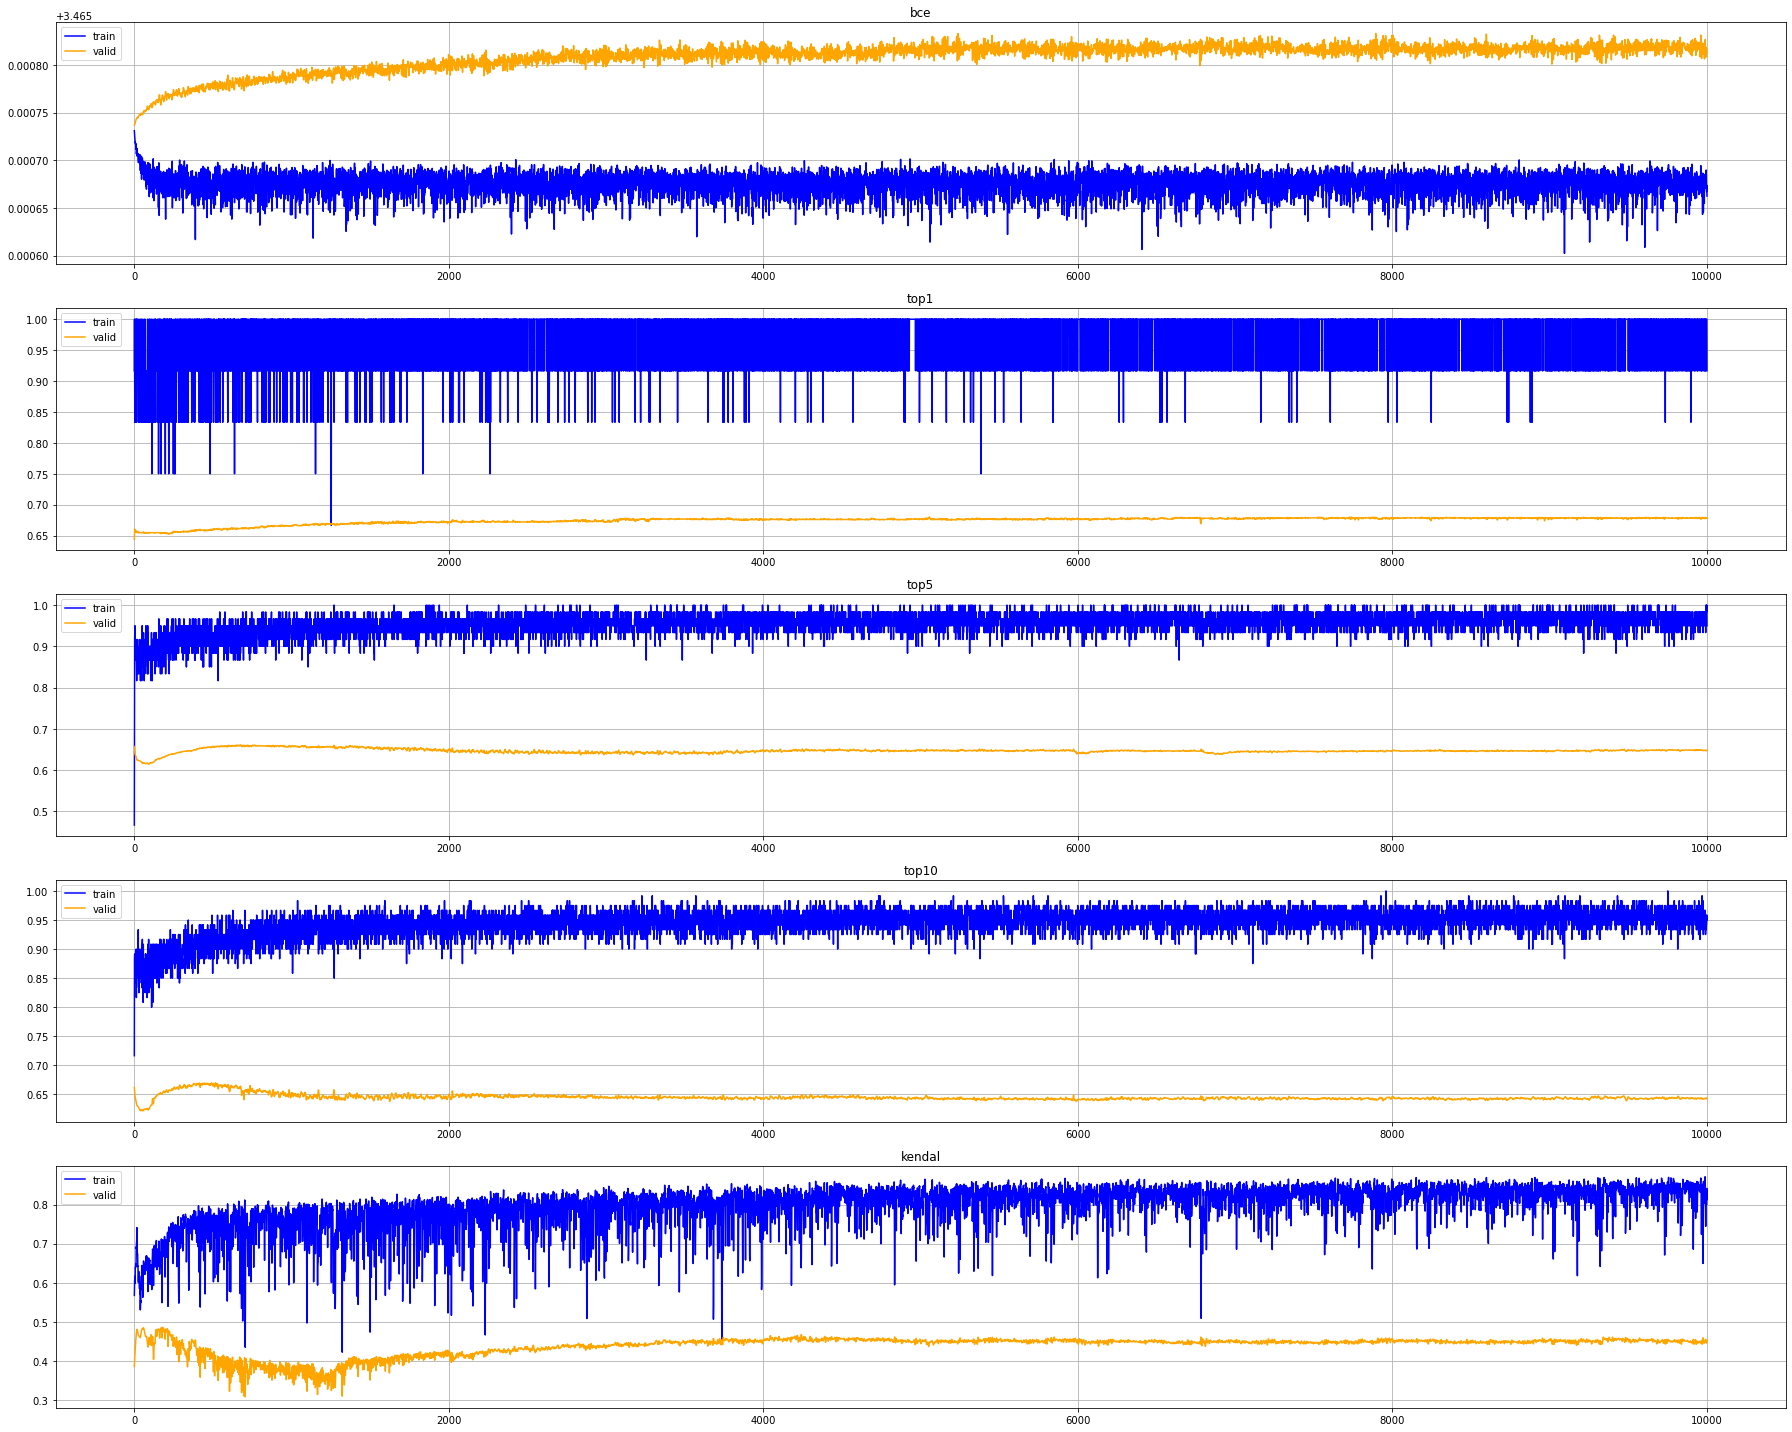

In [41]:
import matplotlib.pyplot as plt

with open(setting.train_info_p, 'r') as train_info, \
    open(setting.val_info_p, 'r') as valid_info:
    
    train = json.load(train_info)
    valid = json.load(valid_info)

    epochs = setting.epochs
    keys = list(train.keys())

    x = np.linspace(1, epochs, epochs)
    
    ### plot bce loss and mean top N %
    fig, axs = plt.subplots(len(keys), figsize=(25, 4 * len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        if key == "bce":
            y_train = [v/nodes_cnt for v in train[key]]
            y_valid = [v/5000 for v in valid[key]]
            ax.plot(x, y_train, color="blue")
            ax.plot(x, y_valid, color="orange")            
        else:
            ax.plot(x, train[key], color="blue")
            ax.plot(x, valid[key], color="orange")
        
        ax.legend(["train", "valid"], loc='upper left')
        ax.set_title(key)
        ax.grid()
        
    plt.tight_layout()
    plt.savefig(setting.result_plt_p, facecolor="white")

# Baseline

In [ ]:
import networkit as nk

In [ ]:
G = nk.readGraph("/hw1_data/Synthetic/5000/0.txt", nk.Format.EdgeListTabZero)

## RK (DIAM)

### ApproxBetweenness

In [ ]:
ab = nk.centrality.ApproxBetweenness(G, epsilon=0.1)
ab.run()

In [ ]:
# The 10 most central nodes according to betweenness are then 
ab.ranking()[:10]

## ARBA

## KADABRA

In [ ]:
# Initialize algorithm 
kadabra = nk.centrality.KadabraBetweenness(G, 0.05, 0.8) 
kadabra.run() 

In [ ]:
#The 10 most central nodes according to betweenness are then 
kadabra.ranking()[:10]

## K-BC (KPATH)

In [ ]:
kbc = nk.centrality.KPathCentrality(G, alpha=0.2, k=0)
kbc.run()

In [ ]:
kbc.ranking()[:10]